In [2]:
import numpy as np
import matplotlib.pyplot as plt
from webbpsf import NIRCam
from astropy.io import fits
from jwst.resample import resample_step
from jwst.datamodels import ImageModel
import os
os.environ['WEBBPSF_PATH'] = '/quasar/yichenliu/webbpsf-data'

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from webbpsf import NIRCam
from jwst.datamodels import ImageModel
from astropy.wcs import WCS

# Initialize NIRCam with F250M filter
nircam = NIRCam()
nircam.filter = 'F250M'

from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'none'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import os, sys

from importlib import reload

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars
from photutils.centroids import centroid_com

from scipy.ndimage import shift

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

sys.path.append('..')

import dither.utils as dutils
import dither.wrapper as wrapper
import dither.updated as updated

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [3]:
%matplotlib inline

In [4]:
# Function to extract the central 10% of an array
def extract_central_region(image, fraction=0.2):
    center_x, center_y = np.array(image.shape) // 2
    half_width_x, half_width_y = (np.array(image.shape) * fraction // 2).astype(int)
    return image[
        center_x - half_width_x : center_x + half_width_x,
        center_y - half_width_y : center_y + half_width_y,
    ]

make oversampled image

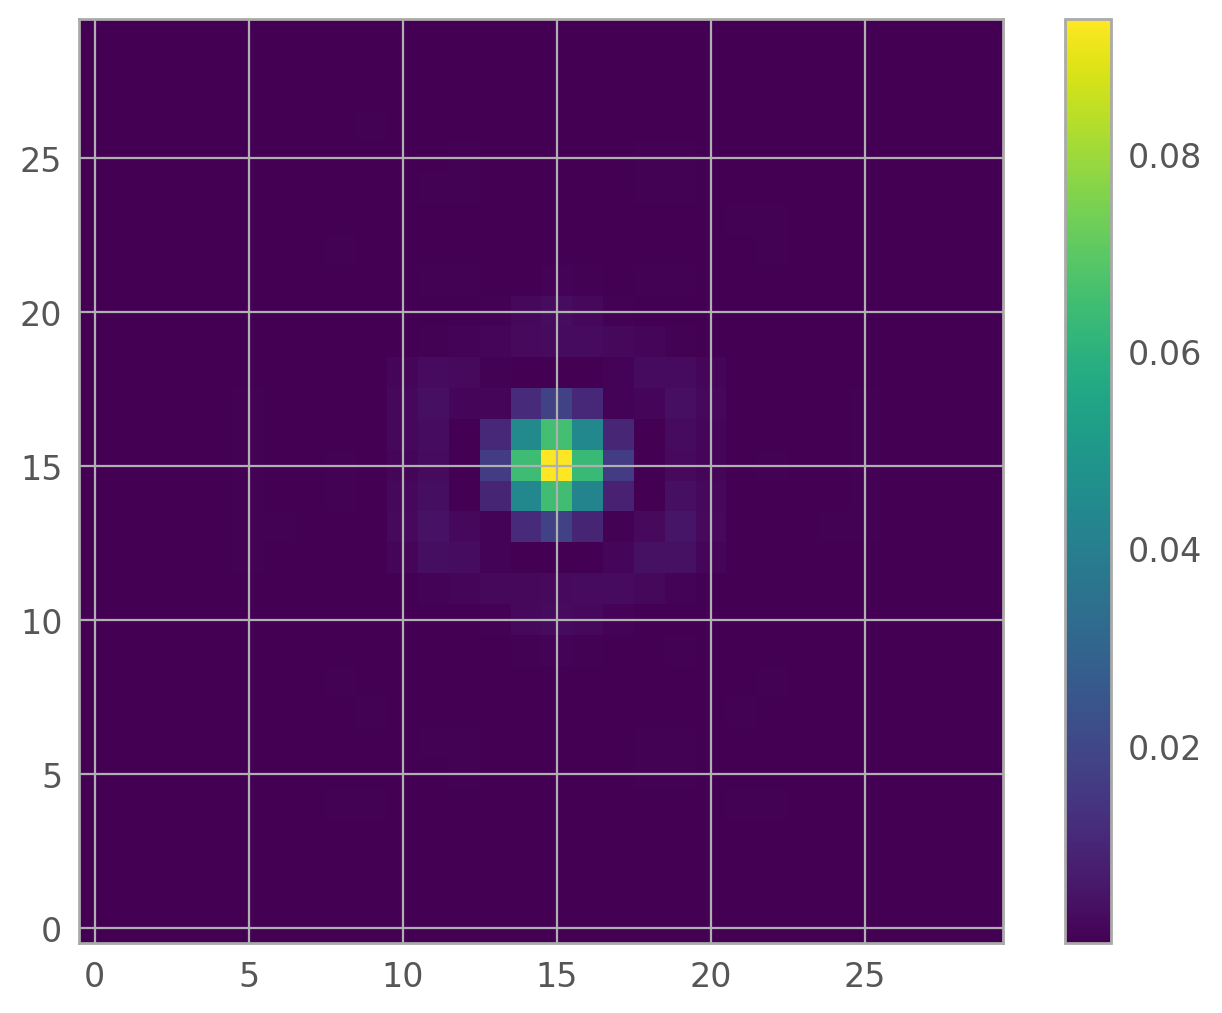

In [655]:
# Generate oversampled PSF (factor of 2)
oversample_factor = 2
app = 0.063 # pixel scale in arcsec / pixel for SW channel
nircam.options['source_offset_x'] = 0.25*app
nircam.options['source_offset_y'] = 0.25*app
oversampled_psf = nircam.calc_psf(oversample=oversample_factor)
oversampled_data = oversampled_psf[0].data

plt.imshow(extract_central_region(oversampled_data), cmap='viridis')
plt.colorbar()

make 9 dither images

In [302]:
# Generate 9 dithered images at random positions
num_dithers = 9
dither_images = []
# dither_offsets_pixel = np.random.uniform(-0.5, 0.5, size=(num_dithers, 2))  # random offsets in pixel
dither_offsets_pixel = np.random.rand(num_dithers, 2) - 0.5  # random offsets in pixel
dither_offsets_pixel *= 50
dither_offsets_pixel[0] = [0, 0]
dither_offsets = dither_offsets_pixel*app # random offsets in arcsec

for i, (dx, dy) in enumerate(dither_offsets):
    # Set the image shift for dithering
    # nircam.options['image_shift'] = (dx, dy)
    nircam.options['source_offset_x'] = dx
    nircam.options['source_offset_y'] = dy
    # print(nircam.options['source_offset_x'], nircam.options['source_offset_y'])
    psfdu = nircam.calc_psf(oversample=1)
    # save data
    psf = psfdu[0].data
    # add noise
    # psf += np.random.normal(loc=0, scale=0.39/5, size=psf.shape) # roughly 5 sigma noise
    dither_images.append(psf)
    output_file = f'dither_image/{i}.fits'
    image_model = ImageModel(psfdu)
    # # wcs = WCS(psfdu[0].header)
    # test_wcs.bounding_box = None
    # image_model.meta.wcs = test_wcs
    image_model.save(output_file)
    # psfdu.writeto(output_file, overwrite=True)  # Set overwrite=True to overwrite existing files

# print(f'HDUList saved to {output_file}')

2024-11-26 21:08:04,704 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/stdatamodels/validate.py:38: ValidationWarning: While validating meta.instrument.name the following error occurred:
'NIRCam' is not one of ['NIRCAM', 'NIRSPEC', 'MIRI', 'TFI', 'FGS', 'NIRISS', 'ANY', 'N/A']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Instrument used to acquire the data'),
                 ('type', 'string'),
                 ('enum',
                  ['NIRCAM',
                   'NIRSPEC',
                   'MIRI',
                   'TFI',
                   'FGS',
                   'NIRISS',
                   'ANY',
                   'N/A']),
                 ('fits_keyword', 'INSTRUME'),
                 ('blend_table', True)])

On instance:
    'NIRCam'
  warnings.warn(errmsg, ValidationWarning)

2024-11-26 21:08:04,706 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/stdatamodels/validat

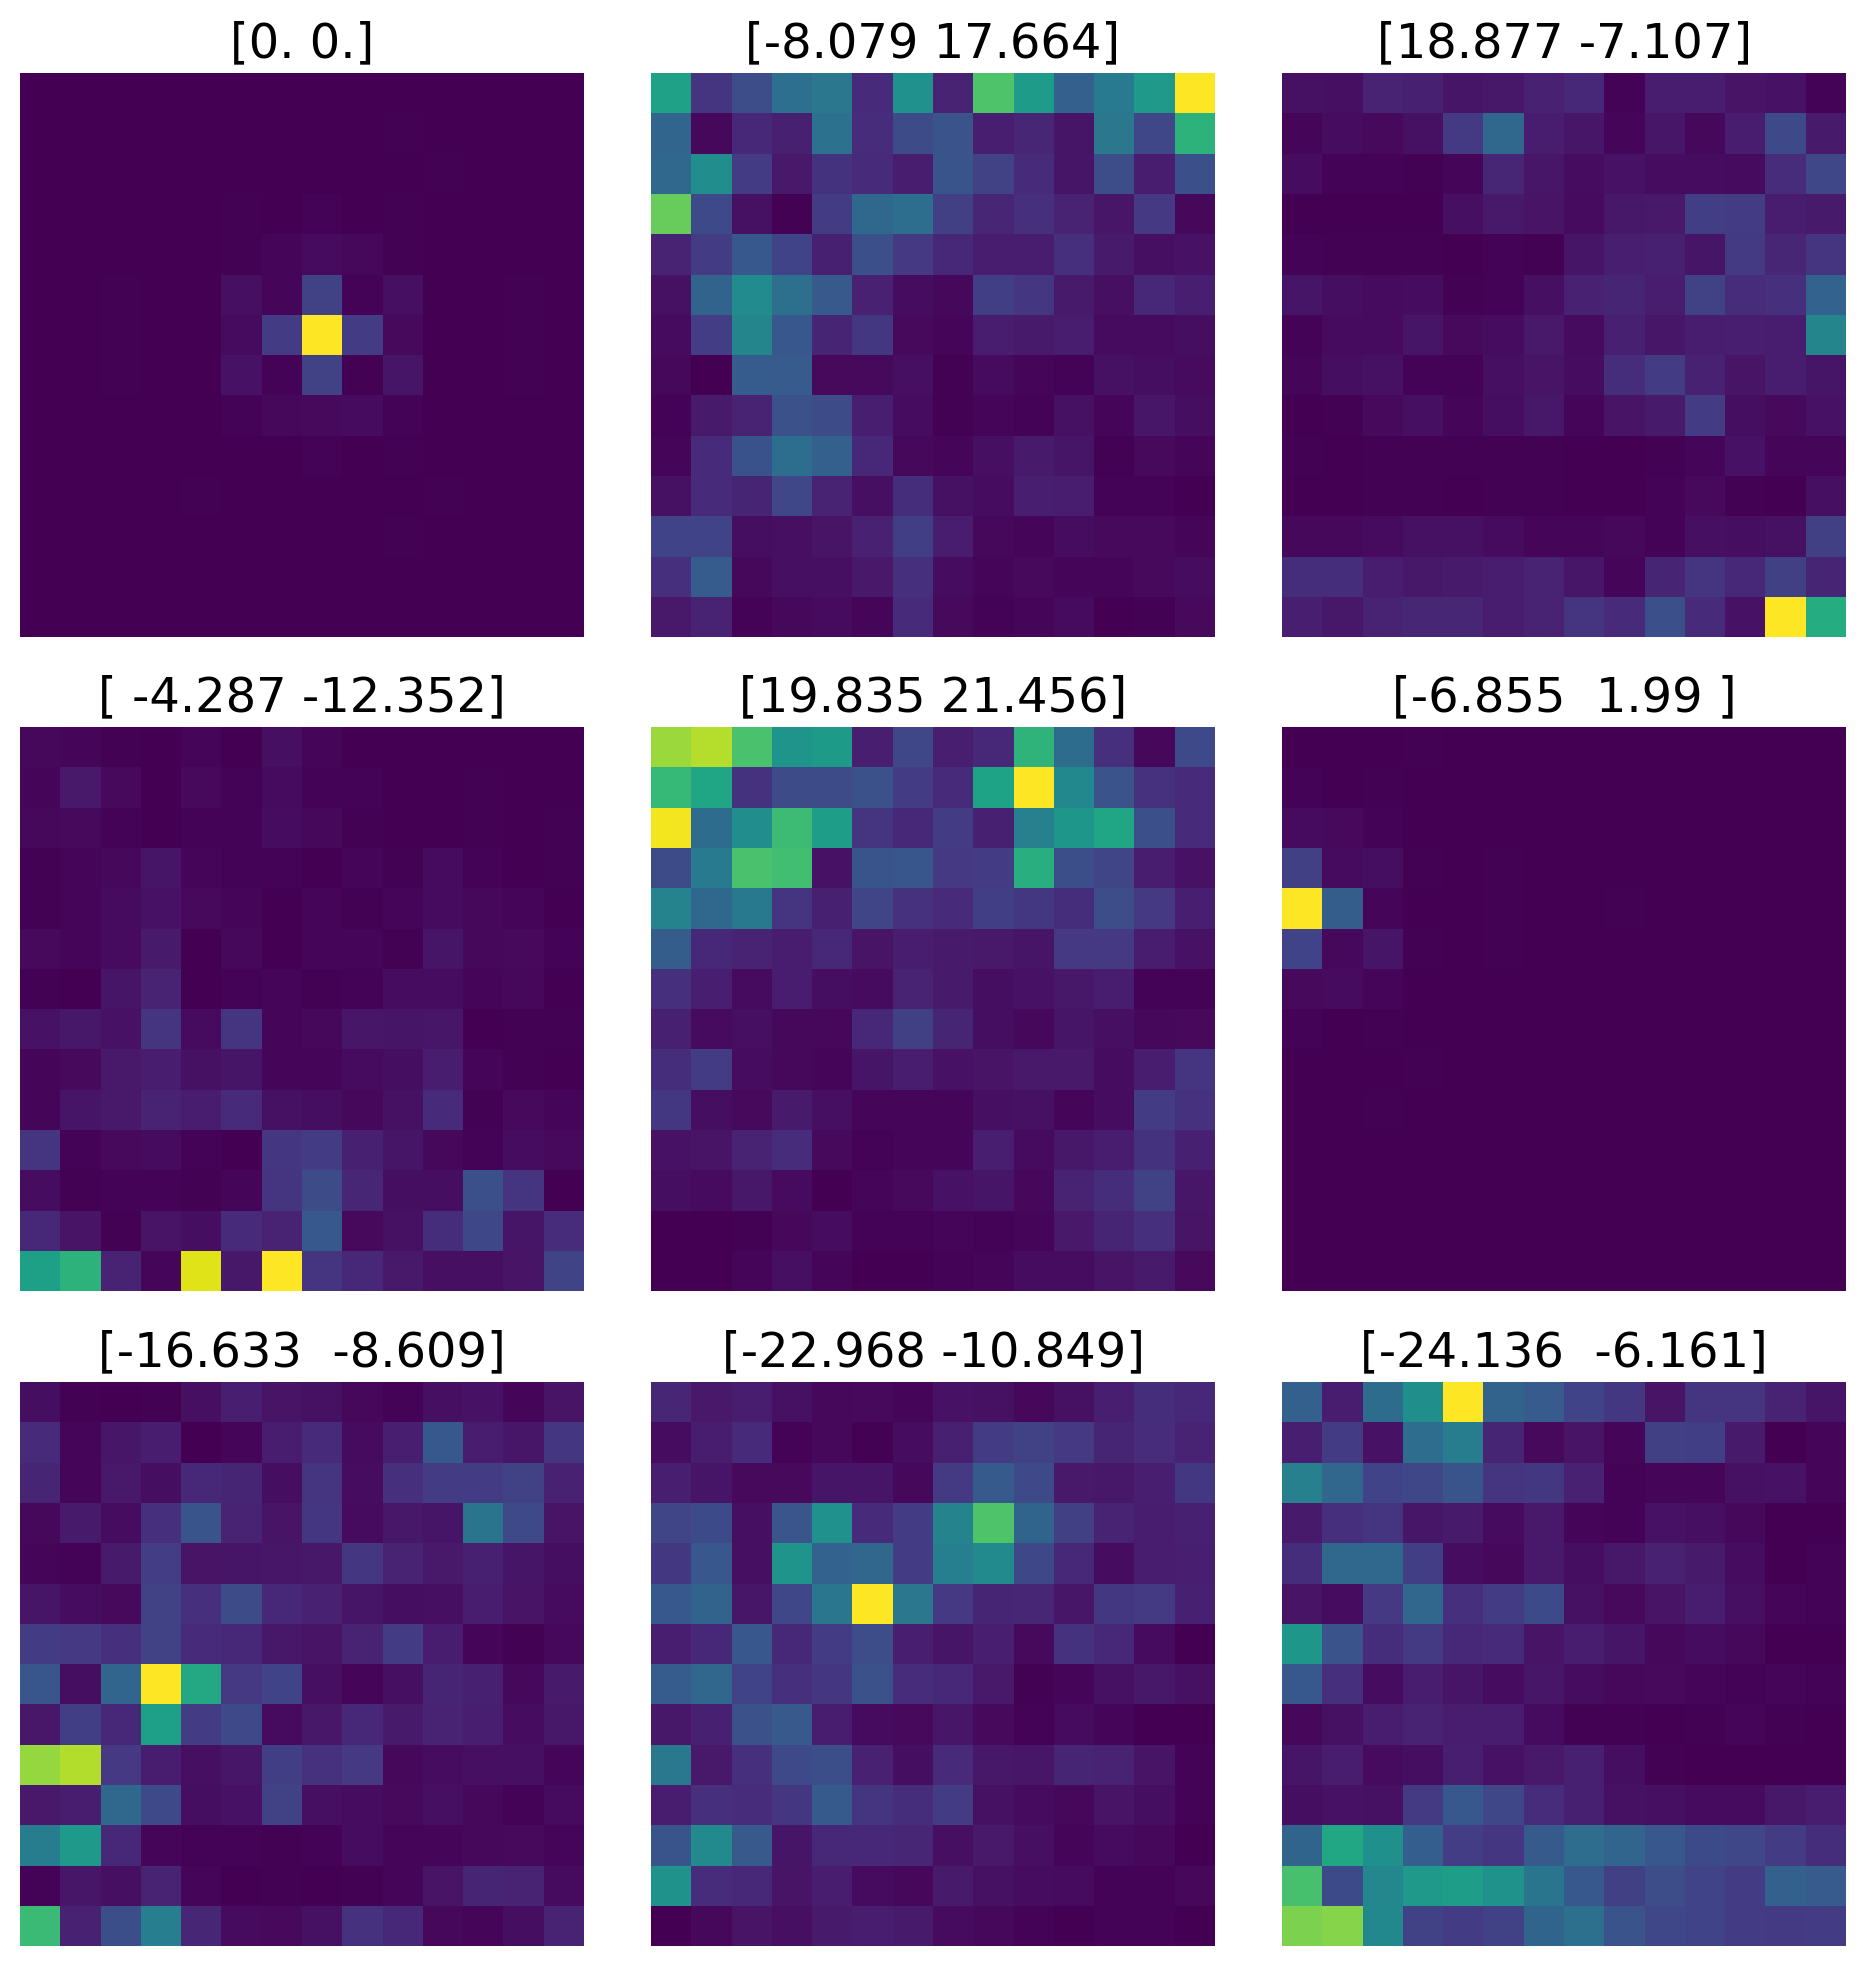

In [303]:
central_dithers = [extract_central_region(image) for image in dither_images]

# Plot the central part of 9 dithered images in a grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(central_dithers[i], origin='lower', cmap='viridis')
    ax.set_title(dither_offsets_pixel[i])
    ax.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

naive drizzle

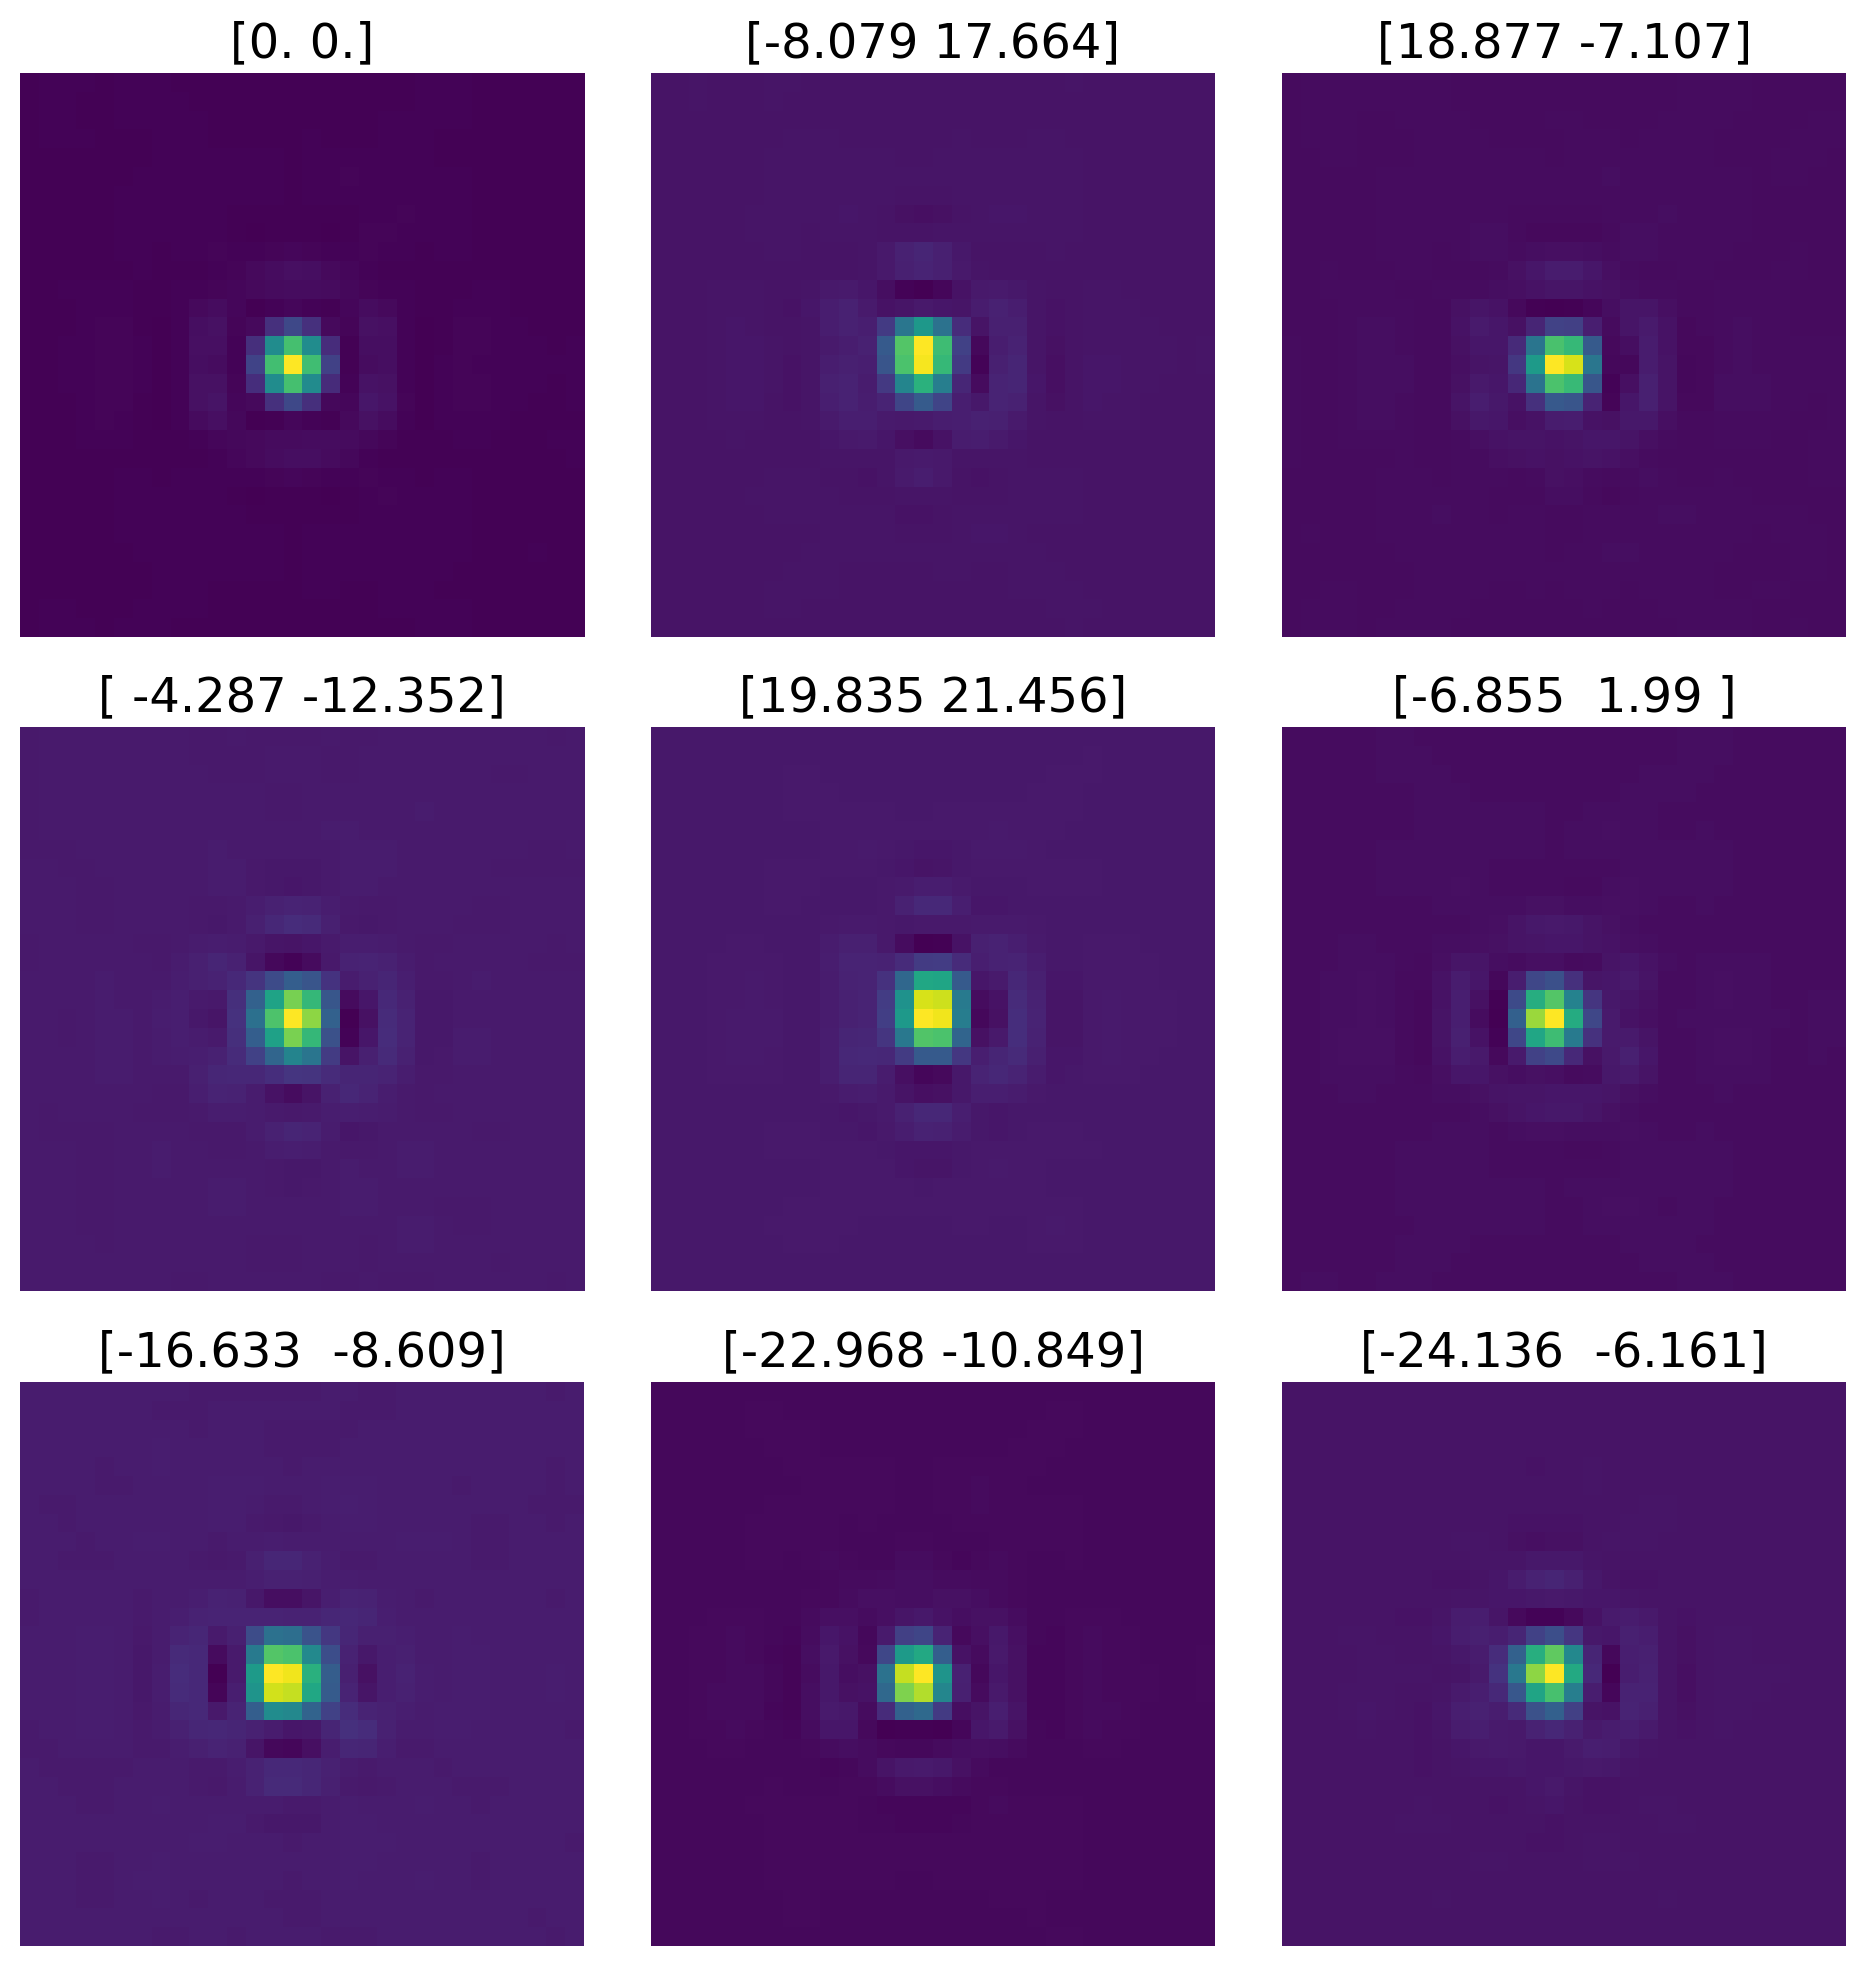

In [304]:
from scipy.ndimage import shift, zoom

shifted_images = []
for image, (dx, dy) in zip(dither_images, dither_offsets_pixel):
    # shifted_image = enlarge_and_reproject(image, dx, dy)
    shifted_image = image.copy()
    shifted_image = zoom(shifted_image, zoom=2)/4
    shifted_image = shift(shifted_image, shift=[-dy*2-0.5, -dx*2-0.5], order=3)
    shifted_images.append(shifted_image)



central_dithers = [extract_central_region(image) for image in shifted_images]

# Plot the central part of 9 dithered images in a grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    ax.imshow(central_dithers[i], origin='lower', cmap='viridis')
    ax.set_title(dither_offsets_pixel[i])
    ax.axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

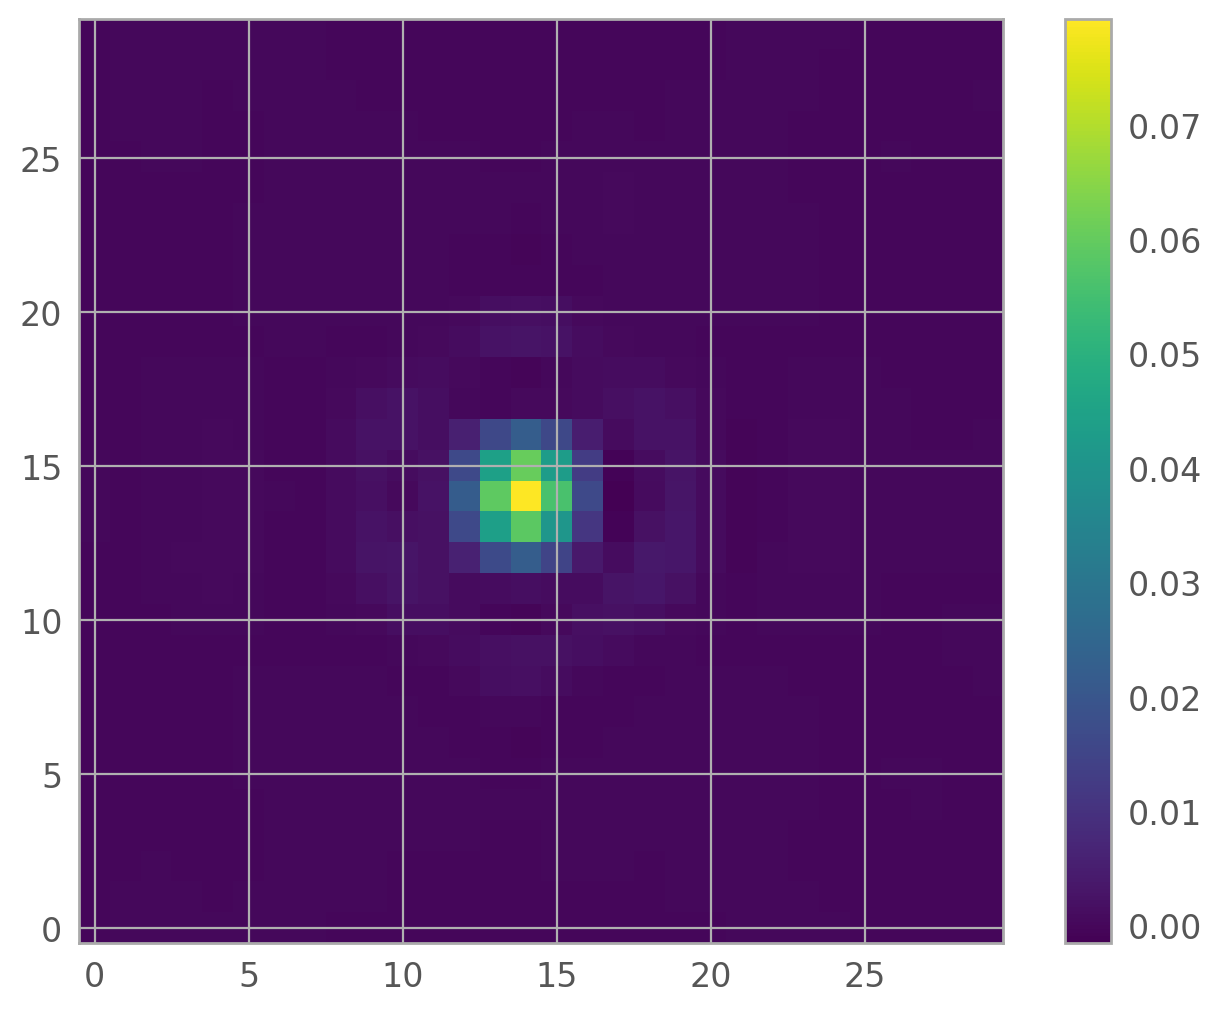

In [305]:
drizzled_image = np.sum(shifted_images, axis=0)/9

plt.imshow(extract_central_region(drizzled_image), cmap='viridis')
plt.colorbar()

test residual

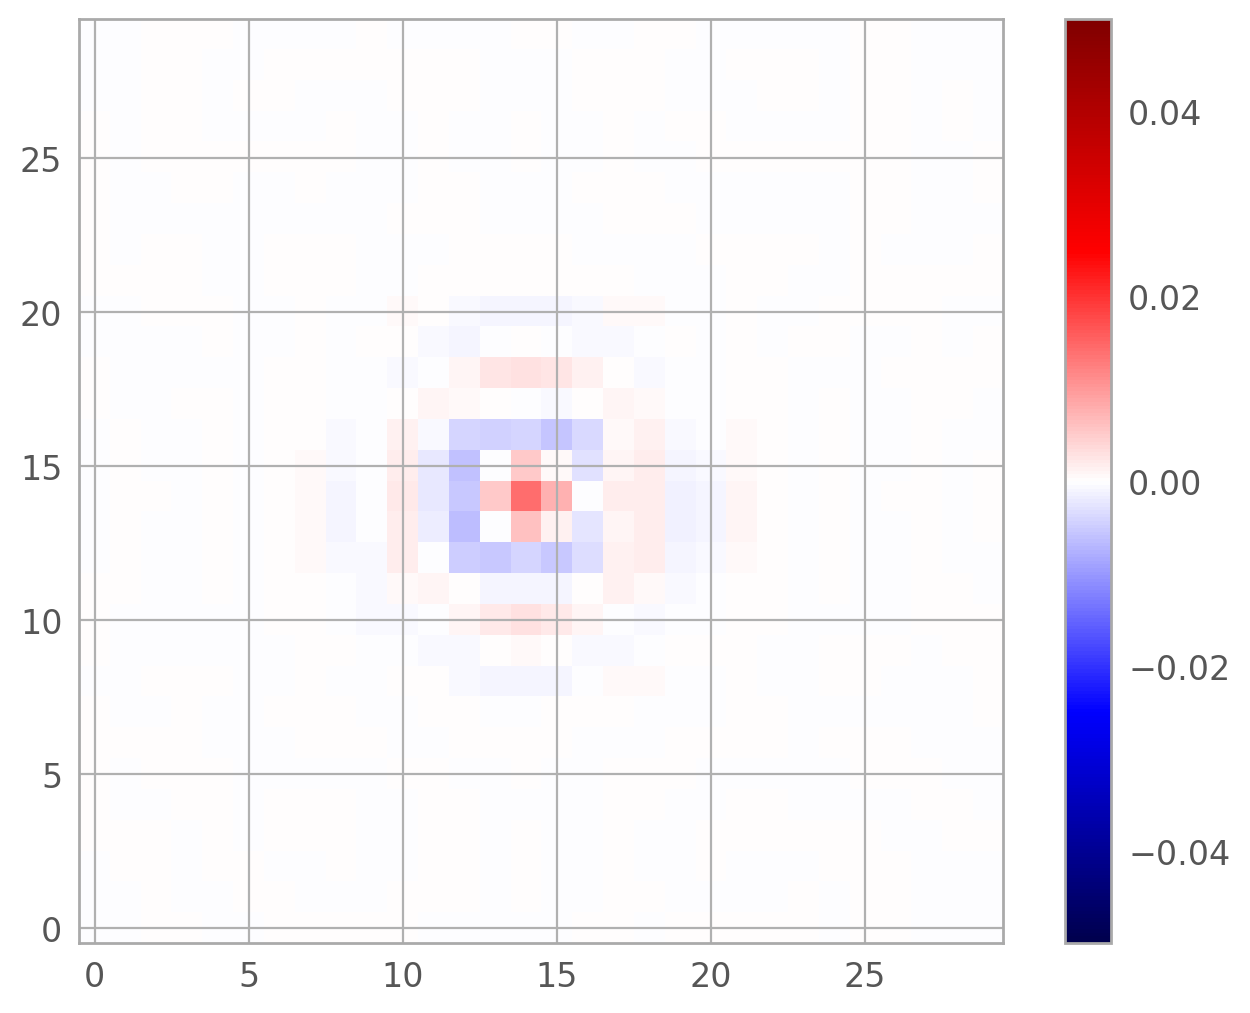

In [306]:
plt.imshow(extract_central_region(oversampled_data - drizzled_image),
           cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()

In [372]:
np.max(np.abs(oversampled_data - drizzled_image))

0.01441304797528449

using Lauer(99) method

In [307]:
aligned_atlas = dither_images
centroids = dither_offsets_pixel
cx = 39
cy = 39

# NOTE: dutils.get_pixel_center_from_array returns 40, needs to be fix?

centroids

array([[  0.   ,   0.   ],
       [ -8.079,  17.664],
       [ 18.877,  -7.107],
       [ -4.287, -12.352],
       [ 19.835,  21.456],
       [ -6.855,   1.99 ],
       [-16.633,  -8.609],
       [-22.968, -10.849],
       [-24.136,  -6.161]])

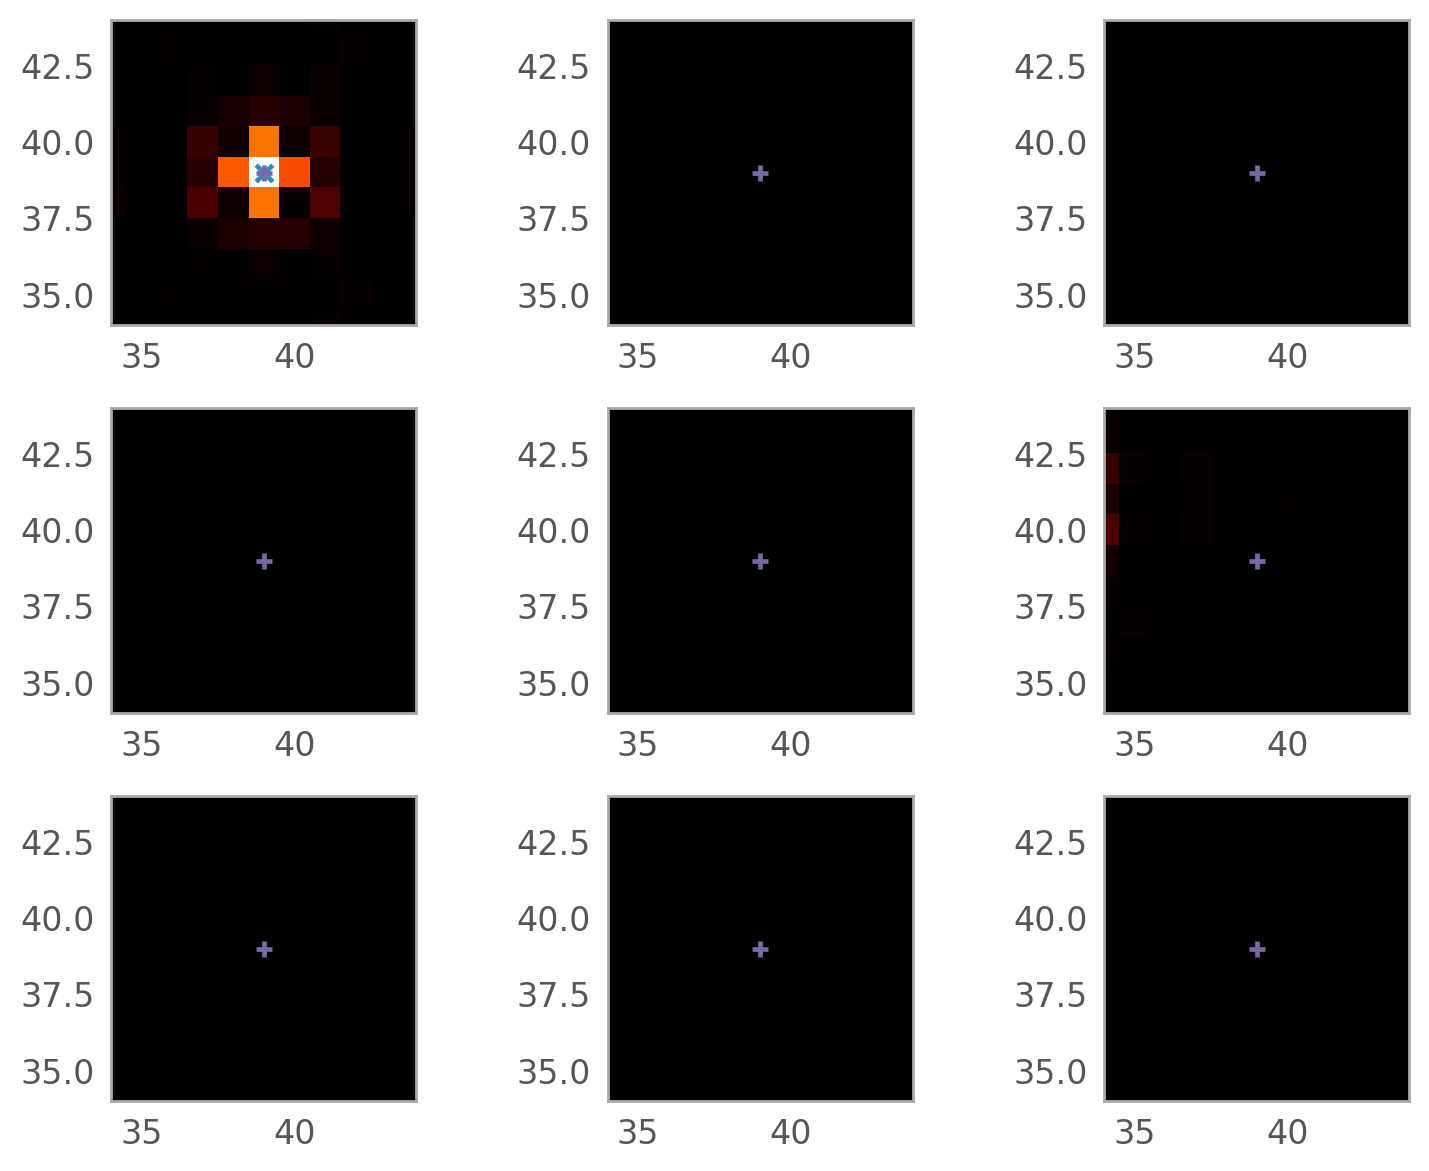

In [308]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    qso_center = [cx+centroids[i, 0], cx+centroids[i, 1]]
    img_center = [cx, cy]
    axs[i].imshow(np.arcsinh(data), vmin=0, vmax=0.1)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    axs[i].set_xlim(cx-5, cx+5)
    axs[i].set_ylim(cy-5, cy+5)
    axs[i].grid(False)
plt.tight_layout()
plt.show()

[[  0.      0.      1.   ]
 [ 17.664  -8.079   1.   ]
 [ -7.107  18.877   1.   ]
 [-12.352  -4.287   1.   ]
 [ 21.456  19.835   1.   ]
 [  1.99   -6.855   1.   ]
 [ -8.609 -16.633   1.   ]
 [-10.849 -22.968   1.   ]
 [ -6.161 -24.136   1.   ]]


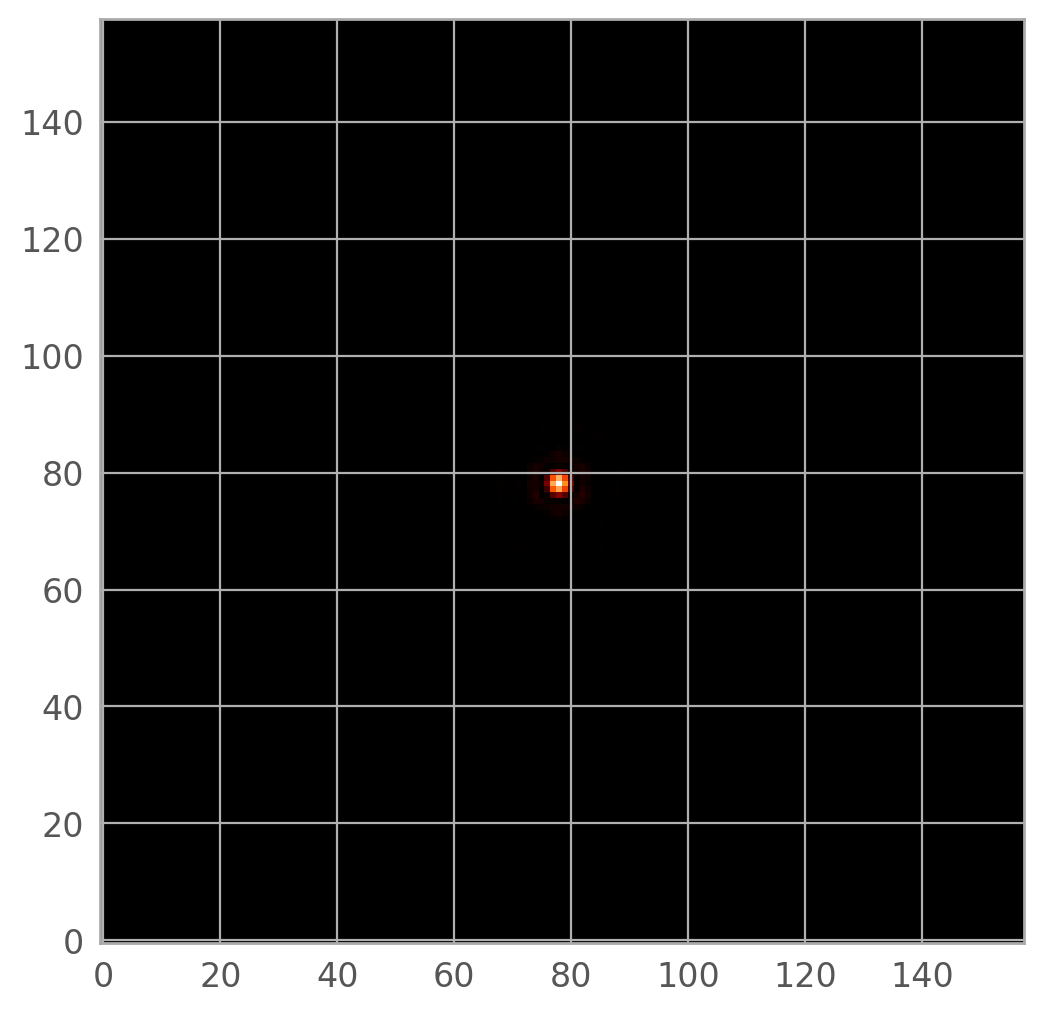

In [309]:
from dither.wrapper import NR_FREQ, NC_FREQ
NSUB = 2


used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((centroids[used_indices, 1:2], 
                     centroids[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
# offsets[0, 0] = 0
# offsets[0, 1] = 0
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = aligned_atlas[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = updated.real2dfft_forward(data_large)
    n = i + 1
    Aphased = updated.phase_shift(A, offsets, n, verbose=False)
    Atotal += Aphased

f = updated.real2dfft_backward(Atotal)

nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(stretch(f[:nx_large, :ny_large]))
plt.show()

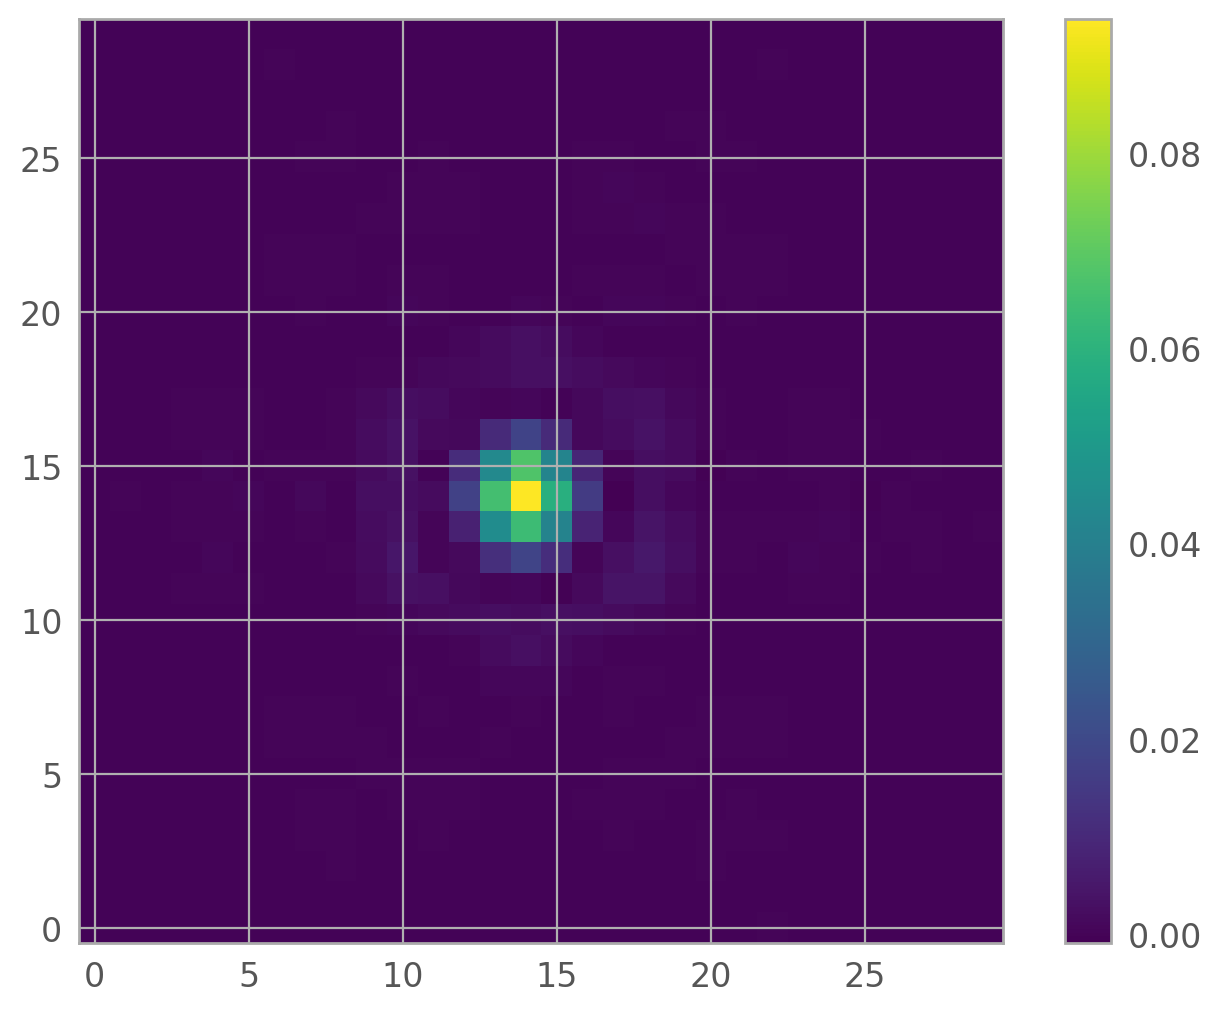

In [310]:
proper_coadd_image = f[:nx_large, :ny_large]/4

# plt.imshow(proper_coadd_image, cmap='viridis', vmax=0.05)
# plt.colorbar()

# qso_center = [cx*2+centroids[0, 0]*2, cx*2+centroids[0, 1]*2]
# img_center = [cx*2, cy*2]
# plt.scatter(*qso_center, marker='x')
# plt.scatter(*img_center, marker='+')
# plt.xlim(70, 90)
# plt.ylim(70, 90)

plt.imshow(extract_central_region(proper_coadd_image), cmap='viridis')
plt.colorbar()

test residual

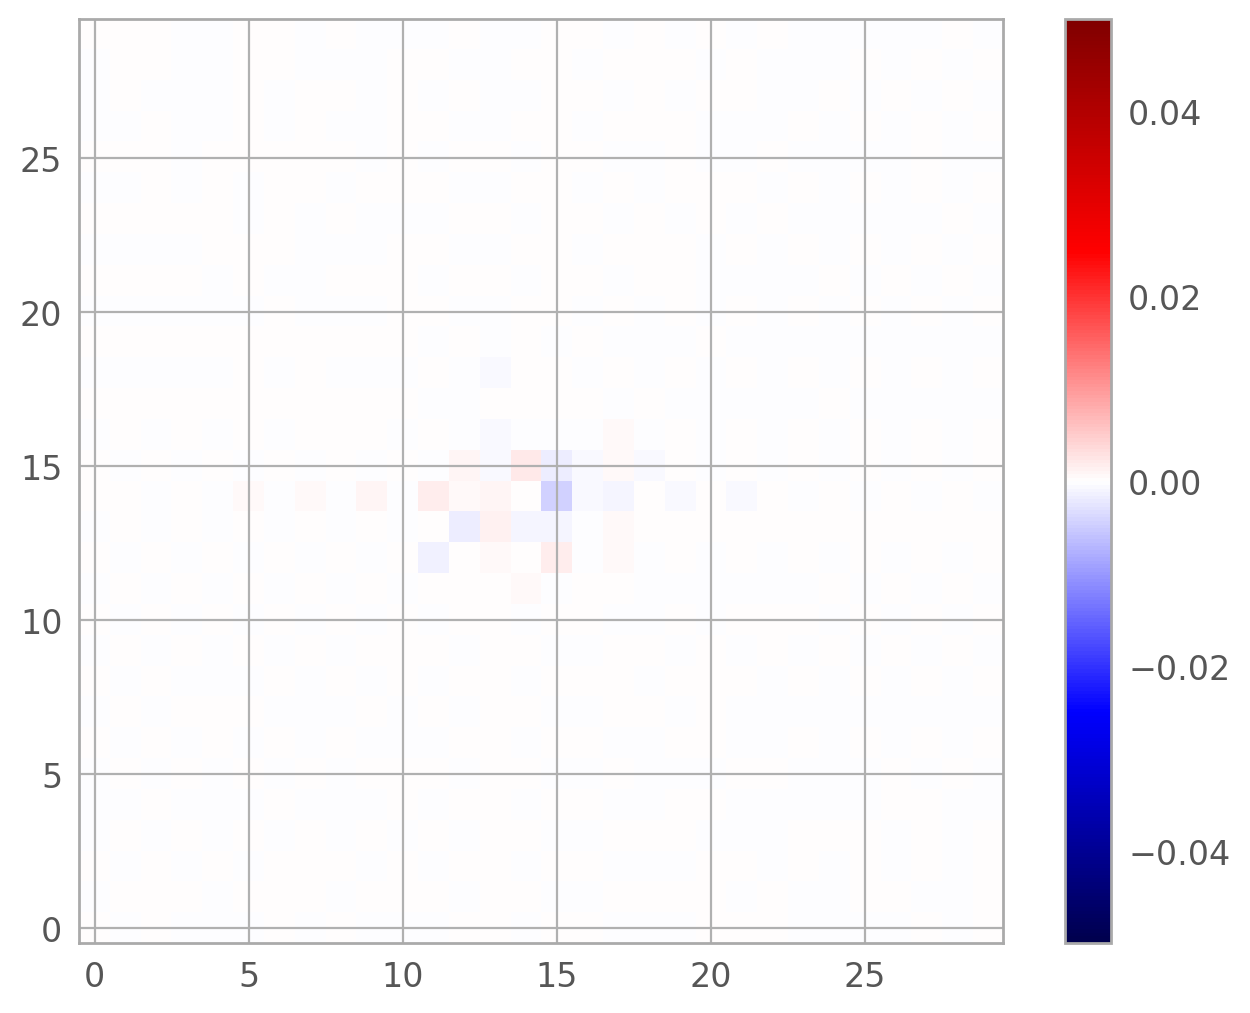

In [311]:
# proper_coadd_image_shifted = proper_coadd_image

plt.imshow(extract_central_region(proper_coadd_image - oversampled_data), 
           cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar()

In [371]:
np.max(np.abs(proper_coadd_image - oversampled_data))

0.0046128388576070975

compare power spectrum

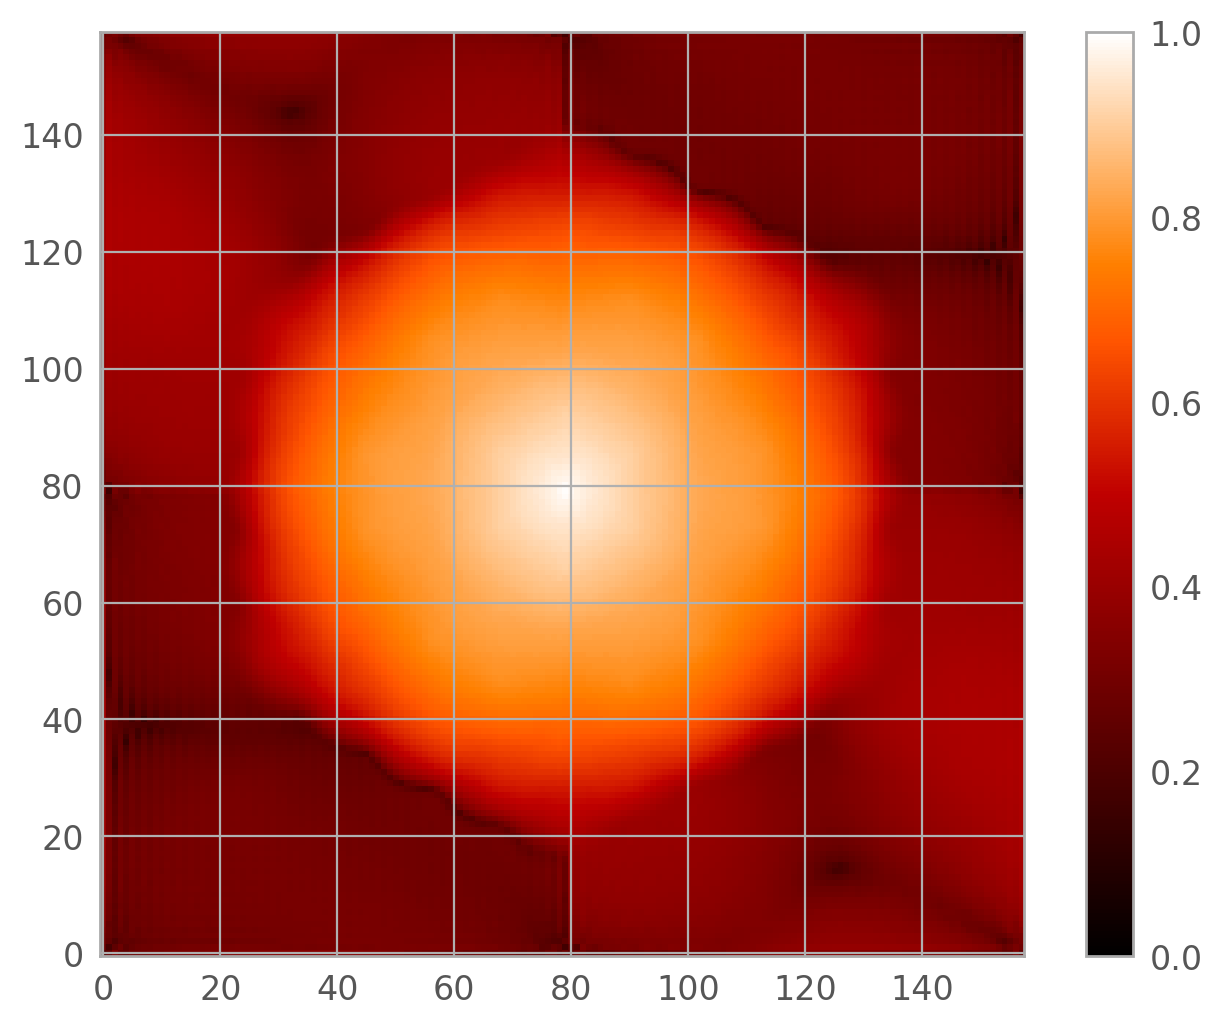

In [312]:
# pow = dutils.get_power_spectrum_from_realfft2d(wrapper.fft(proper_coadd_image))
pow = dutils.get_power_spectrum(fft.fft2(proper_coadd_image))
plt.imshow(pow**0.1, vmin=0, vmax=1)
plt.colorbar()
plt.show()

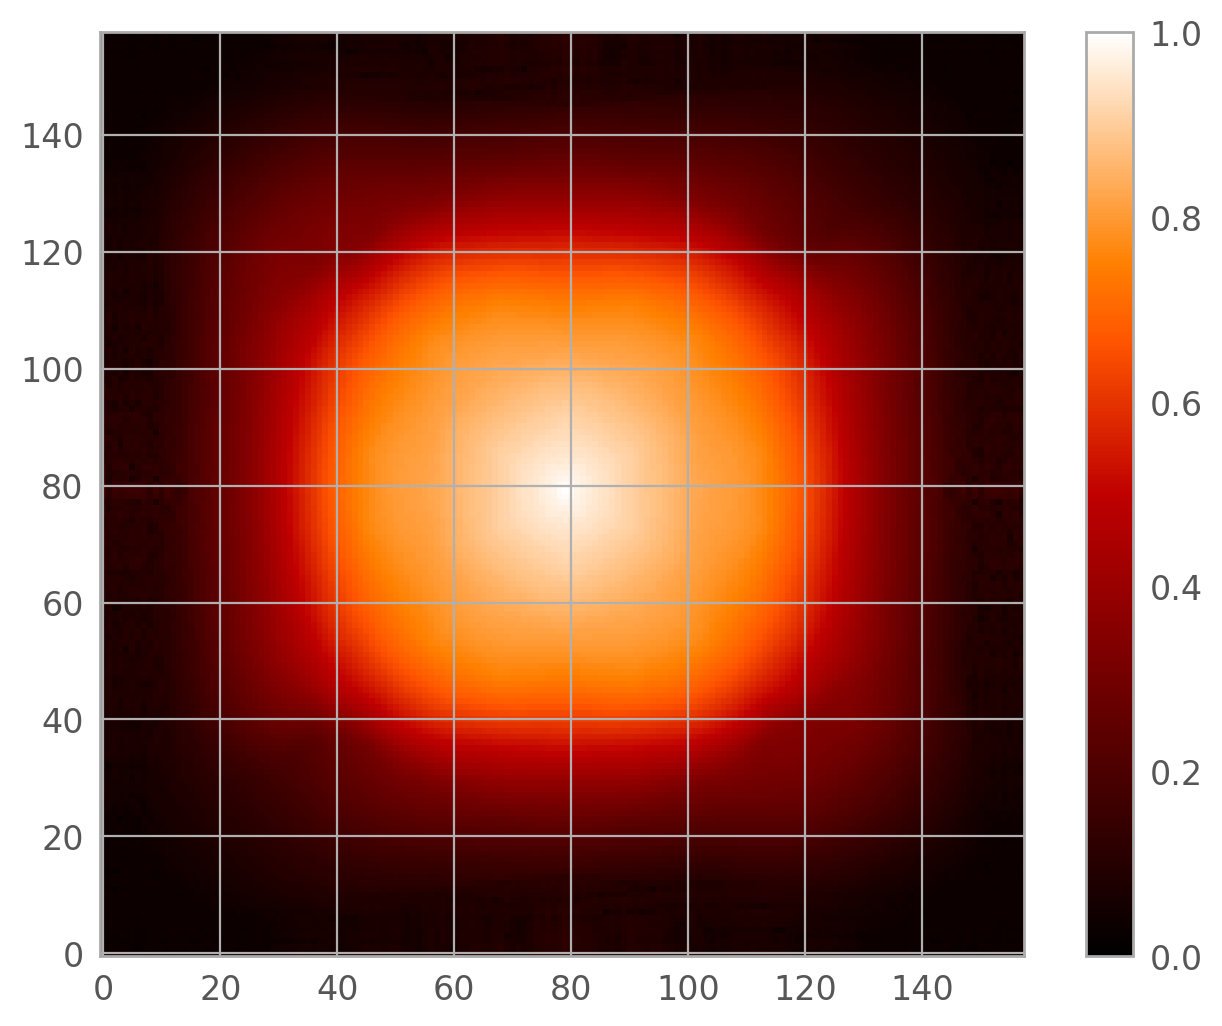

In [313]:
# pow = dutils.get_power_spectrum_from_realfft2d(wrapper.fft(drizzled_image))
pow = dutils.get_power_spectrum(fft.fft2(drizzled_image))
plt.imshow(pow**0.1, vmin=0, vmax=1)
plt.colorbar()
plt.show()

try using jwst pipeline to do drizzle

In [80]:
dither_offsets

array([[ 0.   ,  0.   ],
       [-0.025, -0.002],
       [ 0.015, -0.015],
       [ 0.022, -0.03 ],
       [ 0.019,  0.014],
       [-0.004,  0.023],
       [ 0.004,  0.02 ],
       [-0.018,  0.012],
       [-0.006, -0.017]])

In [132]:
hdu1 = fits.open('dither_image_stage2/8.fits')
print(hdu1[0].header['VA_RA'])
# from gwcs.wcs import WCS
from astropy.wcs import WCS
WCS(hdu1[1].header)

2024-11-25 17:52:34,364 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-03-03T11:37:18.007' from MJD-BEG.
Set DATE-AVG to '2023-03-03T11:41:19.585' from MJD-AVG.
Set DATE-END to '2023-03-03T11:45:21.162' from MJD-END'.
  warnings.warn(

2024-11-25 17:52:34,366 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   138.334660 from OBSGEO-[XYZ].
Set OBSGEO-B to    19.735397 from OBSGEO-[XYZ].
Set OBSGEO-H to 1405100547.135 from OBSGEO-[XYZ]'.
  warnings.warn(



231.6510708976376


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : -0.00602035316914001 -0.01701654018729729 
CRPIX : 1024.5 1024.5 
CD1_1 CD1_2  : -4.5245176191629e-06 -1.694940520581e-05 
CD2_1 CD2_2  : -1.6863942770342e-05 4.5233219071124e-06 
NAXIS : 79  79

In [268]:

hdu = fits.open(dummy_fits_path)
WCS(hdu[0].header)

WCS Keywords

Number of WCS axes: 2
CTYPE : '' '' 
CRVAL : 0.0 0.0 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 1.0 1.0 
NAXIS : 0  0

In [672]:

from astropy.modeling.models import Shift, Multiply
import numpy as np
from astropy.modeling import models
from astropy import coordinates as coord
from astropy import units as u
from gwcs import wcs
from gwcs import coordinate_frames as cf

dummy_fits_path = '../jw02078071001_05101_00002_nrcblong_cal.fits'
outdir = 'dither_image_stage2'

detector_frame = cf.Frame2D(name="detector", axes_names=("x", "y"),
                            unit=(u.pix, u.pix))
sky_frame = cf.CelestialFrame(reference_frame=coord.ICRS(), name='icrs',
                              unit=(u.deg, u.deg))

for i in range(9):
    with fits.open(dummy_fits_path) as hdu: 
        # print(hdu.info())
        outpath = os.path.join(outdir, f'{i}.fits')
        print(outpath)
        nx, ny = dither_images[i].shape
        ra, dec = dither_offsets[i]/3600 # in degree
        # hdu[1].header['CRVAL1'] = ra
        # hdu[1].header['CRVAL2'] = dec
        # hdu[1].header['RA_V1'] = ra
        # hdu[1].header['DEC_V1'] = dec
        # hdu[1].header['RA_REF'] = ra
        # hdu[1].header['DEC_REF'] = dec
        # hdu[0].header['TARG_RA'] = ra
        # hdu[0].header['TARG_DEC'] = dec
        # hdu[0].header['VA_RA'] = ra
        # hdu[0].header['VA_DEC'] = dec
        # hdu[0].header['GS_RA'] = ra
        # hdu[0].header['GS_DEC'] = dec
        # hdu[0].header['PROP_RA'] = ra
        # hdu[0].header['PROP_DEC'] = dec
        # hdu[1].header['S_REGION'] =  f'POLYGON ICRS  {ra+0.05} {dec-0.05} {ra+0.05} {dec-0.05} {ra+0.05} {dec-0.05} {ra+0.05} {dec-0.05}'
        # hdu[1].header['CTYPE1'] = 'RA---TAN'
        # hdu[1].header['CTYPE2'] = 'DEC--TAN'
        hdu[1].data = dither_images[i]
        hdu[2].data = np.full((nx, ny), 0, dtype='uint32')
        hdu[3].data = np.full((nx, ny), 0, dtype='>f4')
        hdu[4].data = np.full((nx, ny), 0, dtype='>f4')
        hdu[5].data = np.full((nx, ny), 0, dtype='>f4')
        hdu[6].data = np.full((nx, ny), 0, dtype='>f4')
        hdu[7].data = np.full((nx, ny), 0, dtype='>f4')
        # del hdu[8]
        # print(hdu.info())
        hdu.writeto('temp.fits', overwrite=True)
        
        # model = ImageModel('temp.fits')
        # model = ImageModel(psfdu)
        model = ImageModel(
            (79, 79)
        )
        model.data = dither_images[i]
        model.meta.wcsinfo = {
            # 'crval1': 0.,
            # 'crval2': 0.,
            # 'ctype1': 'RA---TAN',
            # 'ctype2': 'DEC--TAN',
            # 'cunit1': 'deg',
            # 'cunit2': 'deg',
            'dec_ref': 0., # used in calculating scale of pc
            # 'latpole': 0.,
            # 'lonpole': 180.0,
            # 'mjdref': 0.0,
            'ra_ref': 0., # used in calculating scale of pc
            # 'radesys': 'ICRS',
            # 'roll_ref': 284.9138843266624,
            # 's_region': 'POLYGON ICRS  231.673035231 -20.857642543 231.635491388 -20.848731273 231.625791923 -20.883012334 231.662824507 -20.892693699',
            # 'sipiverr': 0.07248836907865927,
            # 'sipmxerr': 0.07702802251722982,
            # 'v2_ref': -89.387412,
            # 'v3_ref': -491.352394,
            'v3yangle': 0., # used in calculating rotation of pc
            # 'velosys': -29133.45,
            'vparity': 1, # used in calculating rotation of pc
            # 'wcsaxes': 2,
            # 'wcsname': 'world'
        }
        # Attribute names to set
        exposure_attributes = [
            'exposure_time',
            'duration',
            'start_time',
            'end_time',
            'measurement_time',
            'effective_exposure_time',
            'elapsed_exposure_time'
        ]

        # Target base object
        # exposure = model.meta.exposure

        # Loop to set each attribute dynamically
        for attr in exposure_attributes:
            setattr(model.meta.exposure, attr, 0)  # Set each attribute to 0

        # Define shifts
        # ra_shift = np.random.choice([0, 1])*0.001  # degrees
        # dec_shift = np.random.choice([0, 1])*0.001  # degrees
        ra_shift = -ra  # degrees
        dec_shift = -dec  # degrees

        # Get the current WCS object from the ASDF file
        # asdf_wcs = model.meta.wcs

        # Modify the forward transform by adding RA/Dec shifts
        # new_forward_transform = asdf_wcs.forward_transform | (Shift(ra_shift) & Shift(dec_shift))

        dx, dy = dither_offsets_pixel[i]
        pixelcenter = models.Shift(-(79-1)/2) & models.Shift(-(79-1)/2)
        pc_rotation_matrix = models.AffineTransformation2D(matrix=[[1.,  0.], [ 0.,  1.]], translation=[0., 0.])
        pixelscale = models.Scale(app/3600) & models.Scale(app/3600) # deg/pixel
        tangent_projection = models.Pix2Sky_TAN()
        celestial_rotation = models.RotateNative2Celestial(0, 0, 180)
        det2sky = pixelcenter | pixelscale | tangent_projection | celestial_rotation
        skyshift = models.Shift(-ra) & models.Shift(-dec)
        new_forward_transorm = pixelcenter | pc_rotation_matrix | pixelscale | tangent_projection | celestial_rotation | skyshift

        # pixel_scale_transform = Multiply(app/3600) & Multiply(app/3600)
        # shift_transform = Shift(ra_shift) & Shift(dec_shift)
        # new_forward_transform = pixel_scale_transform | shift_transform
        # pixel_shift_transform = Shift(ra/app) & Shift(dec/app)

        # Create a new WCS object with the updated forward transform
        new_wcs = WCS(
            forward_transform=new_forward_transorm,
            input_frame=detector_frame,
            output_frame=sky_frame
        )
        model.meta.wcs = new_wcs
        print(ra_shift, dec_shift, dx, dy)

        model.save(outpath)

dither_image_stage2/0.fits
-0.0 -0.0 0.0 0.0
dither_image_stage2/1.fits
0.00014138492500728037 -0.00030912006008485237 -8.079138571844592 17.664003433420135
dither_image_stage2/2.fits
-0.0003303412192704013 0.00012437773416274436 18.87664110116579 -7.107299095013964
dither_image_stage2/3.fits
7.501758400598916e-05 0.00021616529274457867 -4.286719086056523 -12.352302442547353
dither_image_stage2/4.fits
-0.00034712079817541874 -0.0003754741026853101 19.8354741814525 21.45566301058915
dither_image_stage2/5.fits
0.0001199571031219775 -3.482078635173604e-05 -6.8546916069701425 1.989759220099202
dither_image_stage2/6.fits
0.00029107439672304455 0.00015065082133765658 -16.63282266988826 -8.608618362151804
dither_image_stage2/7.fits
0.000401935739154243 0.00018985782032385318 -22.9677565230996 -10.84901830422018
dither_image_stage2/8.fits
0.00042238382364990807 0.0001078212116458748 -24.136218494280463 -6.161212094049989


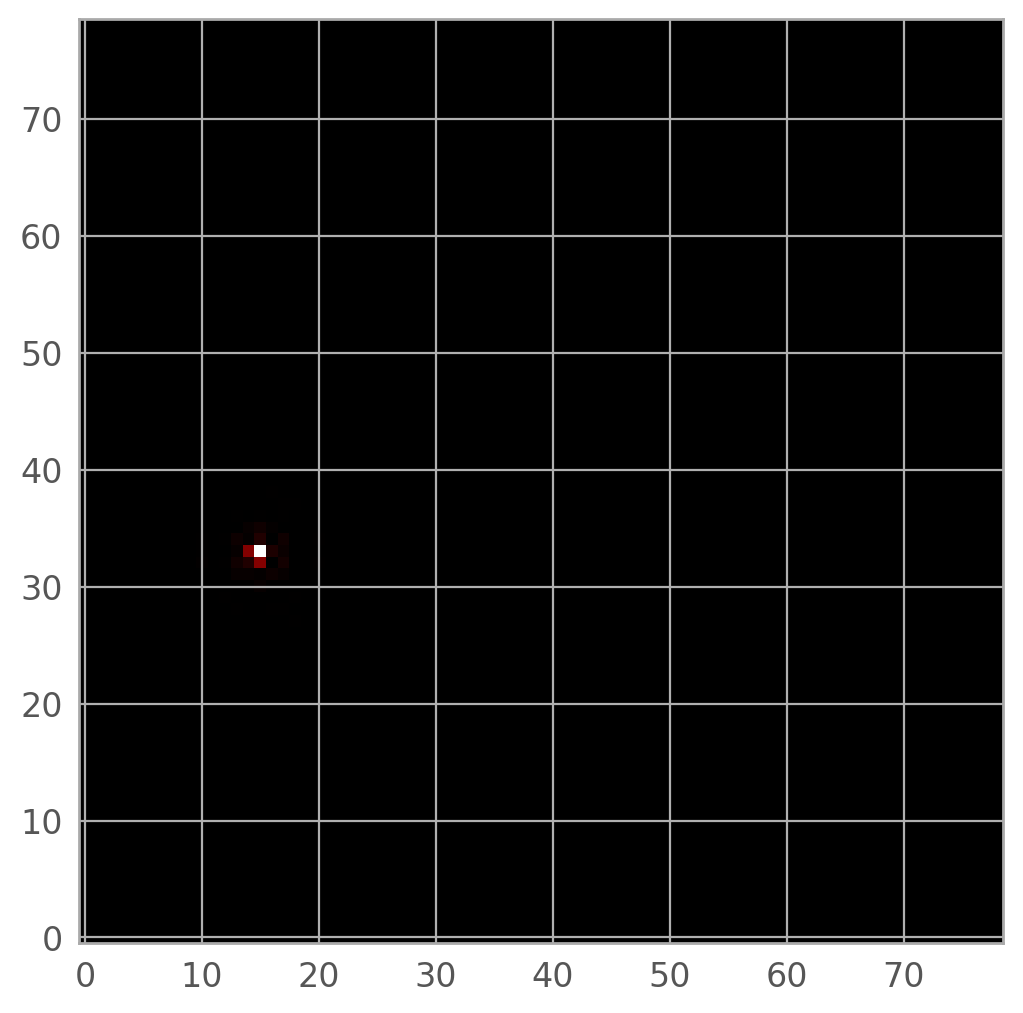

In [576]:
plt.imshow(model.data)

In [671]:
with ImageModel('dither_image_stage2/0.fits') as m:
    first_wcs = m.meta.wcs
first_wcs

for t in first_wcs.forward_transform:
    print(t, end='\n\n')

Model: Shift
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    offset
    ------
     -39.0

Model: Shift
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    offset
    ------
     -39.0

Model: AffineTransformation2D
Inputs: ('x', 'y')
Outputs: ('x', 'y')
Model set size: 1
Parameters:
       matrix   translation
    ----------- -----------
    -1.0 .. 1.0  0.0 .. 0.0

Model: Scale
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
     factor 
    --------
    1.75e-05

Model: Scale
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
     factor 
    --------
    1.75e-05

Model: Pix2Sky_Gnomonic
Inputs: ('x', 'y')
Outputs: ('phi', 'theta')
Model set size: 1
Parameters:

Model: RotateNative2Celestial
Inputs: ('phi_N', 'theta_N')
Outputs: ('alpha_C', 'delta_C')
Model set size: 1
Parameters:
    lon lat lon_pole
    --- --- --------
    0.0 0.0    180.0

Model: Shift
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    offset
  

In [666]:
result.meta.wcs.forward_transform[2]

<AffineTransformation2D(matrix=[[-1.,  0.], [ 0.,  1.]], translation=[0., 0.], name='pc_rotation_matrix')>

In [670]:
for t in result.meta.wcs.forward_transform:
    print(t, end='\n\n')

Model: Shift
Name: crpix1
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    offset
    ------
     -79.0

Model: Shift
Name: crpix2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    offset
    ------
     -79.0

Model: AffineTransformation2D
Name: pc_rotation_matrix
Inputs: ('x', 'y')
Outputs: ('x', 'y')
Model set size: 1
Parameters:
       matrix   translation
    ----------- -----------
    -1.0 .. 1.0  0.0 .. 0.0

Model: Scale
Name: cdelt1
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
     factor 
    --------
    8.75e-06

Model: Scale
Name: cdelt2
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
     factor 
    --------
    8.75e-06

Model: Pix2Sky_Gnomonic
Inputs: ('x', 'y')
Outputs: ('phi', 'theta')
Model set size: 1
Parameters:

Model: RotateNative2Celestial
Inputs: ('phi_N', 'theta_N')
Outputs: ('alpha_C', 'delta_C')
Model set size: 1
Parameters:
    lon lat lon_pole
    --- --- --------
    0.0 0.0    180.0



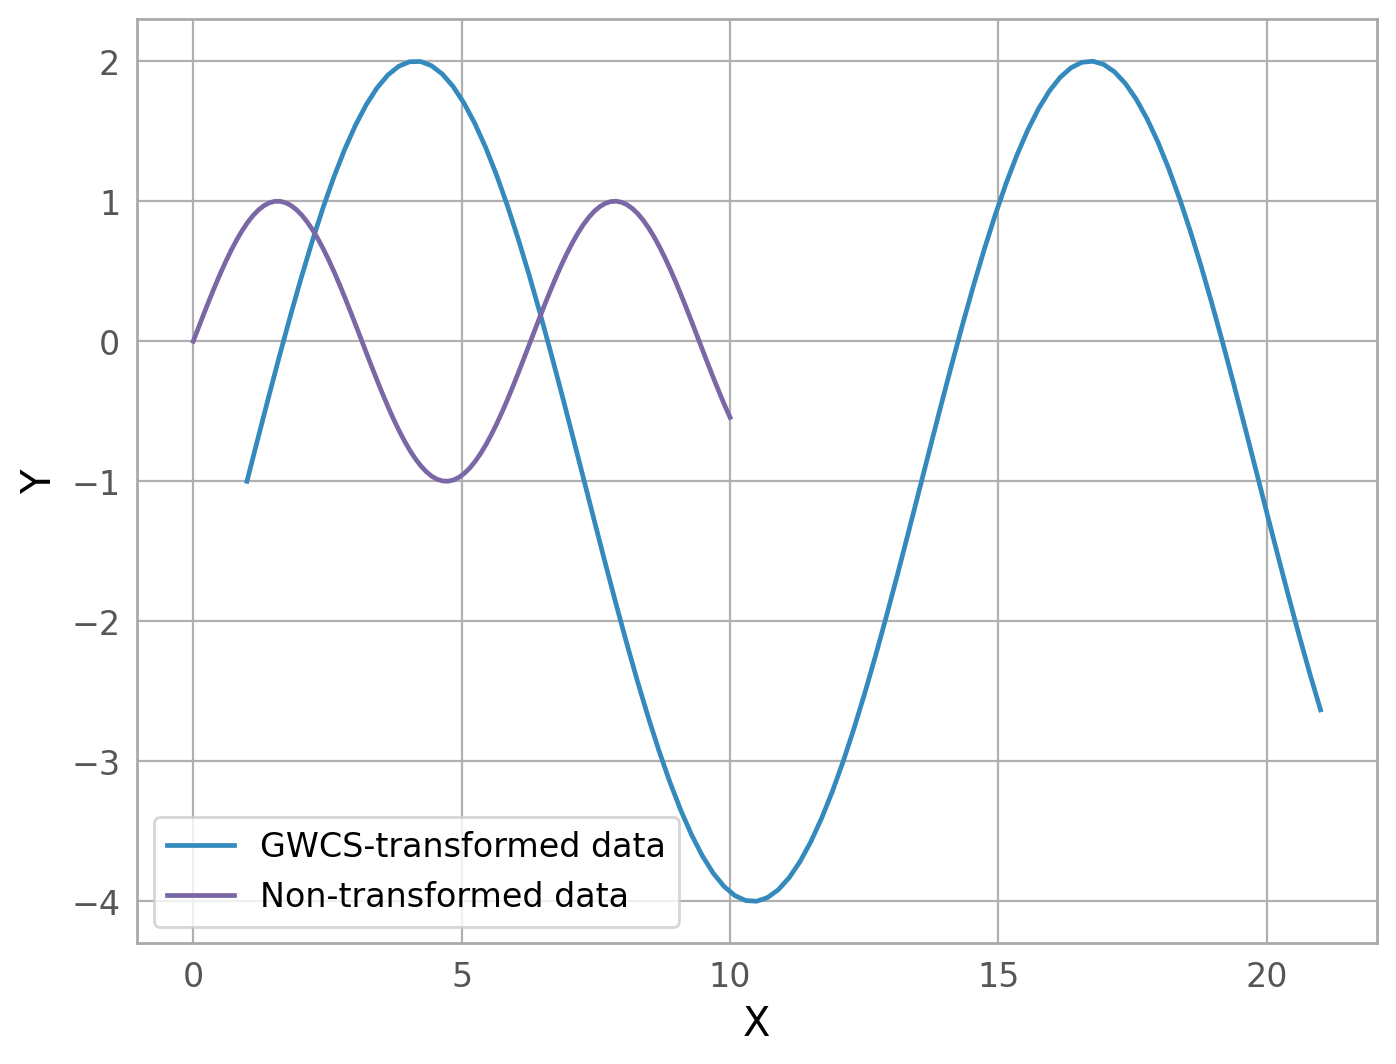

In [574]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Transform
from gwcs import WCS
from astropy.modeling.models import Shift, Scale
from gwcs import coordinate_frames as cf
detector_frame = cf.Frame2D(name="detector", axes_names=("x", "y"),
                            unit=(u.pix, u.pix))
sky_frame = cf.CelestialFrame(reference_frame=coord.ICRS(), name='icrs',
                              unit=(u.deg, u.deg))

# Example GWCS forward transform: scale and shift
forward_transform = Scale(2) & Scale(3) | (Shift(1) & Shift(-1))
input_frame = detector_frame  # Use your GWCS input frame here
output_frame = sky_frame  # Use your GWCS output frame here
gwcs = WCS(forward_transform=forward_transform, input_frame=input_frame, output_frame=output_frame)

# Custom matplotlib transform using GWCS
class GWCSMatplotlibTransform(Transform):
    def __init__(self, wcs, **kwargs):
        super().__init__(**kwargs)
        self.wcs = wcs

    def transform(self, points):
        # Transform points using GWCS forward transform
        transformed_points = self.wcs.forward_transform(points[:, 0], points[:, 1])
        return np.column_stack(transformed_points)

    def transform_non_affine(self, points):
        return self.transform(points)

    @property
    def input_dims(self):
        return 2  # Input is 2D

    @property
    def output_dims(self):
        return 2  # Output is 2D

    @property
    def is_separable(self):
        return False  # Custom transform may not be separable

# Create the custom transform
custom_transform = GWCSMatplotlibTransform(gwcs)

# Example data
x = np.linspace(0, 10, 100)
y = np.sin(x)

# Create a plot
fig, ax = plt.subplots()
ax.plot(x, y, transform=custom_transform + ax.transData, label='GWCS-transformed data')
ax.plot(x, y, label='Non-transformed data')

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

# Show plot
plt.show()


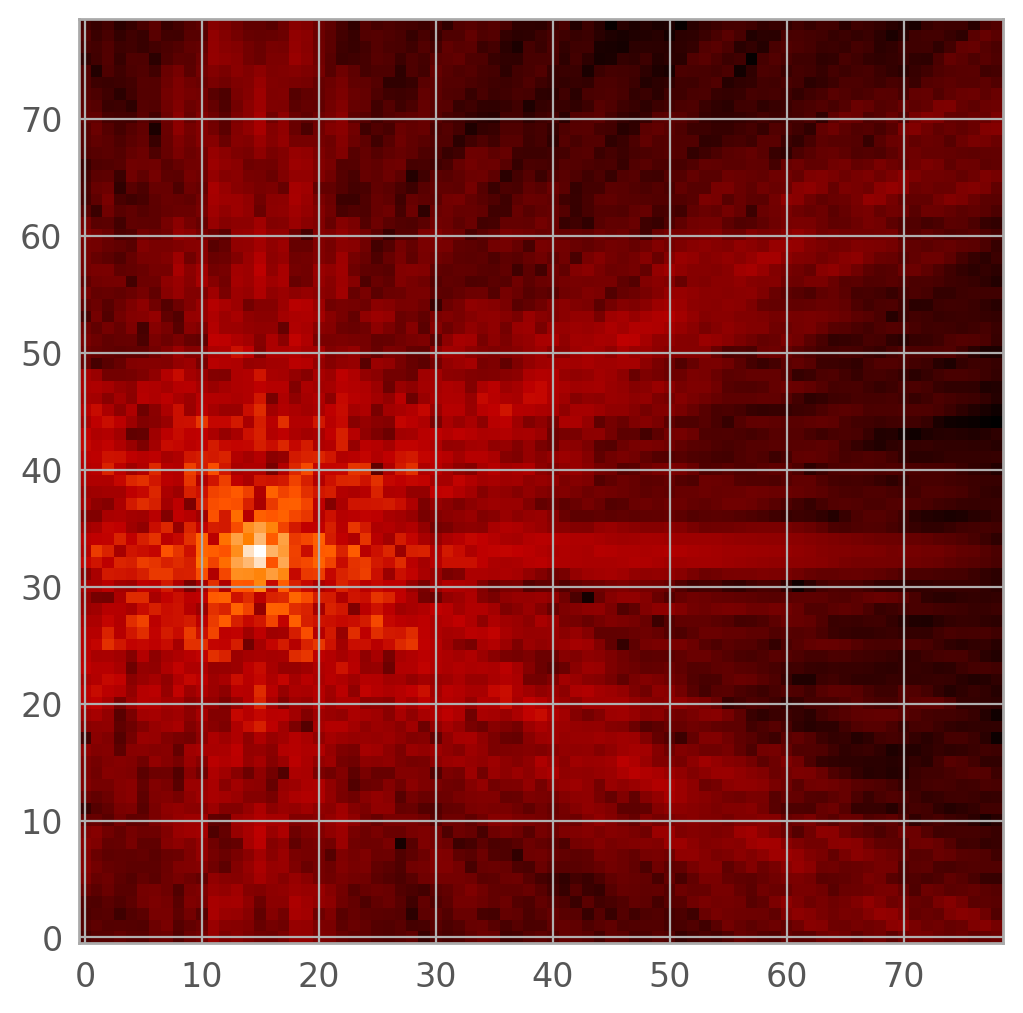

In [548]:
plt.imshow(np.log(psfdu[0].data))

# plt.imshow(psfdu[3])

In [502]:
model = ImageModel(dummy_fits_path)

# model.meta.wcsinfo.instance
# model.meta.exposure.duration
# model.meta.exposure.exposure_time
# dir(model.meta.exposure)
model.meta.wcsinfo.instance

{'a_0_2': 1.6251542355643088e-06,
 'a_0_3': -7.655884581305747e-12,
 'a_1_1': -1.1810766901656673e-05,
 'a_1_2': 1.8558891581002539e-09,
 'a_2_0': -1.8759633135384249e-06,
 'a_2_1': 6.9253207608054e-11,
 'a_3_0': 1.6921396799418611e-09,
 'a_order': 3,
 'ap_0_1': -4.0388814461235293e-07,
 'ap_0_2': -1.6181378247941648e-06,
 'ap_0_3': -3.3571781403518317e-11,
 'ap_1_0': -1.038766557436284e-05,
 'ap_1_1': 1.168474807294739e-05,
 'ap_1_2': -1.6298823379147187e-09,
 'ap_2_0': 1.8581135700911123e-06,
 'ap_2_1': 5.63226648584175e-11,
 'ap_3_0': -1.723095475162703e-09,
 'ap_order': 3,
 'b_0_2': -6.985145638058088e-06,
 'b_0_3': 1.7959934956289895e-09,
 'b_1_1': -3.663981751176234e-06,
 'b_1_2': 6.298680994887445e-11,
 'b_2_0': 4.94245376215527e-06,
 'b_2_1': 1.7367646320849408e-09,
 'b_3_0': -2.5518361932188988e-11,
 'b_order': 3,
 'bp_0_1': -1.0343246072510808e-05,
 'bp_0_2': 6.915937122310939e-06,
 'bp_0_3': -1.6848613343149416e-09,
 'bp_1_0': -5.49627985058509e-07,
 'bp_1_1': 3.625998102350

In [511]:
psfdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   79                                                  
NAXIS2  =                   79                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
PLANE1  = 'Wavefront Intensity'                                                 
WAVELEN = 2.50103029003163E-06 / Weighted mean wavelength in meters             
DIFFLMT =    0.075435115672251 / Diffraction limit lambda/D in arcsec           
OVERSAMP=                    1 / These data are rebinned to detector pixels     
DET_SAMP=                    1 / Oversampling factor for MFT to detector plane  
PIXELSCL=           0.062907

In [507]:
with fits.open(dummy_fits_path) as hdu:
    # print(hdu[0].header)
    pass
hdu = fits.open(dummy_fits_path)
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2048                                                  
NAXIS2  =                 2048                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    60006.48423619618 / [d] exposure start time in MJD                 
MJD-AVG =    60006.48703223003 / [d] exposure mid-point in MJD                  
MJD-END =    60006.48982826389 / [d] exposure end time in MJD                   
TDB-BEG =    60006.48652217831 / [d] TDB time of exposure start in MJD          
TDB-MID =    60006.489318487

In [182]:
pixelshift = models.Shift(-500) & models.Shift(-500)
pixelscale = models.Scale(0.1 / 3600.) & models.Scale(0.1 / 3600.) # 0.1 arcsec/pixel
tangent_projection = models.Pix2Sky_TAN()
celestial_rotation = models.RotateNative2Celestial(30., 45., 180.)

det2sky = pixelshift | pixelscale | tangent_projection | celestial_rotation

detector_frame = cf.Frame2D(name="detector", axes_names=("x", "y"),
                            unit=(u.pix, u.pix))
sky_frame = cf.CelestialFrame(reference_frame=coord.ICRS(), name='icrs',
                              unit=(u.deg, u.deg))
wcsobj = wcs.WCS([(detector_frame, det2sky),
                  (sky_frame, None)
                 ])
print(wcsobj)

sky = wcsobj(1, 2)
print(sky)

  From     Transform  
-------- -------------
detector CompoundModel
    icrs          None
(29.980402161089177, 44.98616499109104)


In [296]:
# from astropy.modeling.models import Shift, Rotate2D

full_transform = det2sky#new_wcs.forward_transform#result.meta.wcs.forward_transform
rotation_index = None

# Identify where the rotation happens in the pipeline
for i, step in enumerate(full_transform):
    # if isinstance(step, Rotate2D):  # Replace with your actual rotation model if different
    #     rotation_index = i
    #     break
    print(step, end='\n\n')

Model: Shift
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          offset     
    -----------------
    -8.56756999476186

Model: Shift
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          offset      
    ------------------
    47.572864021552974

Model: Scale
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
     factor 
    --------
    1.75e-05

Model: Scale
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
     factor 
    --------
    1.75e-05

Model: Pix2Sky_Gnomonic
Inputs: ('x', 'y')
Outputs: ('phi', 'theta')
Model set size: 1
Parameters:

Model: RotateNative2Celestial
Inputs: ('phi_N', 'theta_N')
Outputs: ('alpha_C', 'delta_C')
Model set size: 1
Parameters:
    lon lat lon_pole
    --- --- --------
    0.0 0.0    180.0



In [ ]:

model = ImageModel('temp.fits')

# Define shifts
# ra_shift = np.random.choice([0, 1])*0.001  # degrees
# dec_shift = np.random.choice([0, 1])*0.001  # degrees
ra_shift = -ra  # degrees
dec_shift = -dec  # degrees

# Get the current WCS object from the ASDF file
asdf_wcs = model.meta.wcs

# Modify the forward transform by adding RA/Dec shifts
# new_forward_transform = asdf_wcs.forward_transform | (Shift(ra_shift) & Shift(dec_shift))

dx, dy = dither_offsets_pixel[i]
pixelshift = models.Shift(-dx) & models.Shift(-dy)
pixelscale = models.Scale(app/3600) & models.Scale(app/3600) # deg/pixel
tangent_projection = models.Pix2Sky_TAN()
celestial_rotation = models.RotateNative2Celestial(0, 0, 180)
det2sky = pixelshift | pixelscale #| tangent_projection | celestial_rotation

# pixel_scale_transform = Multiply(app/3600) & Multiply(app/3600)
# shift_transform = Shift(ra_shift) & Shift(dec_shift)
# new_forward_transform = pixel_scale_transform | shift_transform
# pixel_shift_transform = Shift(ra/app) & Shift(dec/app)

# Create a new WCS object with the updated forward transform
new_wcs = WCS(
    forward_transform=det2sky,
    input_frame=asdf_wcs.input_frame,
    output_frame=asdf_wcs.output_frame
)
model.meta.wcs = new_wcs
print(ra_shift, dec_shift, dx, dy)

model.save(outpath)

In [268]:
8.323822507860611e-06*3600

0.0299657610282982

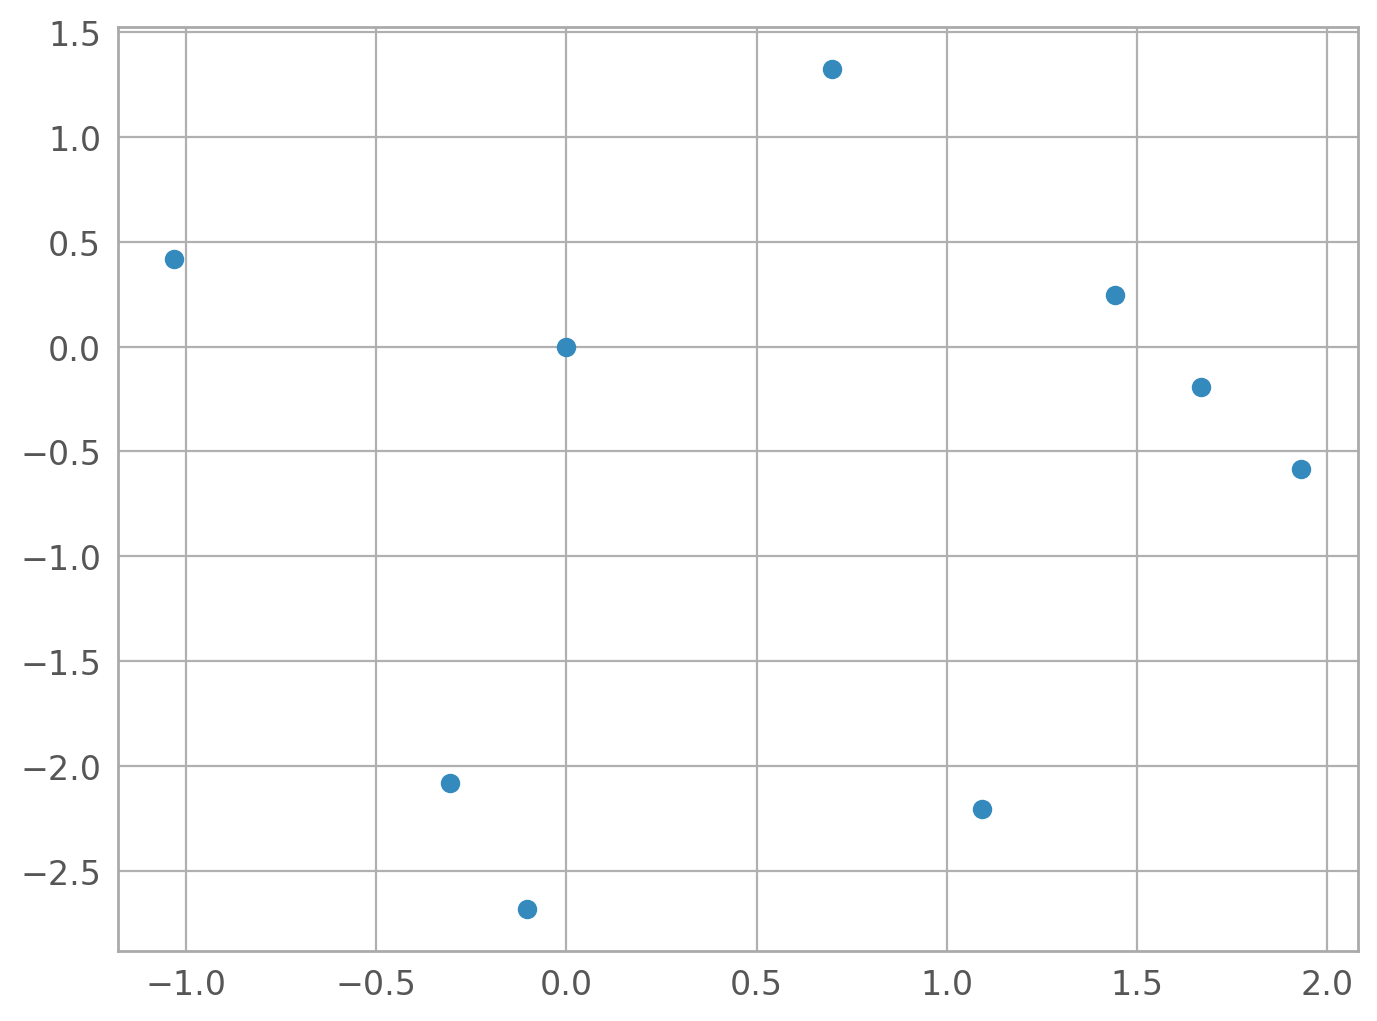

In [110]:

plt.scatter(dither_offsets[:, 0], dither_offsets[:, 1])

In [39]:
asdf_wcs.input_frame

<Frame2D(name="detector", unit=(Unit("pix"), Unit("pix")), axes_names=('x', 'y'), axes_order=(0, 1))>

In [40]:
asdf_wcs.output_frame

<CelestialFrame(name="world", unit=(Unit("deg"), Unit("deg")), axes_names=('lon', 'lat'), axes_order=(0, 1), reference_frame=<ICRS Frame>)>

In [43]:
asdf_wcs.forward_transform

<CompoundModel(offset_0=0.025, offset_1=0.164, offset_2=1., offset_3=1., offset_4=-1024.5, offset_5=-1024.5, c0_0_7=0., c1_0_7=0.063, c2_0_7=-0., c3_0_7=0., c4_0_7=0., c5_0_7=-0., c0_1_7=0., c0_2_7=0., c0_3_7=0., c0_4_7=0., c0_5_7=-0., c1_1_7=-0., c1_2_7=0., c1_3_7=-0., c1_4_7=0., c2_1_7=0., c2_2_7=0., c2_3_7=-0., c3_1_7=-0., c3_2_7=0., c4_1_7=0., c0_0_8=0., c1_0_8=0., c2_0_8=0., c3_0_8=0., c4_0_8=0., c5_0_8=-0., c0_1_8=0.063, c0_2_8=-0., c0_3_8=0., c0_4_8=-0., c0_5_8=0., c1_1_8=-0., c1_2_8=0., c1_3_8=-0., c1_4_8=-0., c2_1_8=0., c2_2_8=0., c2_3_8=0., c3_1_8=0., c3_2_8=-0., c4_1_8=0., c0_0_10=0., c1_0_10=-1., c0_1_10=0.001, c0_0_11=0., c1_0_11=0.001, c0_1_11=1., offset_12=-89.387, offset_13=-491.352, factor_14=1., factor_15=1., offset_16=0.009, offset_17=0.048, factor_18=0., factor_19=0., angles_21=[  -0.025,    0.136,  284.914,  -20.871, -231.649])>

In [377]:
hdu = fits.open('/quasar/yichenliu/proper-dither/docs/dither_image_stage2/1.fits')
# import gwcs
# gwcs.wcs.WCS(hdu[8].header)
# del hdu[8]
hdu.info()
model = ImageModel('/quasar/yichenliu/proper-dither/docs/dither_image_stage2/1.fits')
# dir(model.meta)

asdfdu = hdu[8]
asdfdu

Filename: /quasar/yichenliu/proper-dither/docs/dither_image_stage2/1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     357   ()      
  1  SCI           1 ImageHDU       112   (79, 79)   float64   
  2  ERR           1 ImageHDU        12   (79, 79)   int32 (rescales to uint32)   
  3  DQ            1 ImageHDU        11   (79, 79)   float32   
  4  AREA          1 ImageHDU         9   (79, 79)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (79, 79)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (79, 79)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (79, 79)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [25319B]   


TypeError: 'BinTableHDU' object is not subscriptable

In [437]:
print(af.write_to.__doc__)


        Write the ASDF file to the given file-like object.

        `write_to` does not change the underlying file descriptor in
        the `asdf.AsdfFile` object, but merely copies the content to a new
        file.

        Parameters
        ----------
        fd : string or file-like object
            May be a string path to a file, or a Python file-like
            object.  If a string path, the file is automatically
            closed after writing.  If not a string path, it is the
            caller's responsibility to close the object.

        all_array_storage : string, optional
            If provided, override the array storage type of all blocks
            in the file immediately before writing.  Must be one of:

            - ``internal``: The default.  The array data will be
              stored in a binary block in the same ASDF file.

            - ``external``: Store the data in a binary block in a
              separate ASDF file.

            - ``inline``: Store

In [ ]:
from gwcs.wcs import WCS
from astropy.modeling.models import Shift
import asdf
import io
from asdf import generic_io
from astropy.io import fits

# Open the FITS file
hdu = fits.open('/quasar/yichenliu/proper-dither/docs/dither_image_stage2/1.fits', mode='update')

# # Ensure you pass the HDU directly as the file handle
# generic_file = generic_io.get_file('/quasar/yichenliu/proper-dither/docs/dither_image_stage2/1.fits', mode='r')
# af = asdf.open(
#     generic_file,
#     ignore_unrecognized_tag=ignore_unrecognized_tag,
#     ignore_missing_extensions=ignore_missing_extensions,
#     **akwargs
# )









# Load the ASDF data from the BinTableHDU
generic_file = generic_io.get_file(io.BytesIO(hdu['ASDF'].data), mode="rw")
akwargs = {}
ignore_unrecognized_tag = False
ignore_missing_extensions = True
af = asdf.open(
    generic_file,
    ignore_unrecognized_tag=ignore_unrecognized_tag,
    ignore_missing_extensions=ignore_missing_extensions,
    **akwargs
)

# Define shifts
ra_shift = 5.0  # degrees
dec_shift = -3.0  # degrees

# Get the current WCS object from the ASDF file
afwcs = af['meta']['wcs']

# Modify the forward transform by adding RA/Dec shifts
new_forward_transform = afwcs.forward_transform | (Shift(ra_shift) & Shift(dec_shift))

# Create a new WCS object with the updated forward transform
new_wcs = WCS(
    forward_transform=new_forward_transform,
    input_frame=afwcs.input_frame,
    output_frame=afwcs.output_frame
)

# Update the WCS in the ASDF metadata
af['meta']['wcs'] = new_wcs


af.write_to("example")

# Serialize the updated ASDF object into a BytesIO buffer
buffer = io.BytesIO()
af.write_to(buffer)
buffer.seek(0)  # Reset buffer pointer to the start

# Replace the ASDF data in the BinTableHDU
serialized_asdf_data = buffer.read()
hdu['ASDF'].data['ASDF_DATA'][0] = serialized_asdf_data  # Assuming ASDF data is in 'ASDF_DATA'

# Save changes back to the FITS file
hdu.flush()
hdu.close()

ValueError: Resolved to relative URL

In [434]:
dir(af)

['__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_blocks',
 '_check_extensions',
 '_closed',
 '_comments',
 '_create_serialization_context',
 '_custom_schema',
 '_extension_manager',
 '_external_asdf_by_uri',
 '_fd',
 '_file_format_version',
 '_find_asdf_version_in_comments',
 '_fname',
 '_ignore_implicit_conversion',
 '_ignore_unrecognized_tag',
 '_mode',
 '_open_asdf',
 '_open_impl',
 '_parse_header_line',
 '_plugin_extensions',
 '_post_write',
 '_pre_write',
 '_process_plugin_extensions',
 '_process_user_extensions',
 '_read_comment_section',
 '

In [407]:
psfdu[1].header

KeyboardInterrupt: 

In [435]:
# Iterate over the blocks and inspect their URIs
for block in af._blocks.blocks:
    # print(f"Block Source: {block.source}")
    # print(f"Block URI: {block.uri}")
    print(len(block.data))


288
288
288
288
32
32
32
32


In [431]:
block.data

array([  0,   0,   0,   0,   0,   0,   0,   0, 242,   0, 232, 184, 255,
       255, 239,  63,   4,   2, 127,  18,   9, 221,  64,  63,   0,   0,
         0,   0,   0,   0,   0,   0], dtype=uint8)

In [ ]:
dir(block)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cached_data',
 '_data',
 '_fd',
 '_header',
 'cached_data',
 'close',
 'data',
 'data_offset',
 'header',
 'lazy_load',
 'load',
 'loaded',
 'memmap',
 'offset',
 'validate_checksum']

In [401]:
type(af['meta']['wcs'])

gwcs.wcs.WCS

In [395]:
for i in asdfdu.data[0][0]: print(i, end='\t')

35	65	83	68	70	32	49	46	48	46	48	10	35	65	83	68	70	95	83	84	65	78	68	65	82	68	32	49	46	53	46	48	10	37	89	65	77	76	32	49	46	49	10	37	84	65	71	32	33	32	116	97	103	58	115	116	115	99	105	46	101	100	117	58	97	115	100	102	47	10	45	45	45	32	33	99	111	114	101	47	97	115	100	102	45	49	46	49	46	48	10	97	115	100	102	95	108	105	98	114	97	114	121	58	32	33	99	111	114	101	47	115	111	102	116	119	97	114	101	45	49	46	48	46	48	32	123	97	117	116	104	111	114	58	32	84	104	101	32	65	83	68	70	32	68	101	118	101	108	111	112	101	114	115	44	32	104	111	109	101	112	97	103	101	58	32	39	104	116	116	112	58	47	47	103	105	116	104	117	98	46	99	111	109	47	97	115	100	102	45	102	111	114	109	97	116	47	97	115	100	102	39	44	10	32	32	110	97	109	101	58	32	97	115	100	102	44	32	118	101	114	115	105	111	110	58	32	50	46	49	52	46	52	125	10	104	105	115	116	111	114	121	58	10	32	32	101	120	116	101	110	115	105	111	110	115	58	10	32	32	45	32	33	99	111	114	101	47	101	120	116	101	110	115	105	111	110	95	109	101	116	97	100	97	116	97	45	49	46	48	

In [27]:
from jwst.datamodels import ImageModel
from gwcs.wcs import WCS
from astropy.modeling.models import Shift
import asdf
import io
from asdf import generic_io
from astropy.io import fits

dummy_fits_path = '../jw02078071001_05101_00002_nrcblong_cal.fits'

model = ImageModel(dummy_fits_path)


# Define shifts
ra_shift = 5.0  # degrees
dec_shift = -3.0  # degrees

# Get the current WCS object from the ASDF file
asdf_wcs = model.meta.wcs

# Modify the forward transform by adding RA/Dec shifts
new_forward_transform = asdf_wcs.forward_transform | (Shift(ra_shift) & Shift(dec_shift))

# Create a new WCS object with the updated forward transform
new_wcs = WCS(
    forward_transform=new_forward_transform,
    input_frame=asdf_wcs.input_frame,
    output_frame=asdf_wcs.output_frame
)

model.meta.wcs = new_wcs

model.save('test.fits')

'test.fits'

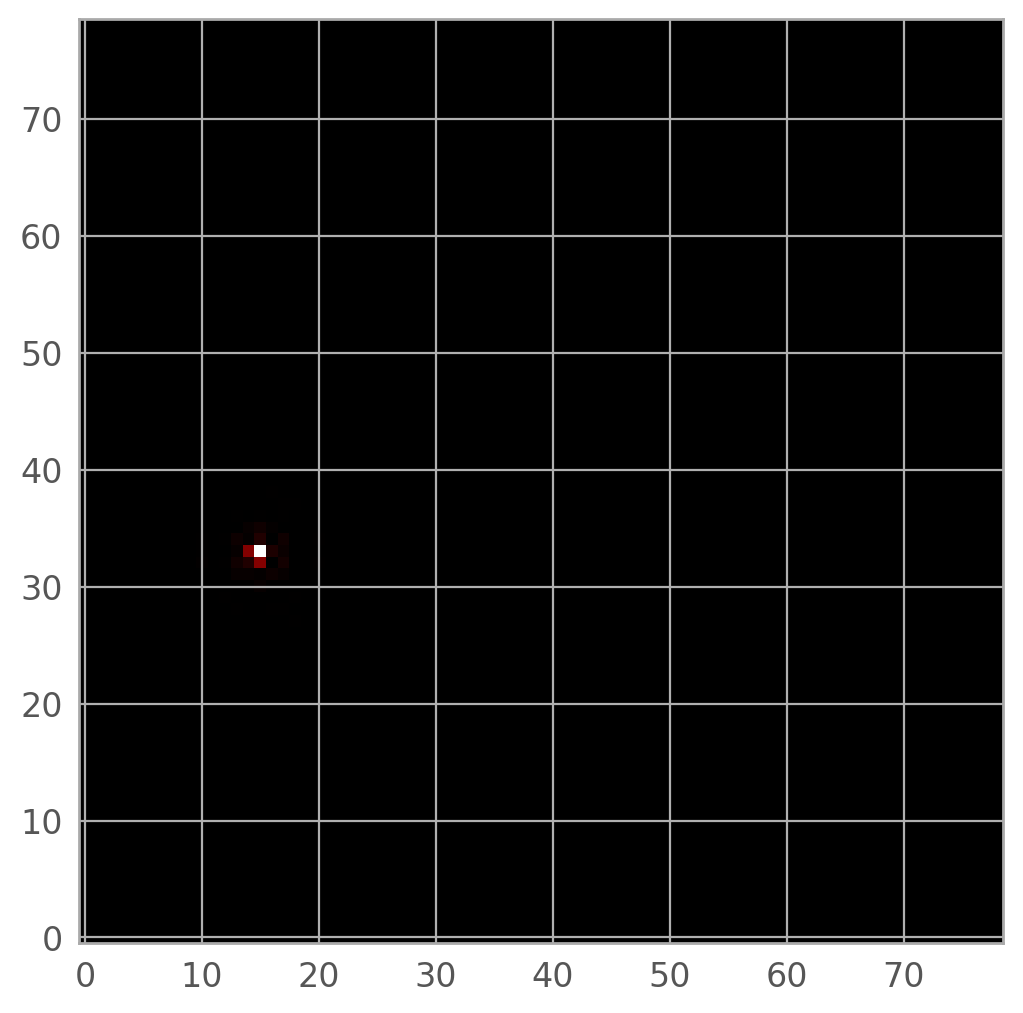

2024-11-27 17:42:32,002 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-03-03T11:37:18.007' from MJD-BEG.
Set DATE-AVG to '2023-03-03T11:41:19.585' from MJD-AVG.
Set DATE-END to '2023-03-03T11:45:21.162' from MJD-END'.
  warnings.warn(

2024-11-27 17:42:32,004 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   138.334660 from OBSGEO-[XYZ].
Set OBSGEO-B to    19.735397 from OBSGEO-[XYZ].
Set OBSGEO-H to 1405100547.135 from OBSGEO-[XYZ]'.
  warnings.warn(

2024-11-27 17:42:32,008 - stpipe.ResampleStep - INFO - ResampleStep instance created.
2024-11-27 17:42:32,015 - stpipe - INFO - Driz parameter kernel: square
2024-11-27 17:42:32,016 - stpipe - INFO - Driz parameter pixfrac: 1.0
2024-11-27 17:42:32,018 - stpipe - INFO - Driz parameter f

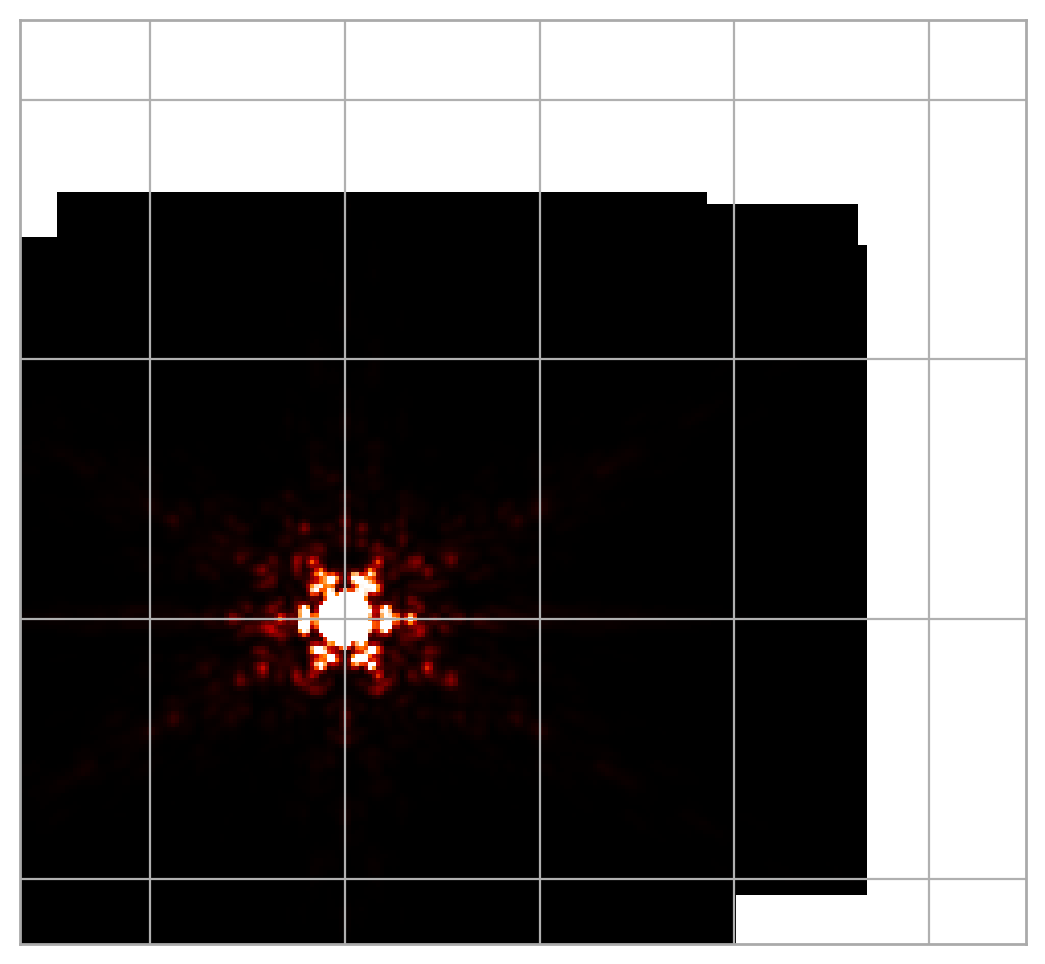

In [673]:
from jwst.resample.resample import ResampleData
from jwst.resample import ResampleStep
from jwst.datamodels import ModelContainer, ModelLibrary
import astropy

# dither_image_dir = 'dither_image'
dither_image_dir = 'dither_image_stage2'
# Load the 9 input models (as a ModelContainer or list of data models)
input_files = [os.path.join(dither_image_dir, filename) 
               for filename in os.listdir(dither_image_dir)]
# input_files = ['image1_with_wcs.fits']
# input_files = ['dither_image_stage2/0.fits']
# imput_files = cutout_paths
input_models = ModelLibrary(input_files)

# # Initialize ResampleData with desired settings
# resampler = ResampleData(
#     input_models=input_models,
#     # output='/quasar/yichenliu/proper-dither/docs/drizzled_output.fits',
#     # single=False,  # Combine all inputs into one output
#     # pixfrac=0.8,  # Fraction of pixel area to use in drizzling
#     # kernel='square',  # Kernel for drizzling
#     # fillval='NAN',  # Value to fill in empty regions
#     # wht_type='ivm',  # Type of weight image
#     allowed_memory=None, 
#     # pixel_scale = 0.063
# )

# # Perform resampling and save the result
# result = resampler.do_drizzle(input_models)

# Initialize ResampleData with desired settings
test_wcs = astropy.wcs.WCS(hdu[1].header)
resampler = ResampleStep(pixel_scale=app/2, rotation=0, crpix=(79, 79), crval=(0, 0))#pixel_scale_ratio=0.5
# resampler = ResampleStep(output_wcs = first_wcs)

# Perform resampling and save the result
result = resampler.process(input_models)

# plt.imshow(result.data[:200, :200], vmax=0.001)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=result.meta.wcs)
ax.imshow(result.data, vmax=0.001)

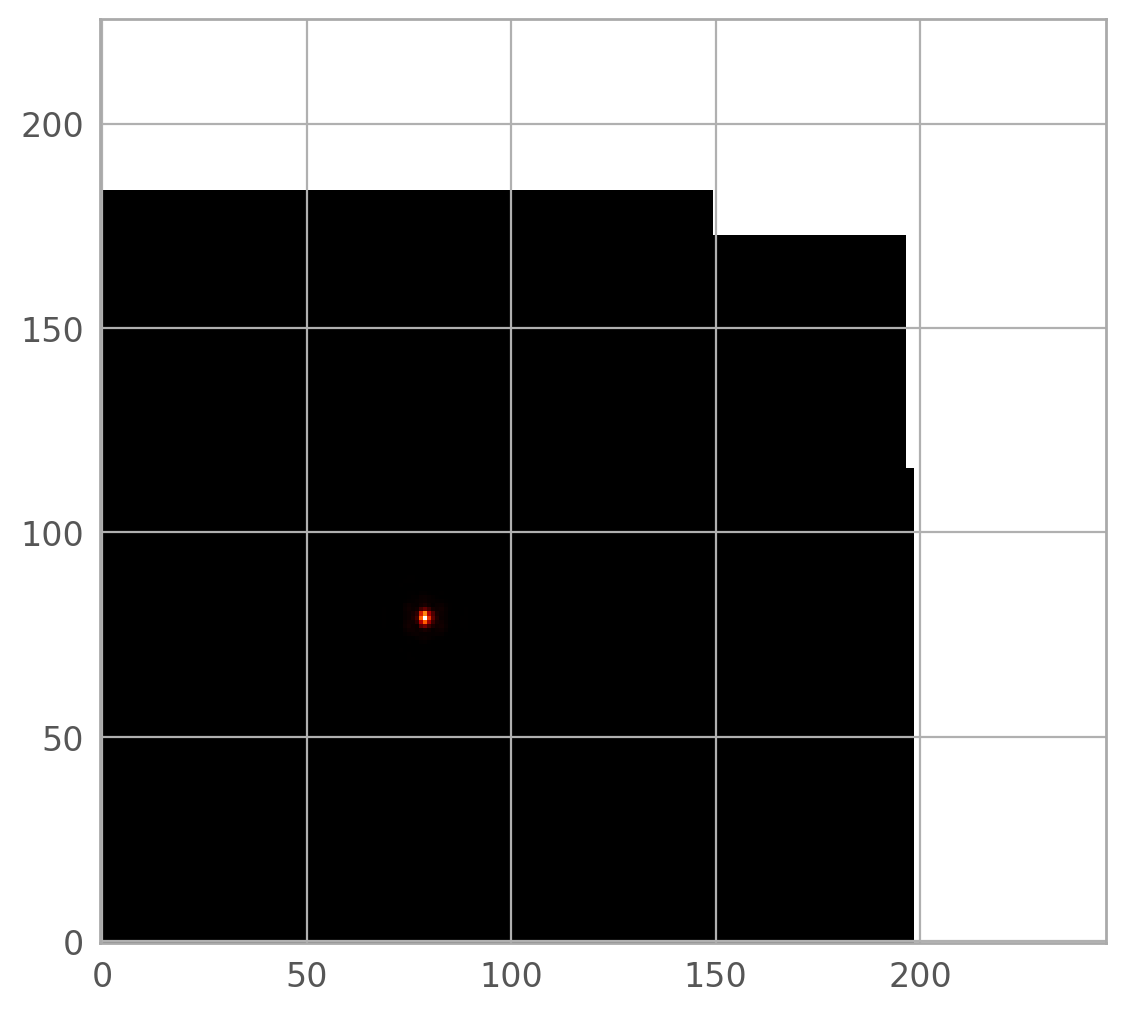

In [638]:
plt.imshow(result.data)

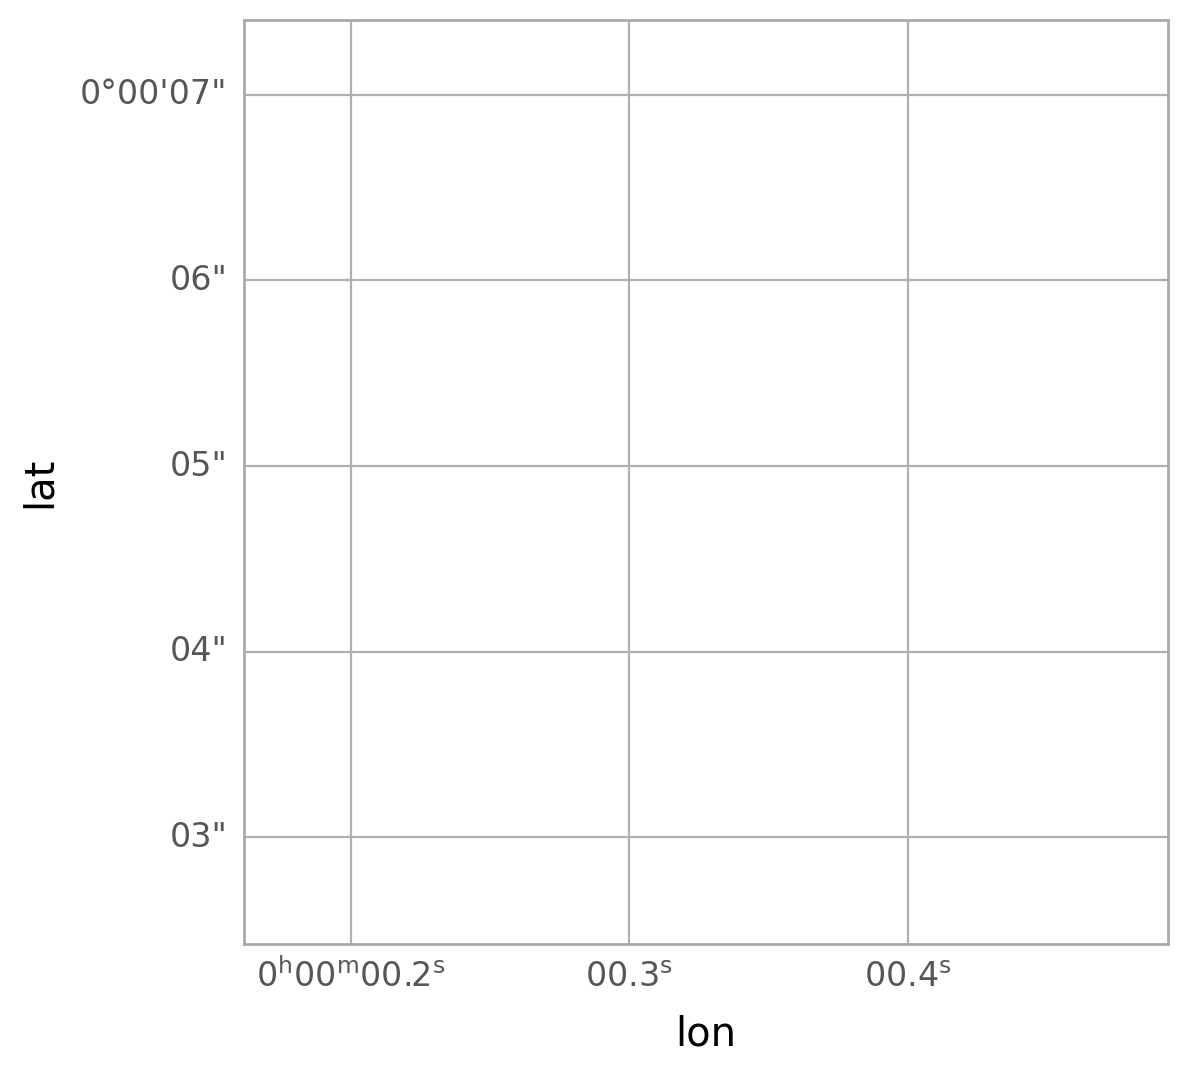

In [634]:

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection=first_wcs)
ax.imshow(result.data[:79,:79])

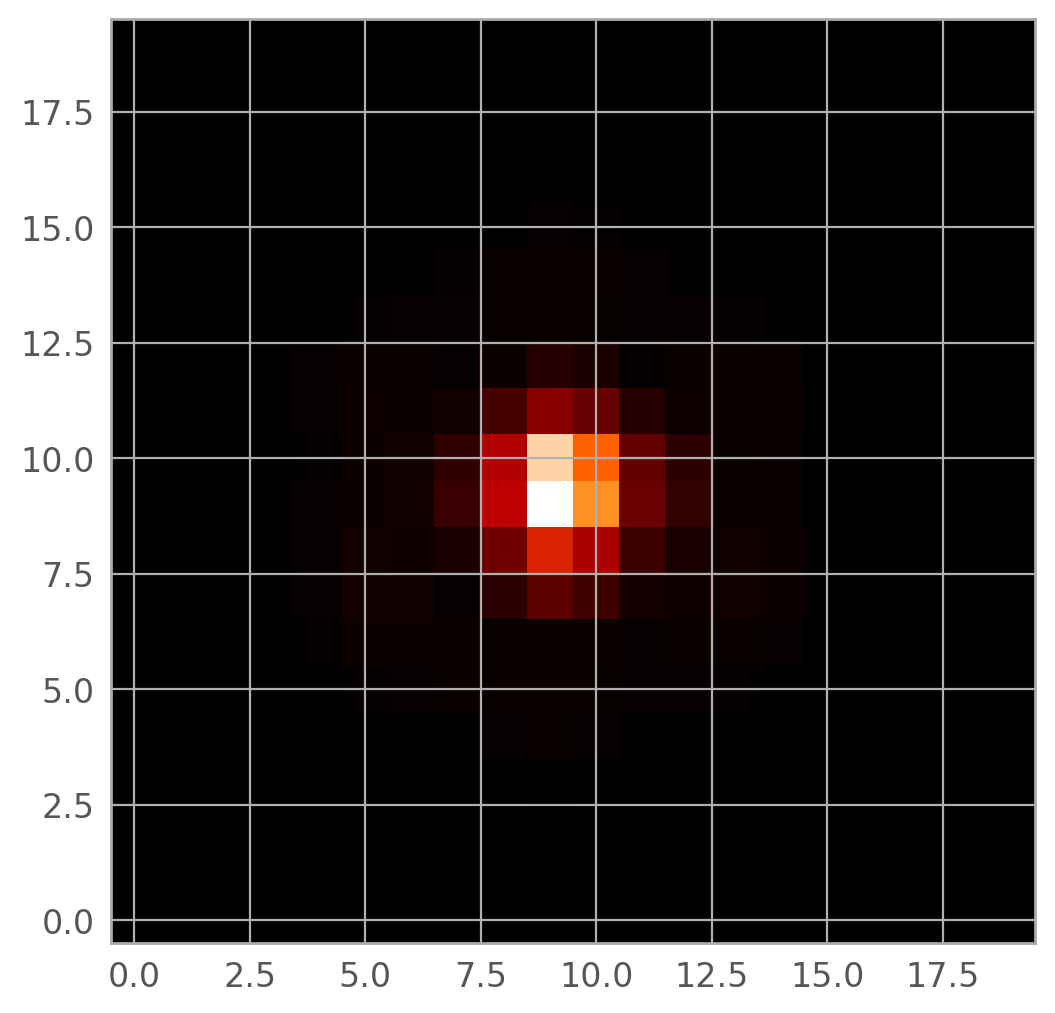

In [663]:
plt.imshow(result.data[70:90, 70:90])

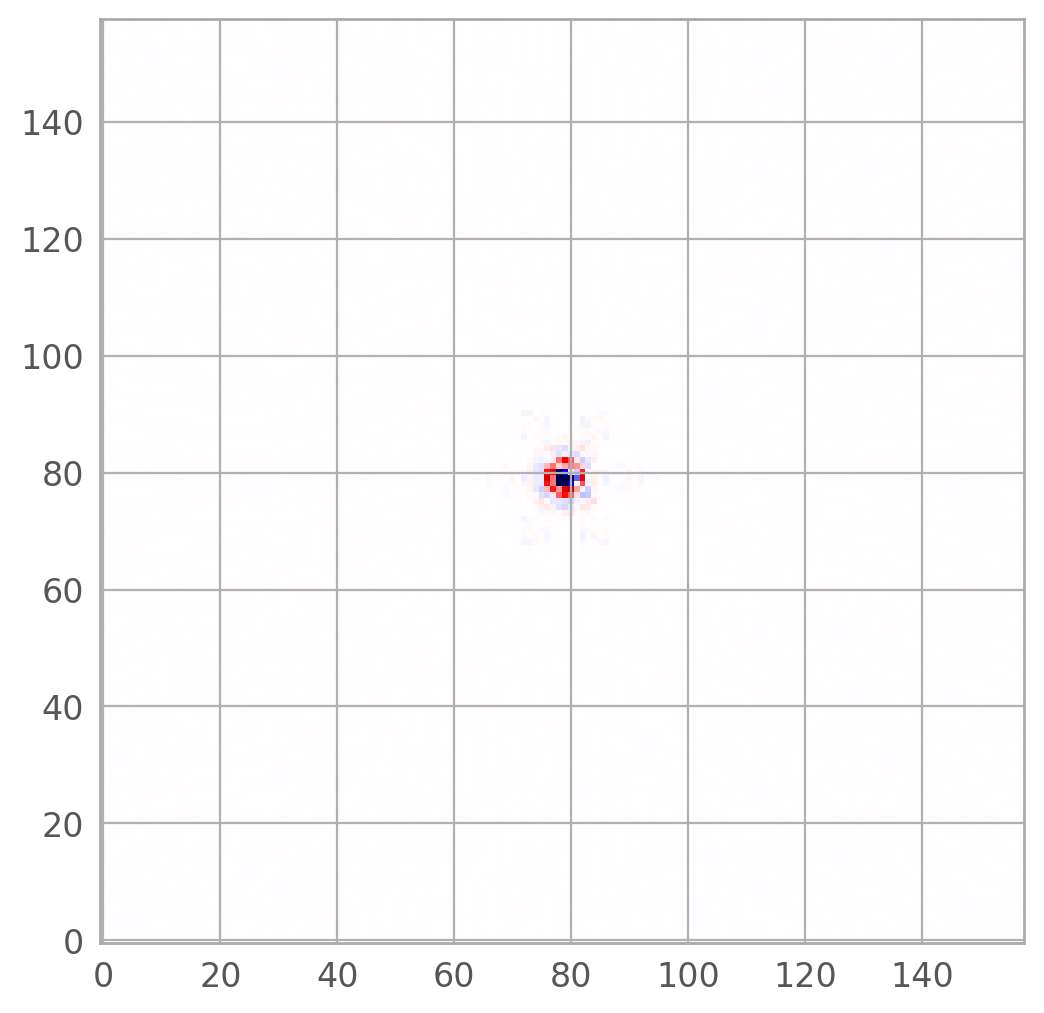

In [674]:
x = 150
y = 0
s = -6
vmax = 0.01
# x = 154
# y = 0
# s = -10
# vmax = 0.01
res = result.data[x:x+50, y:y+50]/4 - oversampled_data[50:100, 50-s:100-s]
# res = result.data[x:x+50, y:y+50]/4 - drizzled_image[50:100, 50-s:100-s]

res = result.data[:158, :158]/4 - oversampled_data
plt.imshow(res, cmap='seismic', vmin=-vmax, vmax=vmax)

In [675]:
np.max(np.abs(res))

0.01743030389567697

In [376]:
# app 0.030
np.max(np.abs(result.data[x:x+50, y:y+50]/4 - oversampled_data[50:100, 50-s:100-s]))

0.014788217535471895

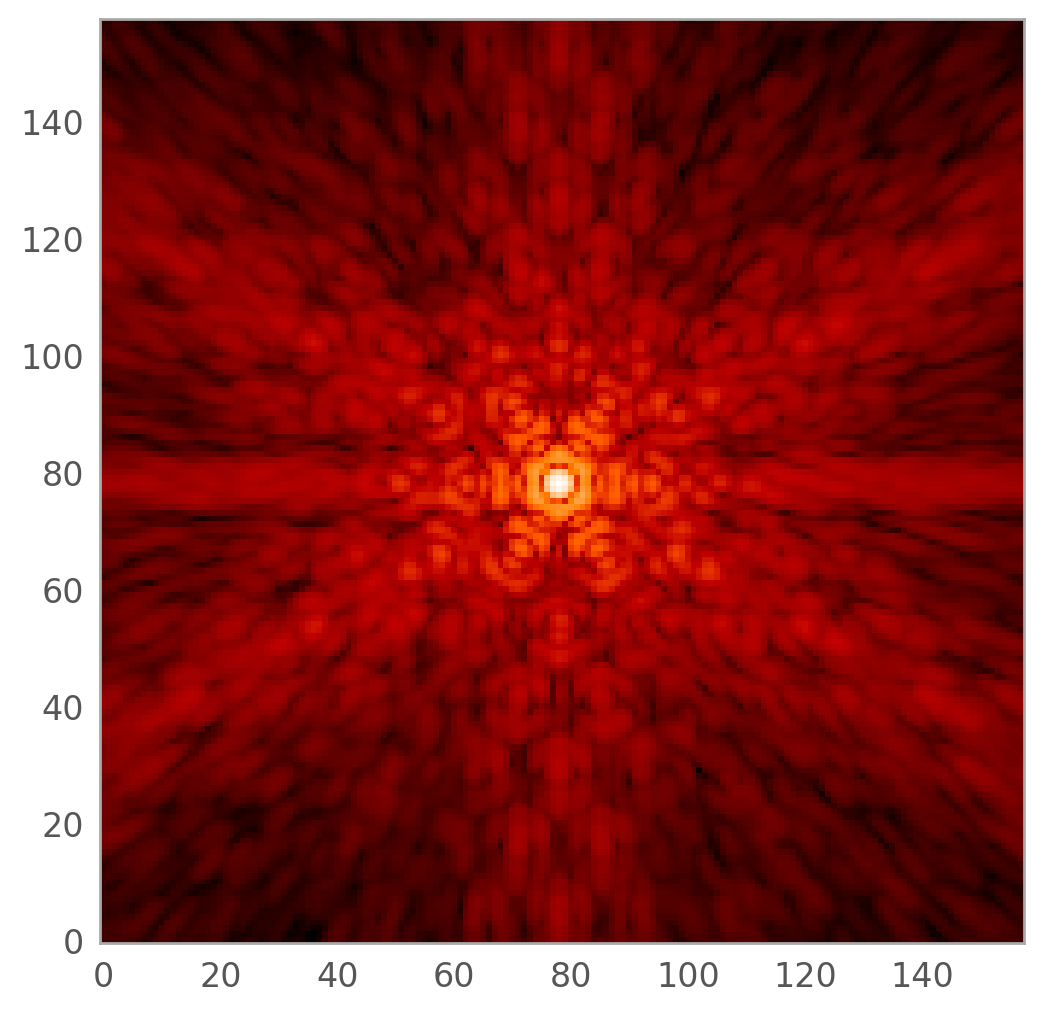

In [409]:
plt.imshow(np.log(oversampled_data))
plt.grid(False)

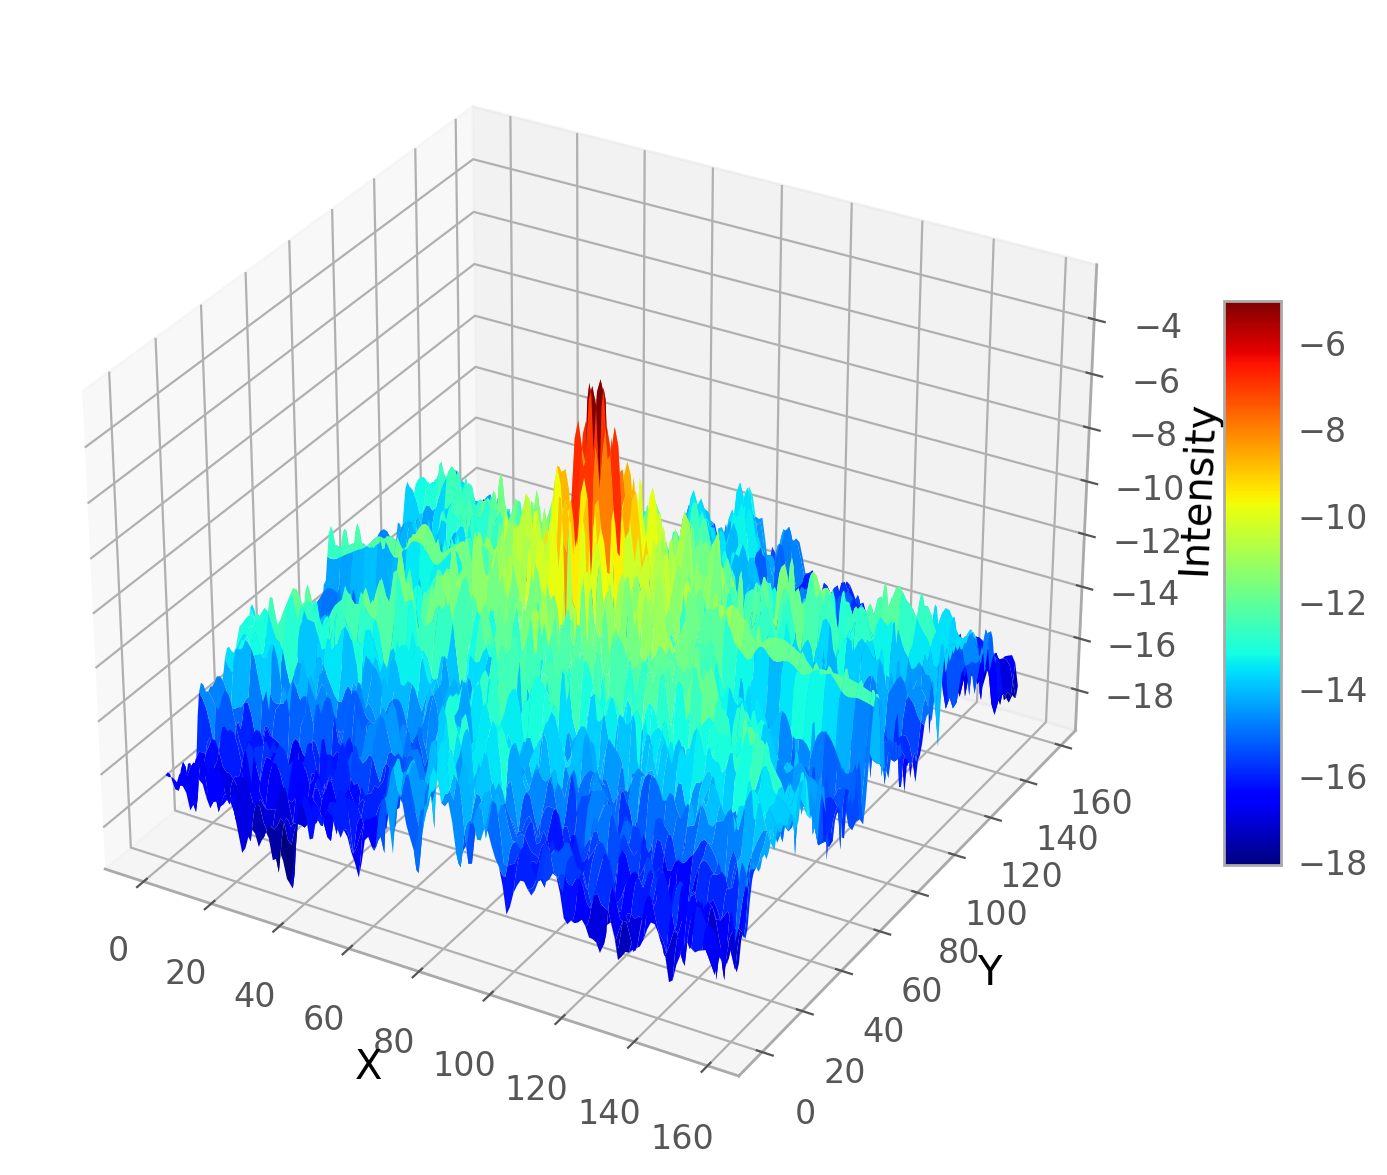

In [403]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example 2D array (replace this with your data)
array = np.log(oversampled_data)

# Generate x, y indices
x = np.arange(array.shape[1])  # Columns (x-axis)
y = np.arange(array.shape[0])  # Rows (y-axis)
x, y = np.meshgrid(x, y)       # Create grid for x, y

# Plotting the 3D surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(x, y, array, cmap='jet')  # Choose a colormap, e.g., 'viridis'

# Add a color bar to show intensity
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Intensity')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
plt.imshow(result.data[:200, :200])

In [321]:
type(result)

stdatamodels.jwst.datamodels.image.ImageModel

In [320]:
result.meta.wcs

<WCS(output_frame=world, input_frame=detector, forward_transform=Model: CompoundModel
Inputs: ('x0', 'x1')
Outputs: ('alpha_C', 'delta_C')
Model set size: 1
Expression: [0] & [1] | [2] | [3] & [4] | [5] | [6]
Components: 
    [0]: <Shift(offset=-2121.724, name='crpix1')>

    [1]: <Shift(offset=-2096.587, name='crpix2')>

    [2]: <AffineTransformation2D(matrix=[[-0.258, -0.966], [-0.966,  0.258]], translation=[0., 0.], name='pc_rotation_matrix')>

    [3]: <Scale(factor=0., name='cdelt1')>

    [4]: <Scale(factor=0., name='cdelt2')>

    [5]: <Pix2Sky_Gnomonic()>

    [6]: <RotateNative2Celestial(lon=231.649, lat=-20.871, lon_pole=180.)>
Parameters:
         offset_0           offset_1      ...        lat_6        lon_pole_6
    ------------------ ------------------ ... ------------------- ----------
    -2121.723969660365 -2096.586697768258 ... -20.870634799854145      180.0)>

In [305]:
hdu1 = fits.open(input_files[0])
# print(hdu1[0].header['VA_RA'])
# from gwcs.wcs import WCS
from astropy.wcs import WCS
WCS(hdu1[1].header)
# for i in hdu1[1].header.keys():
#     print(i)



WCS Keywords

Number of WCS axes: 2
CTYPE : '' '' 
CRVAL : 0.0 0.0 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : 1.0 1.0 
NAXIS : 79  79

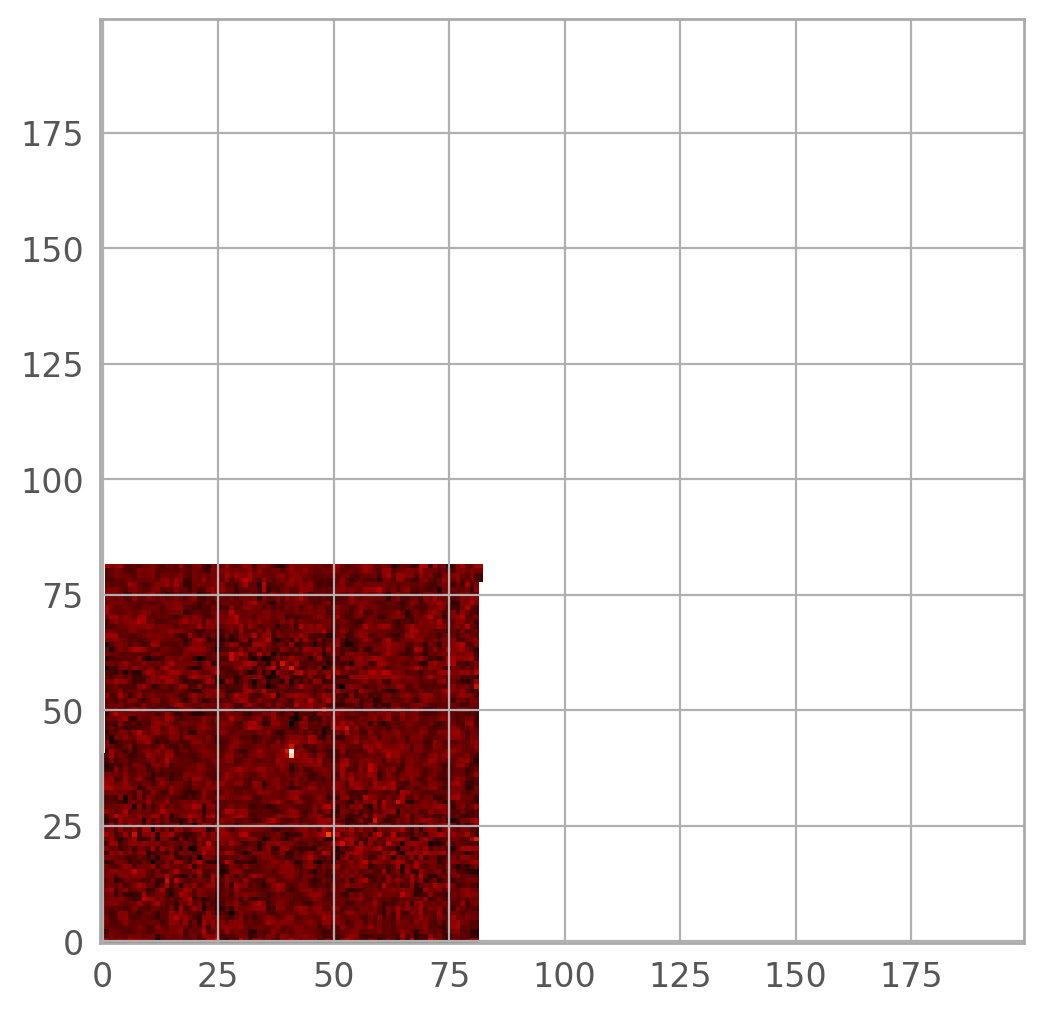

In [51]:
plt.imshow(result.data[:200, :200])

In [29]:
with fits.open('../jw02078071001_05101_00002_nrcblong_cal.fits') as hdu: 
    print(hdu.info())
    test_wcs = WCS(hdu[1].header)
    data = hdu[1].data

Filename: ../jw02078071001_05101_00002_nrcblong_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     357   ()      
  1  SCI           1 ImageHDU       112   (2048, 2048)   float32   
  2  ERR           1 ImageHDU        10   (2048, 2048)   float32   
  3  DQ            1 ImageHDU        11   (2048, 2048)   int32 (rescales to uint32)   
  4  AREA          1 ImageHDU         9   (2048, 2048)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (2048, 2048)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (2048, 2048)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (2048, 2048)   float32   
  8  ASDF          1 BinTableHDU     11   1R x 1C   [25319B]   


2024-11-21 22:17:34,948 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-03-03T11:37:18.007' from MJD-BEG.
Set DATE-AVG to '2023-03-03T11:41:19.585' from MJD-AVG.
Set DATE-END to '2023-03-03T11:45:21.162' from MJD-END'.
  warnings.warn(

2024-11-21 22:17:34,948 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   138.334660 from OBSGEO-[XYZ].
Set OBSGEO-B to    19.735397 from OBSGEO-[XYZ].
Set OBSGEO-H to 1405100547.135 from OBSGEO-[XYZ]'.
  warnings.warn(



None


In [32]:
from gwcs import wcs
from astropy.modeling.models import Shift, Pix2Sky_TAN, RotateNative2Celestial
from gwcs.coordinate_frames import CelestialFrame

# Define parameters
ra_ref = 10.0  # Reference RA in degrees
dec_ref = 20.0  # Reference Dec in degrees
pixel_scale = 0.1 / 3600  # Pixel scale in degrees/pixel

# Define transformations
shift_x = Shift(-1024)
shift_y = Shift(-1024)
scale = Pix2Sky_TAN()
rotation = RotateNative2Celestial(ra_ref, dec_ref, 180)  # Rotate to celestial

# Define output coordinate frame
celestial_frame = CelestialFrame(reference_frame='ICRS', name='world')

# Combine transformations into a pipeline
forward_transform = (shift_x & shift_y) | scale | rotation

# Create the WCS object
# gwcs_wcs = wcs.WCS(forward_transform=forward_transform, output_frame=celestial_frame)
# gwcs_wcs = wcs.WCS(forward_transform=forward_transform, output_frame='world')
gwcs_wcs = wcs.WCS(forward_transform=forward_transform, output_frame='world')

# Define bounding box
gwcs_wcs.bounding_box = None


In [24]:
from jwst.datamodels import ImageModel

# Load the image model
model = ImageModel('dither_image/0.fits')

# Attach the gwcs object
model.meta.wcs = test_wcs

# Save the updated model
model.save('image1_with_wcs.fits')

2024-11-21 22:15:27,715 - stpipe - WARNING - /quasar/yichenliu/anaconda3/envs/py312/lib/python3.12/site-packages/astropy/wcs/wcs.py:805: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to   138.334660 from OBSGEO-[XYZ].
Set OBSGEO-B to    19.735397 from OBSGEO-[XYZ].
Set OBSGEO-H to 1405100547.135 from OBSGEO-[XYZ]'.
  warnings.warn(



'image1_with_wcs.fits'

In [322]:
from jwst.resample.resample import ResampleData
from jwst.datamodels import ModelContainer, ModelLibrary

dither_image_dir = 'dither_image'
# Load the 9 input models (as a ModelContainer or list of data models)
# input_files = [os.path.join(dither_image_dir, filename) 
#                for filename in os.listdir(dither_image_dir)]
# input_files = ['image1_with_wcs.fits']
input_files = ['../jw02078071001_05101_00002_nrcblong_cal.fits']
# imput_files = cutout_paths
input_models = ModelLibrary(input_files)

# Initialize ResampleData with desired settings
resampler = ResampleData(
    input_models=input_models,
    # output='drizzled_output.fits',
    # single=False,  # Combine all inputs into one output
    single=True,  # Combine all inputs into one output
    # pixfrac=0.8,  # Fraction of pixel area to use in drizzling
    # kernel='square',  # Kernel for drizzling
    # fillval='NAN',  # Value to fill in empty regions
    # wht_type='ivm',  # Type of weight image
    allowed_memory=None
    
)

# Perform resampling and save the result
resampler.do_drizzle(input_models)


2024-11-26 11:25:37,790 - stpipe - INFO - Driz parameter kernel: square
2024-11-26 11:25:37,792 - stpipe - INFO - Driz parameter pixfrac: 1.0
2024-11-26 11:25:37,794 - stpipe - INFO - Driz parameter fillval: NAN
2024-11-26 11:25:37,795 - stpipe - INFO - Driz parameter weight_type: ivm
2024-11-26 11:25:37,798 - stpipe - INFO - Output pixel scale ratio: 1.0
2024-11-26 11:25:37,910 - stpipe - INFO - Computed output pixel scale: 0.06300668718312913 arcsec.
2024-11-26 11:25:38,151 - stpipe - INFO - 1 exposures to drizzle together
2024-11-26 11:25:40,743 - stpipe - INFO - Drizzling (2048, 2048) --> (2068, 2076)


In [74]:
from jwst.datamodels import ImageModel

# Load the model and inspect the WCS
model = ImageModel('image1_with_gwcs.fits')

# Print WCS information
print("WCS exists:", model.meta.wcs is not None)
if model.meta.wcs:
    print("Bounding Box:", getattr(model.meta.wcs, 'bounding_box', None))
else:
    print("meta.wcs is missing!")


AttributeError: No attribute 'wcs'

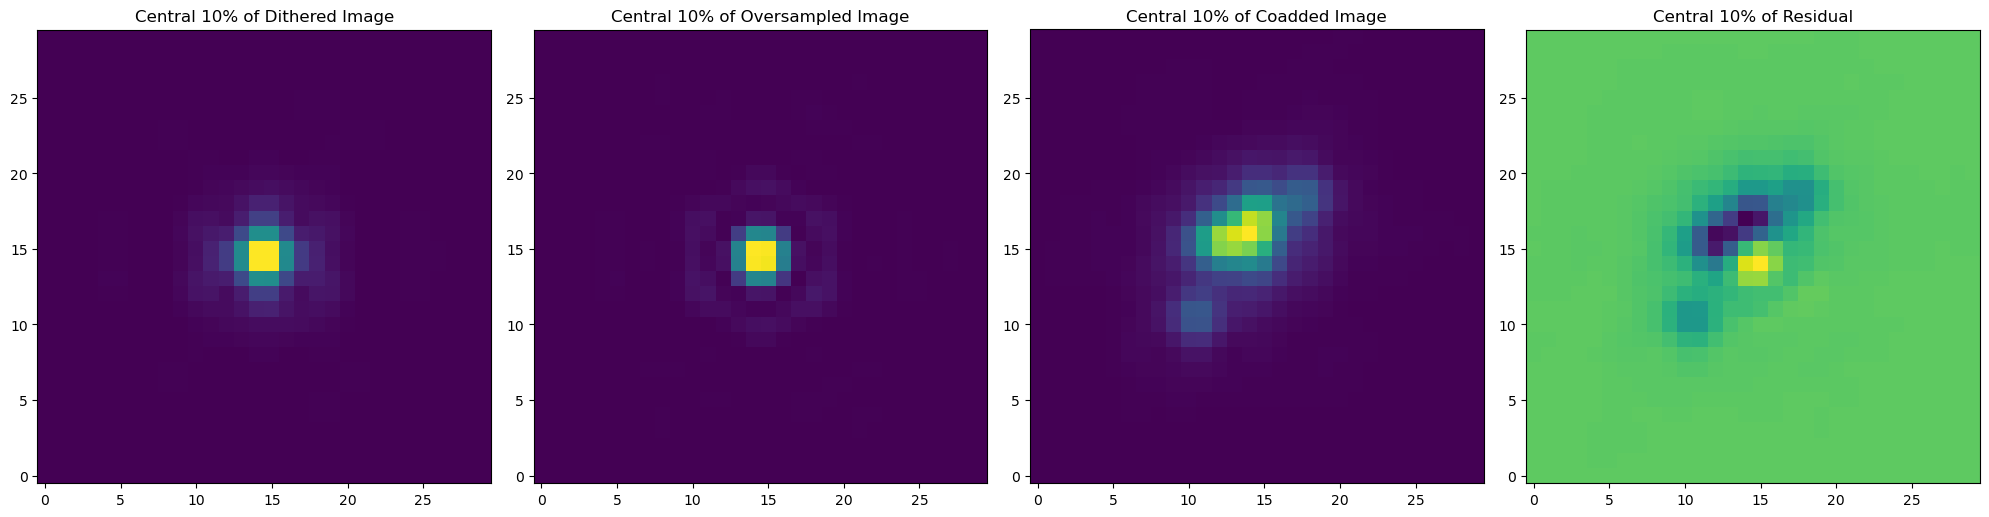

In [18]:
# Resize dithered images to match the oversampled image
resized_dither_images = [
    zoom(image, oversample_factor, order=1) for image in dither_images
]

# Create a blank array for coadding dithered images
coadded_image = np.zeros_like(oversampled_data)

# Drizzle: Align and combine the resized dithered images
for idx, (image, (dx, dy)) in enumerate(zip(resized_dither_images, dither_offsets)):
    # Shift dither images onto a common grid (simple coadd for demonstration)
    shifted_image = np.roll(np.roll(image, int(dx * 10), axis=1), int(dy * 10), axis=0)
    coadded_image += shifted_image

# Normalize the coadded image
coadded_image /= num_dithers

# Calculate the residual between the oversampled image and the coadded image
residual = oversampled_data - coadded_image

# Extract central regions
central_dither = extract_central_region(resized_dither_images[0])
central_oversampled = extract_central_region(oversampled_data)
central_coadded = extract_central_region(coadded_image)
central_residual = extract_central_region(residual)

# Simplified plotting of central regions
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plot one dithered image (central region)
axs[0].imshow(central_dither, origin='lower', cmap='viridis')
axs[0].set_title('Central 10% of Dithered Image')

# Plot oversampled image (central region)
axs[1].imshow(central_oversampled, origin='lower', cmap='viridis')
axs[1].set_title('Central 10% of Oversampled Image')

# Plot coadded image (central region)
axs[2].imshow(central_coadded, origin='lower', cmap='viridis')
axs[2].set_title('Central 10% of Coadded Image')

# Plot residual (central region)
axs[3].imshow(central_residual, origin='lower', cmap='viridis')
axs[3].set_title('Central 10% of Residual')

plt.tight_layout()
plt.show()

## Coadd using the original code written in Python way

In [70]:
import os, sys

from importlib import reload

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars
from photutils.centroids import centroid_com

from scipy.ndimage import shift

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

import testing functions from `../src/`

In [71]:
sys.path.append('..')

import dither.utils as dutils
import dither.wrapper as wrapper
import dither.updated as updated

### Prepare Data

#### Read cutout paths

Naming convention of single images:

```
           "xxx_path"          
|-----------------------------|
/path/to/the/file/filename.fits
|----------------|------------|
    "xxx_dir"      "xxx_name"  
                               
xxx_data = array([[...]])      
```


Naming convention of lists:
```
xxx_paths = [xxx_path, xxx_path, ...]
xxx_names = [xxx_name, xxx_name, ...]
xxx_atlas = [xxx_data, xxx_data, ...]
```

In [102]:
cutout_dir = '/quasar/yichenliu/cutout_f250m'
cutout_paths = []
cutout_names = os.listdir(cutout_dir)
for cutout_name in cutout_names: 
    cutout_path = os.path.join(cutout_dir, cutout_name)
    cutout_paths.append(cutout_path)
cutout_paths.sort()

cutout_paths

['/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned_cutout.fits']

#### Load images

In [73]:
orig_atlas = []
for cutout_path in cutout_paths: 
    with fits.open(cutout_path) as hdul: 
        data = hdul[1].data
        orig_atlas.append(data)

#### Get the offsets

Find the brightest pixel near the center

In [74]:
brightest_xys = []
for data in orig_atlas: 
    xy = dutils.get_brightest_pixel(data, 50, 100, 50, 100) # some random limits
    brightest_xys.append(xy)
brightest_xys = np.array(brightest_xys)

brightest_xys

array([[76, 77],
       [80, 77],
       [78, 80],
       [77, 76],
       [77, 75],
       [77, 76],
       [77, 76],
       [76, 76],
       [77, 76]])

pad the images to align its centers

In [75]:
pad = dutils.calculate_padding_radius(brightest_xys)

aligned_atlas = []
for i in range(9):
    data = orig_atlas[i]
    brightest_xy = brightest_xys[i]
    aligned_data = dutils.pad_image_with_centroid(data, pad, brightest_xy)
    aligned_atlas.append(aligned_data)

Calculate the centroids by averaging up the pixels within the central area using `centroid_com` in `Photutils`

In [76]:
cx, cy = dutils.get_pixel_center_from_array(orig_atlas[0])
r = 5

centroids = []
for i in range(9): 
    data = aligned_atlas[i]
    centroid = dutils.get_centroids_using_centroid_com(data, cx, cy, r)
    centroids.append(centroid)
centroids = np.array(centroids)
centroids -= [cx, cy]
centroids

array([[-0.038, -0.44 ],
       [-0.408, -0.225],
       [ 0.189, -0.048],
       [-0.603, -0.125],
       [-0.091,  0.093],
       [-0.453,  0.342],
       [-0.303,  0.24 ],
       [ 0.091, -0.448],
       [-0.224, -0.289]])

A more proper way is to perform a source detection using `DAOStarFinder` in `Photusils`. These two methods have on average 6% difference. 

In [77]:
centroids = []

for i in range(9): 
    data = aligned_atlas[i]
    centroid = dutils.get_centroids_using_DAOStarFinder(data, cx, cy)
    centroids.append(centroid)
centroids = np.array(centroids)
centroids -= [cx, cy]

centroids

array([[ 0.096, -0.456],
       [-0.311, -0.152],
       [ 0.395,  0.036],
       [-0.559, -0.082],
       [ 0.077,  0.149],
       [-0.315,  0.445],
       [-0.2  ,  0.352],
       [ 0.254, -0.457],
       [-0.114, -0.237]])

Visually check the center

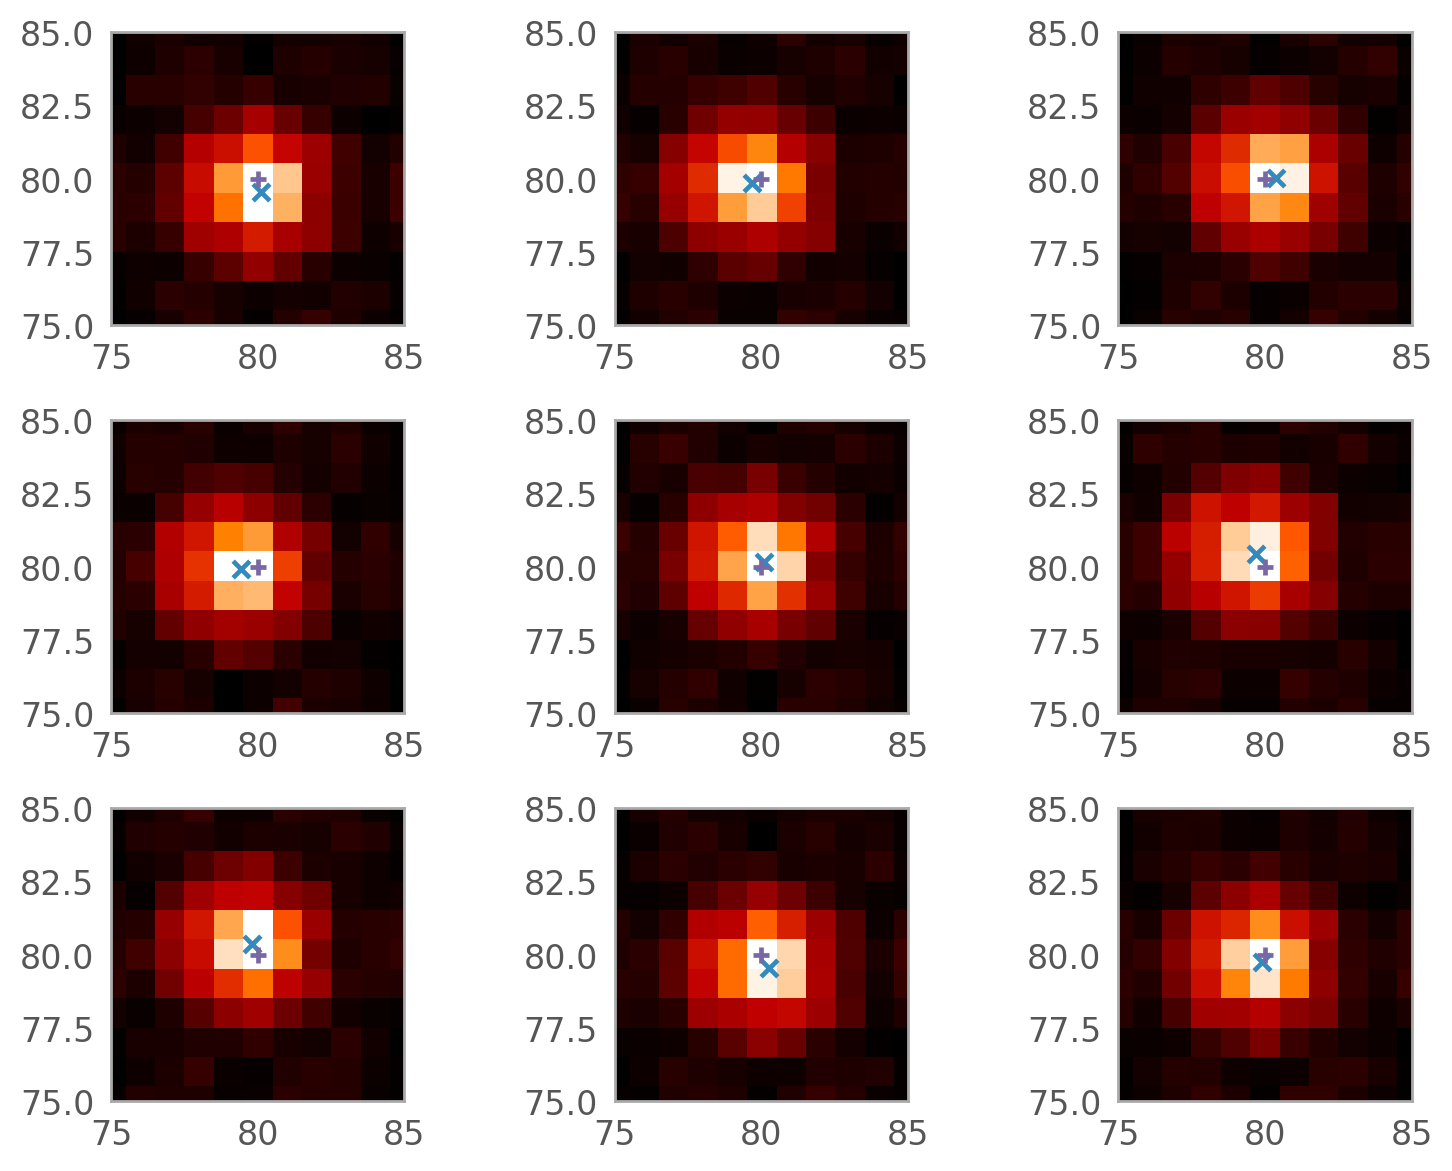

In [78]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    
    qso_center = [cx+centroids[i, 0], cx+centroids[i, 1]]
    img_center = [cx, cy]
    axs[i].imshow(np.arcsinh(data), vmin=0, vmax=5)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    axs[i].set_xlim(cx-5, cx+5)
    axs[i].set_ylim(cy-5, cy+5)
    axs[i].grid(False)
plt.tight_layout()
plt.show()

#### Mask out cosmic rays

The AGN is excluded by counting the number of connected pixels

In [79]:
masks = []

for i in range(9):
    data = aligned_atlas[i]
    mask = dutils.get_cosmic_ray_mask_without_AGN(data, kernel_size=3, sigma_threshold=40, max_connected_pixels=16)
    masks.append(mask)

Mask them out by setting them to 0 because the image is already background subtracted

In [80]:
aligned_atlas_masked = []
for i in range(9): 
    data_masked = aligned_atlas[i].copy()
    mask = masks[i]
    data_masked[mask] = 0
    aligned_atlas_masked.append(data_masked)

Visually check the mask

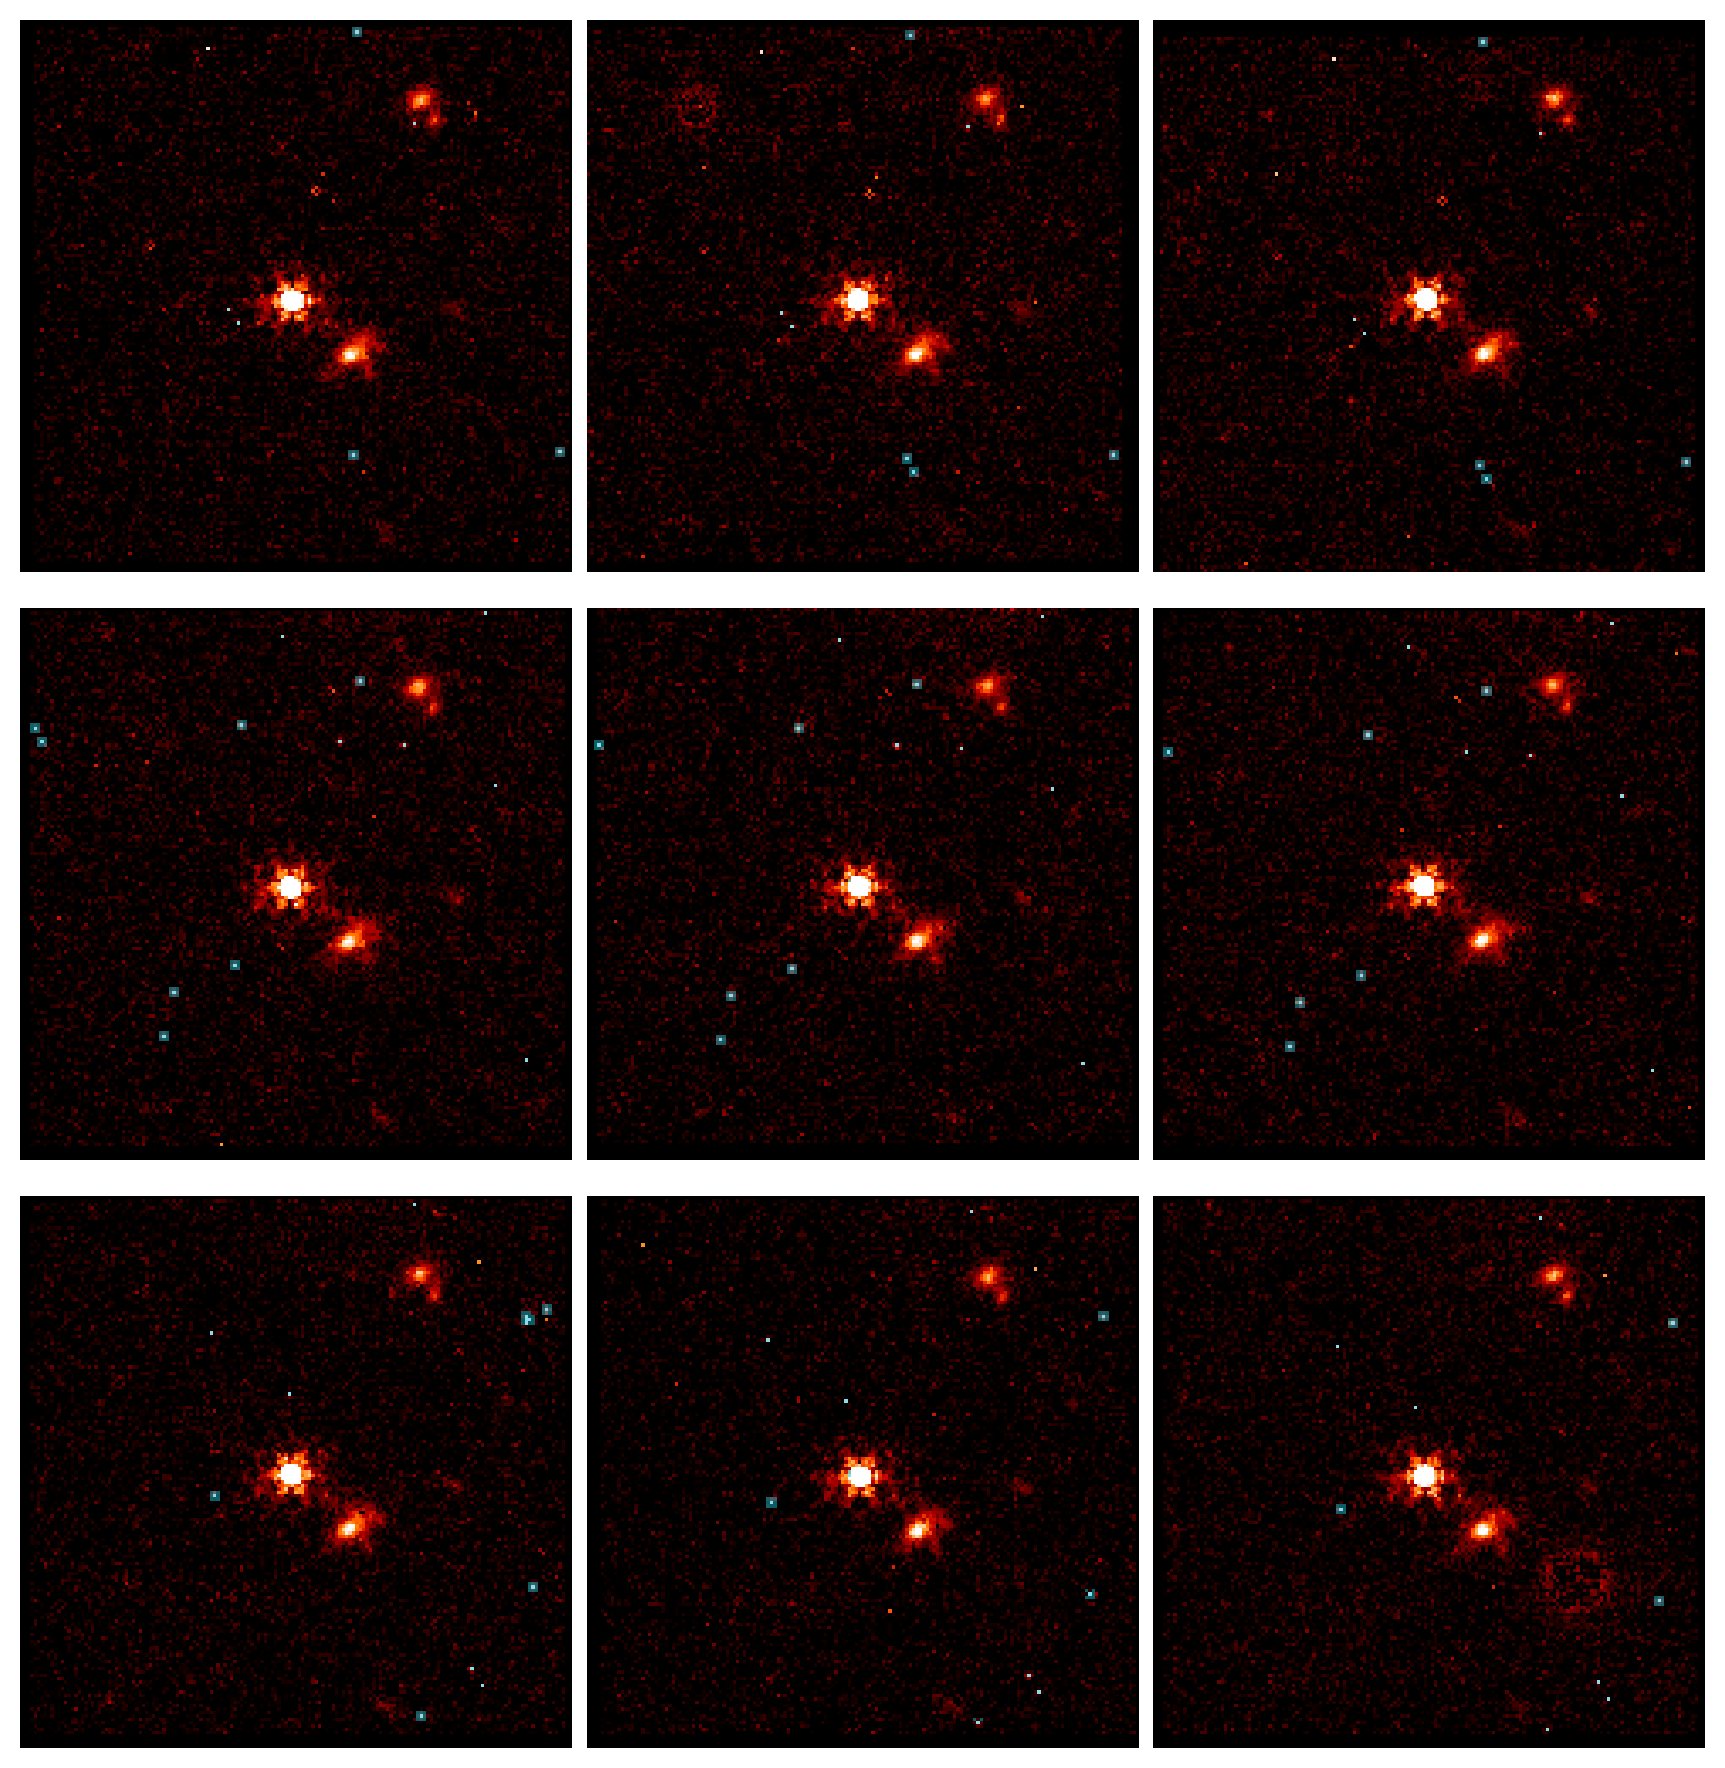

In [81]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    mask = masks[i]
    axs[i].imshow(stretch(data), vmin=0, vmax=1)
    axs[i].imshow(mask, cmap=plt.get_cmap('tab10'), alpha=mask*0.5)
    axs[i].grid(False)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Coadd Images Using Updated Code

[[-0.456  0.096  1.   ]
 [-0.152 -0.311  1.   ]
 [ 0.036  0.395  1.   ]
 [-0.082 -0.559  1.   ]
 [ 0.149  0.077  1.   ]
 [ 0.445 -0.315  1.   ]
 [ 0.352 -0.2    1.   ]
 [-0.457  0.254  1.   ]
 [-0.237 -0.114  1.   ]]


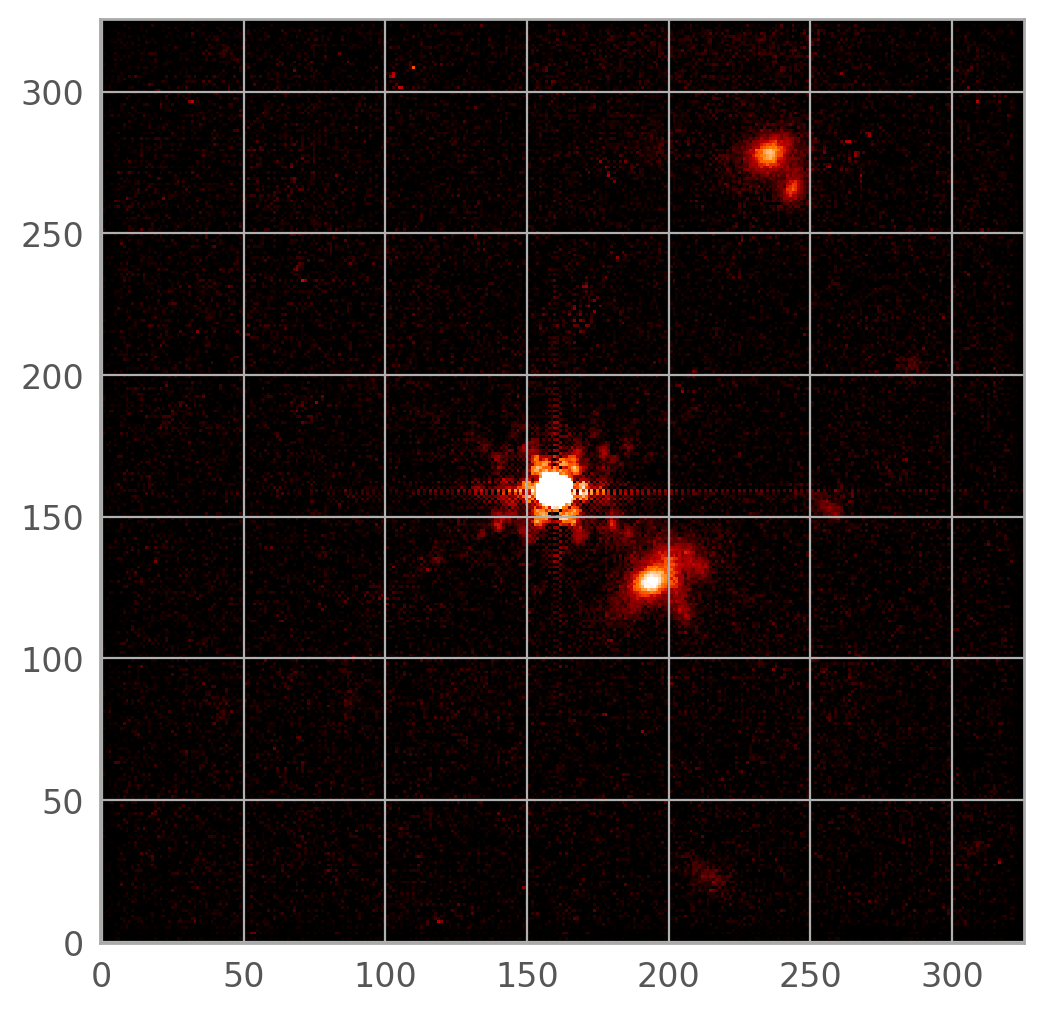

In [82]:
from dither.wrapper import NR_FREQ, NC_FREQ
NSUB = 2


used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((centroids[used_indices, 1:2], 
                     centroids[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
# offsets[0, 0] = 0
# offsets[0, 1] = 0
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = aligned_atlas_masked[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = updated.real2dfft_forward(data_large)
    n = i + 1
    Aphased = updated.phase_shift(A, offsets, n, verbose=False)
    Atotal += Aphased

f = updated.real2dfft_backward(Atotal)

nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(stretch(f[:nx_large, :ny_large]))
plt.show()

### TESTING CODE

In [47]:
# sys.path.append('/quasar/yichenliu/astro-utils')

# from autils import interactive_plot

Output()

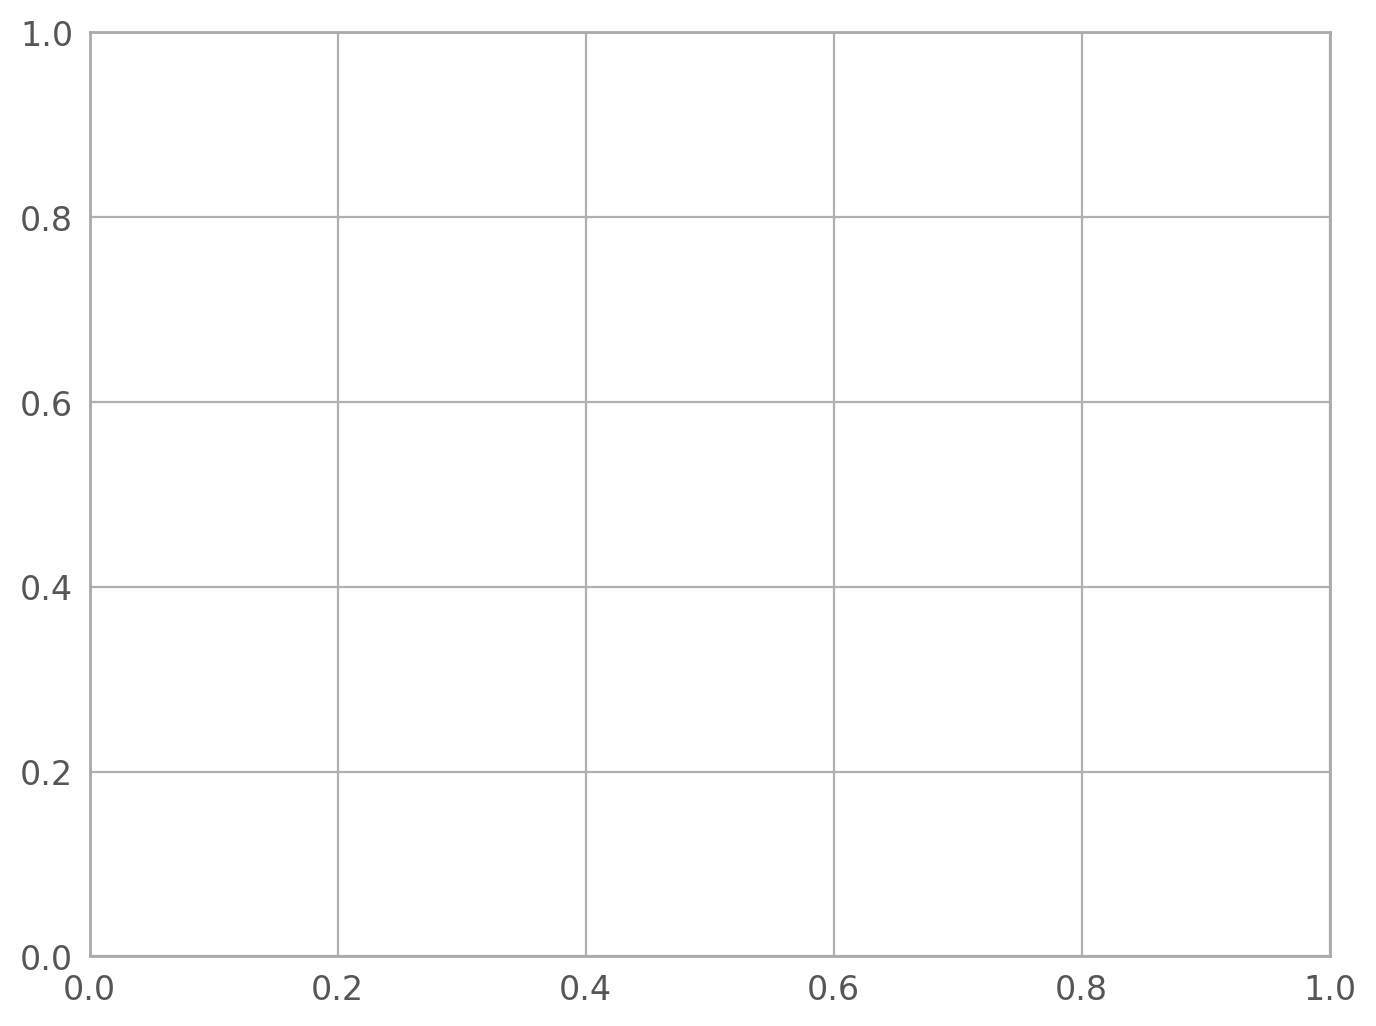

In [48]:
interactive_plot(f[:nx_large, :ny_large])

Show the transformed image and the power spectrum

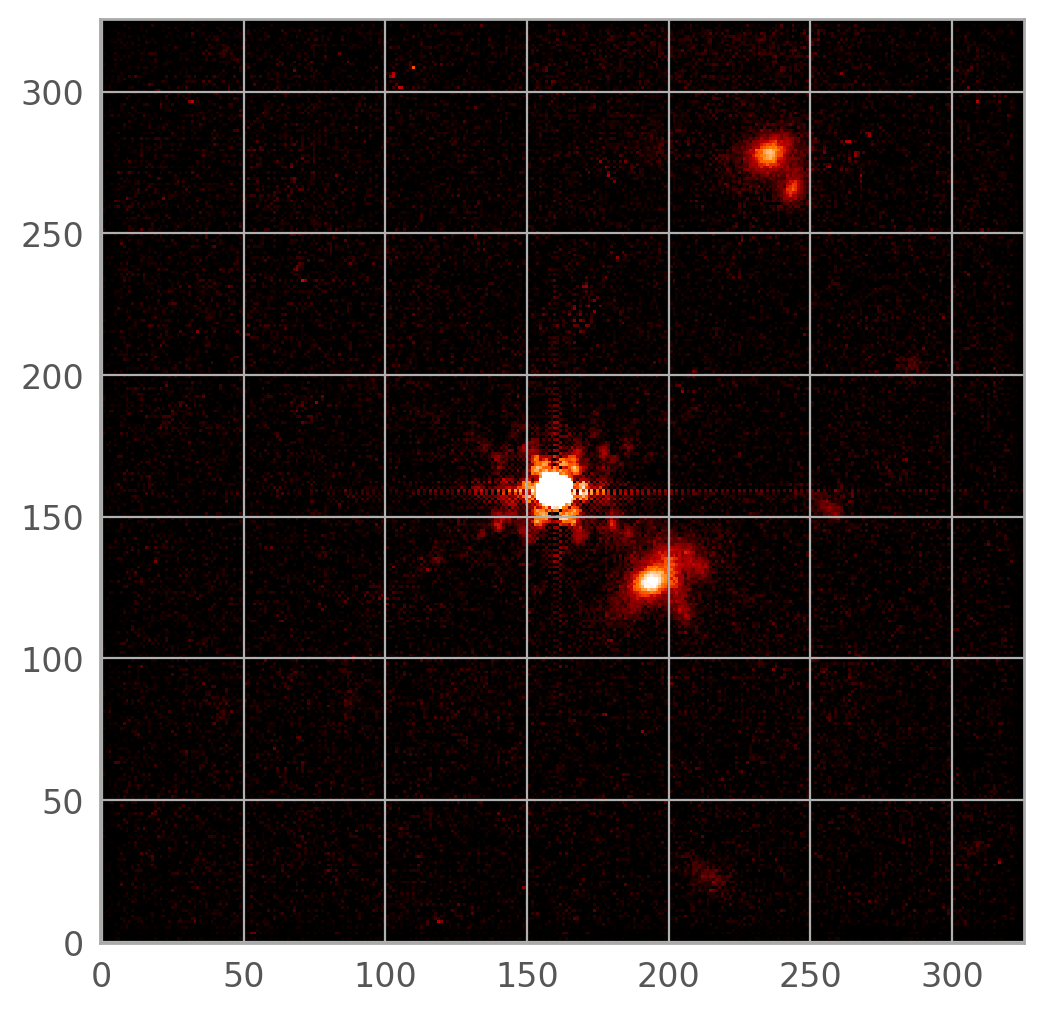

In [83]:
nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB

plt.imshow(stretch(f[:nx_large, :ny_large]))

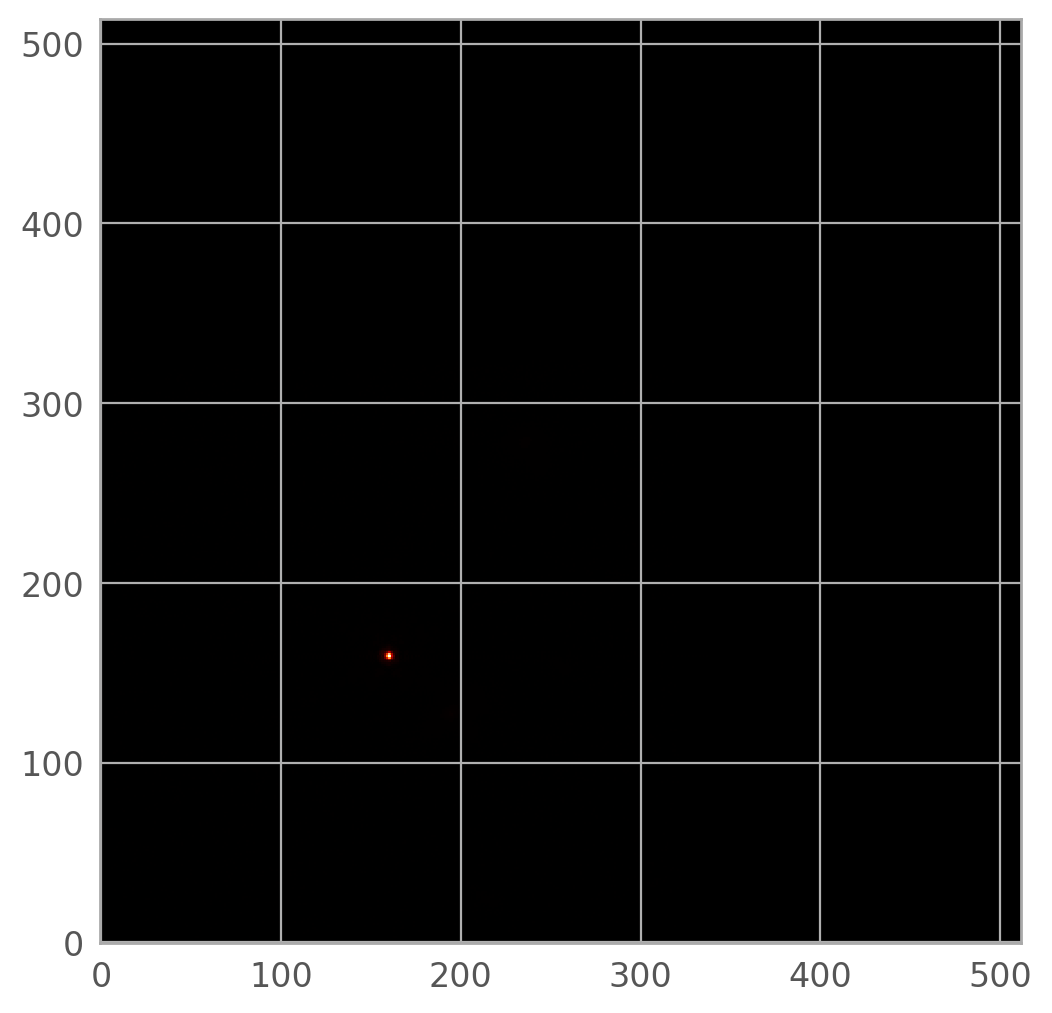

In [84]:
plt.imshow(f)

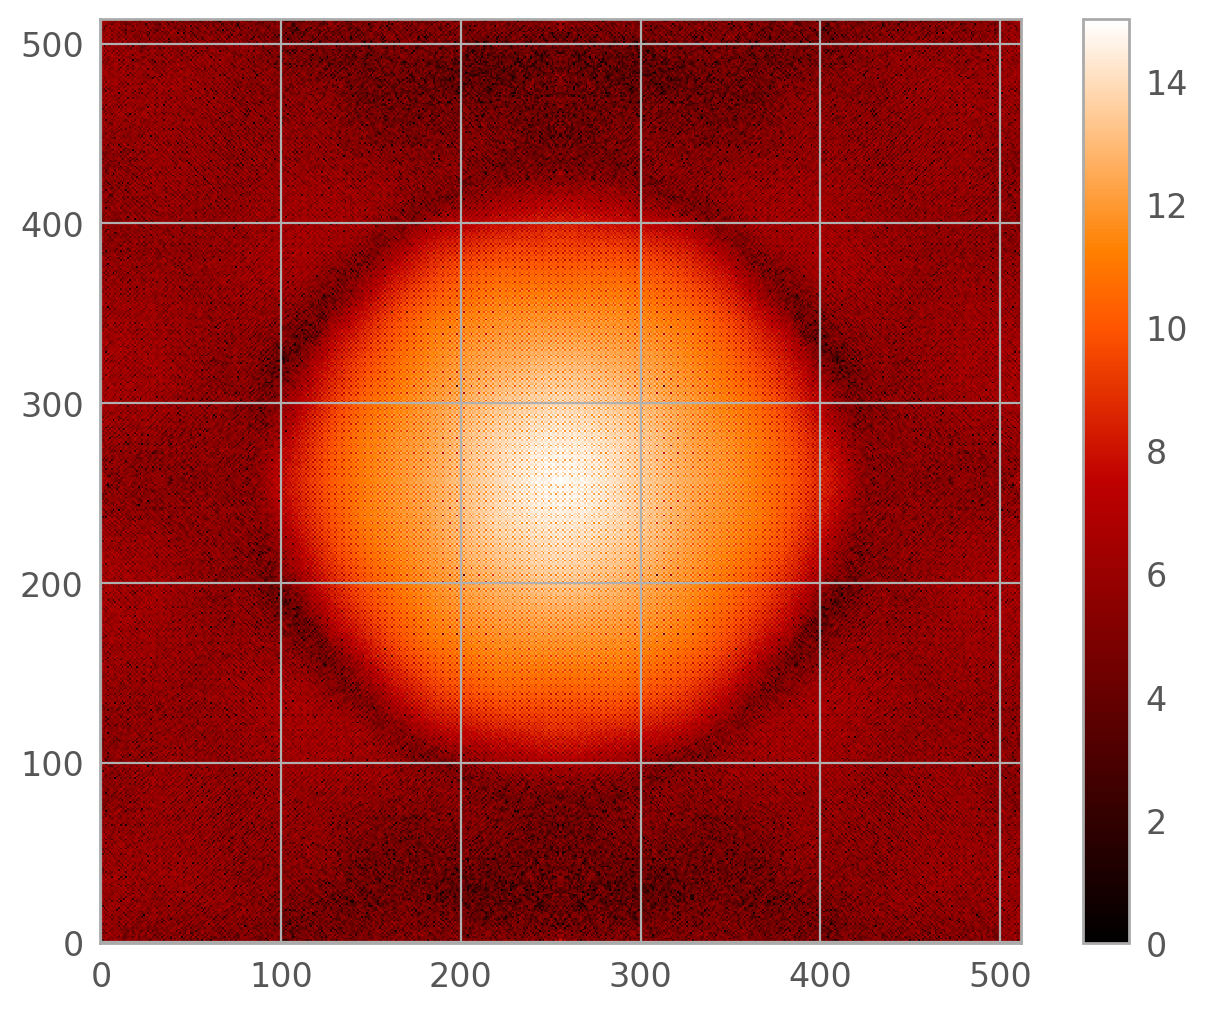

In [90]:
# pow = dutils.get_power_spectrum_from_realfft2d(Atotal)
pow = dutils.get_power_spectrum_from_realfft2d(updated.real2dfft_forward(f))
plt.imshow(np.log(pow+1), vmin=0, vmax=15)
plt.colorbar()
plt.show()

In [51]:
# TODO: apply wiener filter to eliminate spikes

  ERROR: File /quasar/yichenliu/cutout_unfold_JWST/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia_cutout.fits already exists. If you mean to replace it then use the argument "overwrite=True".


Set OBSGEO-B to   -21.931130 from OBSGEO-[XYZ].
Set OBSGEO-H to 1540023708.650 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


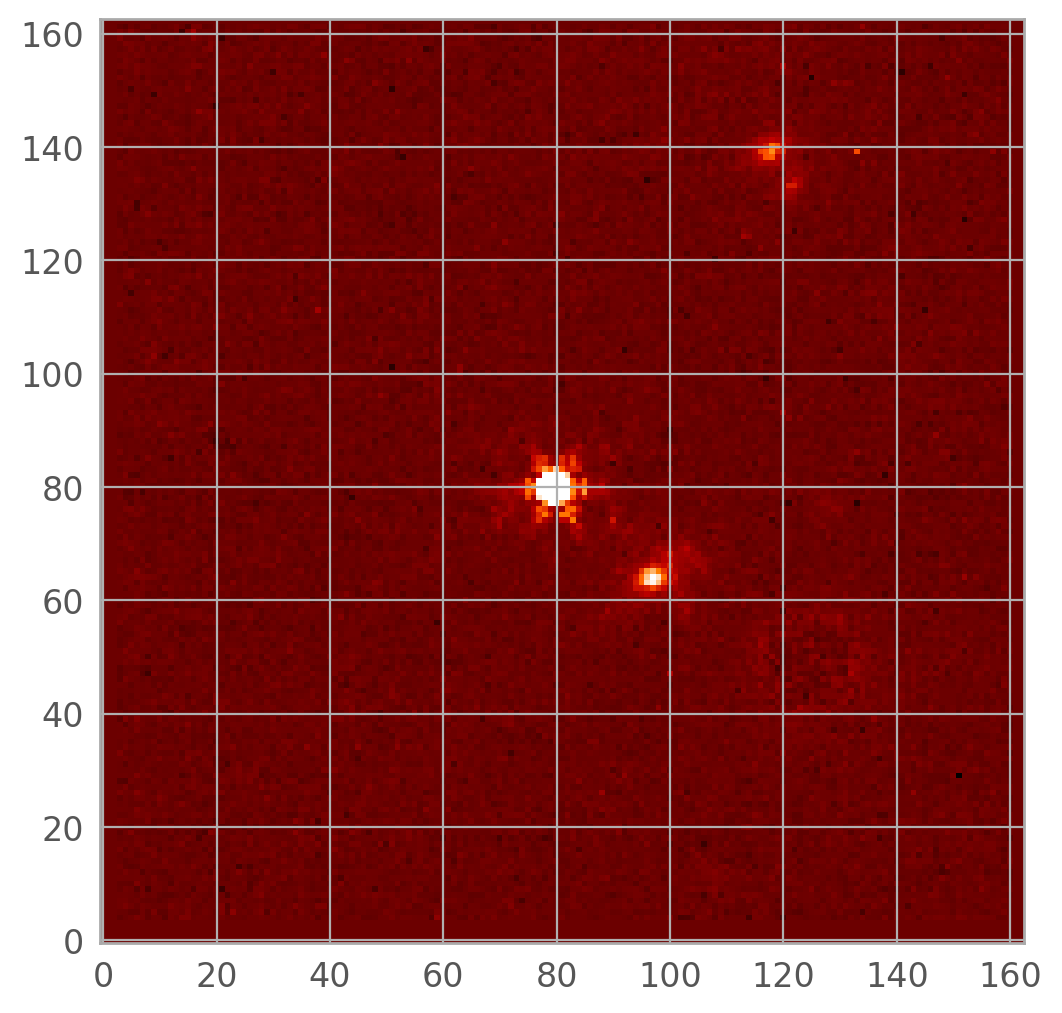

In [52]:
agn_coord = SkyCoord("J100758.26+211529.2", unit=(u.hourangle, u.deg), frame='icrs')
jwstpath = '/quasar/data/GO1764/NIRCam/redux_v01/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia.fits'
radius = 5 # arcsec
cutout_dir = '/quasar/yichenliu/cutout_unfold_JWST'
cutout_paths = []
fits_path = jwstpath
directory = os.path.dirname(fits_path)
filename = os.path.basename(fits_path)
cutout_path = os.path.join(cutout_dir, filename[:-5]+'_cutout.fits')
try: 
    dutils.create_cutout_fits(fits_path, cutout_path, agn_coord, radius)
except OSError as E: 
    print(f'  ERROR: {E}')
cutout_paths.append(cutout_path)
# break
plt.imshow(np.arcsinh(data), vmax=1)

Filename: /quasar/yichenliu/cutout_unfold_JWST/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia_cutout.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     373   ()      
  1  SCI           1 ImageHDU        81   (316, 316)   float64   
  2  ERR           1 ImageHDU        41   (316, 316)   float32   
  3  VAR_POISSON    1 ImageHDU        40   (316, 316)   float32   
  4  VAR_RNOISE    1 ImageHDU        40   (316, 316)   float32   
  5  VAR_FLAT      1 ImageHDU        40   (316, 316)   float32   
None


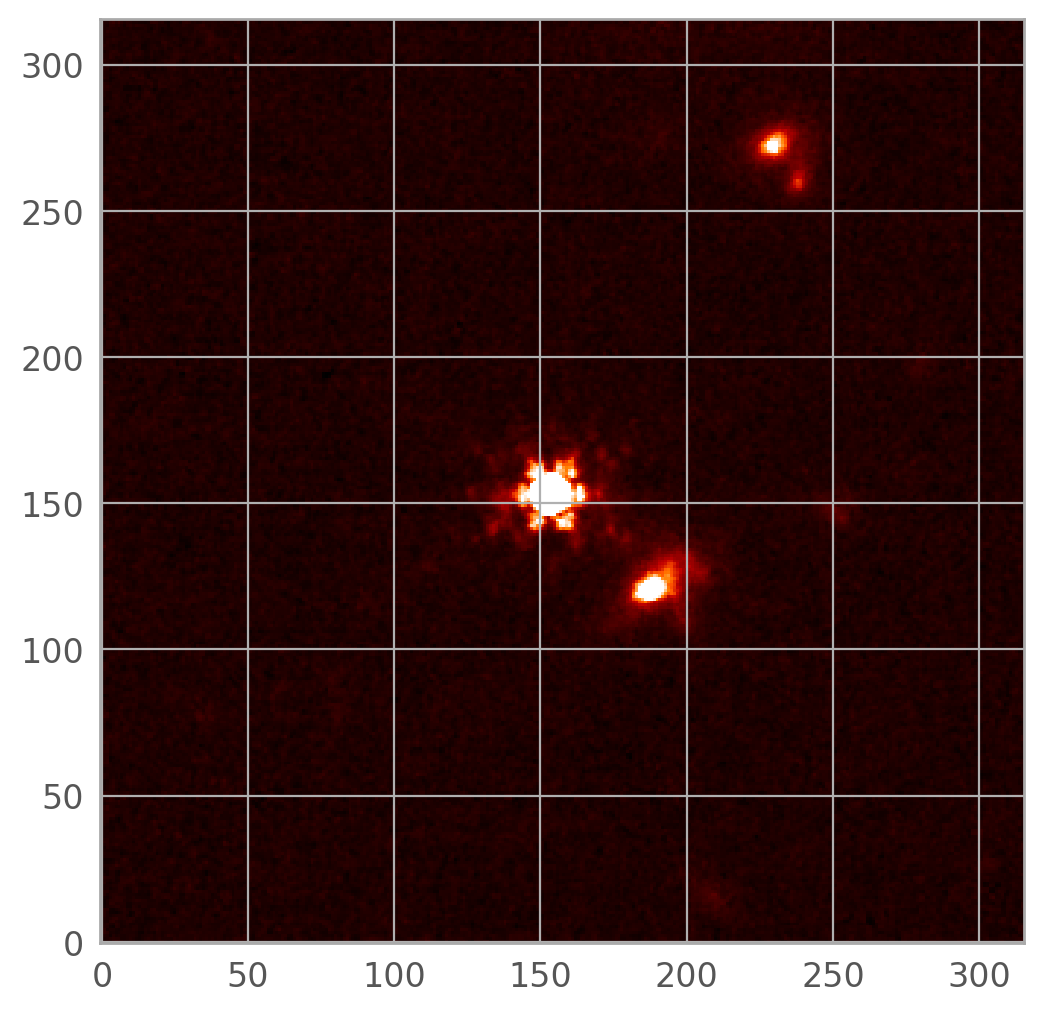

In [53]:
jwstpath = '/quasar/data/GO1764/NIRCam/redux_v01/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia.fits'
cutpath = '/quasar/yichenliu/cutout_unfold_JWST/jw01764-o001_20230518t010000_clear-f250m_i2d_bsub_gaia_cutout.fits'

with fits.open(cutpath) as hdu:
    print(hdu.info())
    cutdata = hdu['SCI'].data

plt.imshow(cutdata, vmax=0.5)

In [96]:
cutdata.shape

(316, 316)

In [98]:
NC_FREQ

514

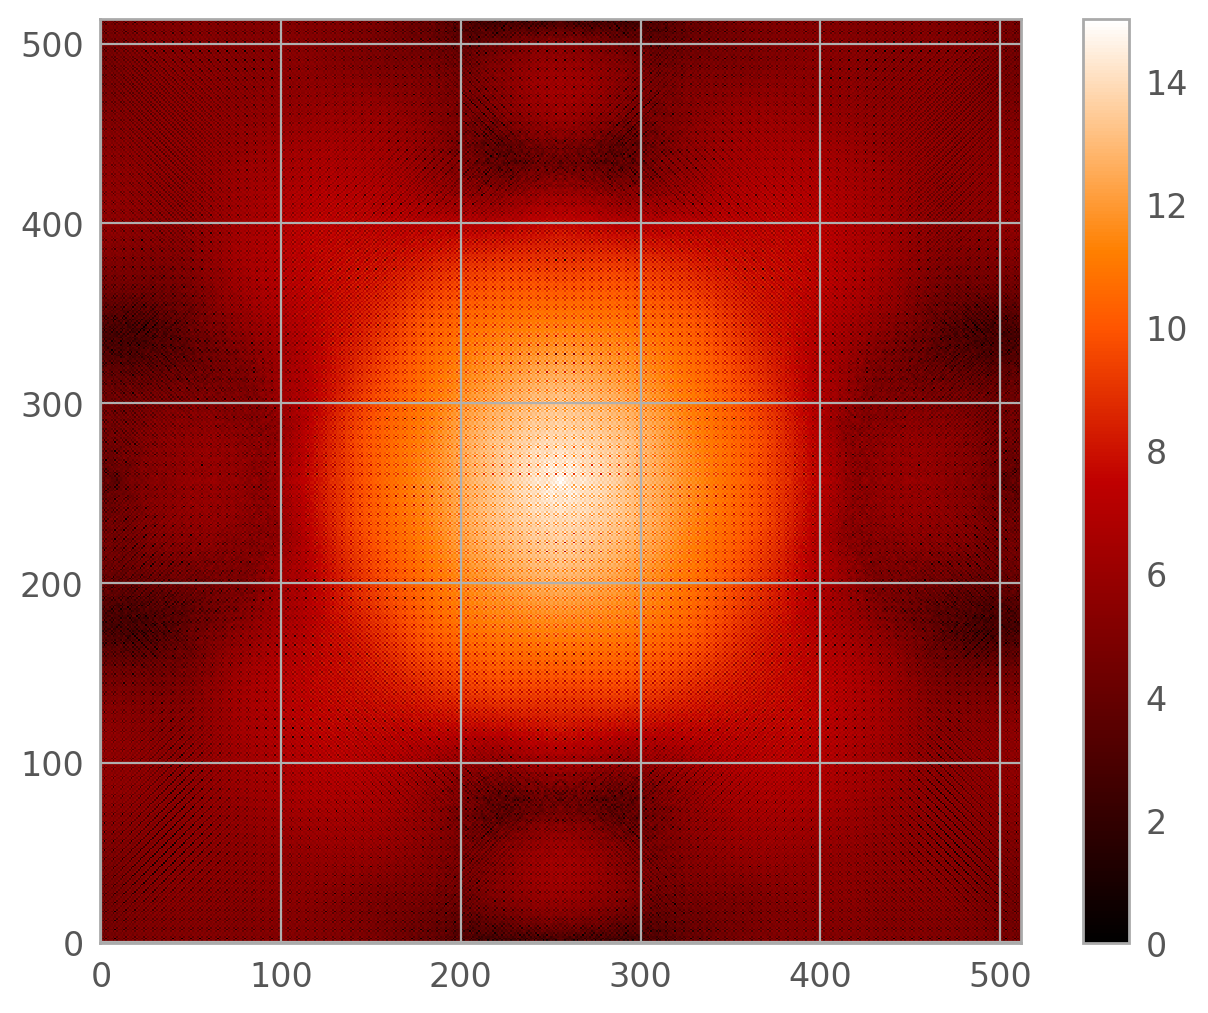

In [100]:
nx, ny = cutdata.shape
data_large[:nx, :ny] = cutdata

pow = dutils.get_power_spectrum_from_realfft2d(updated.real2dfft_forward(data_large))
plt.imshow(np.log(pow+1), vmin=0, vmax=15)
plt.colorbar()
plt.show()

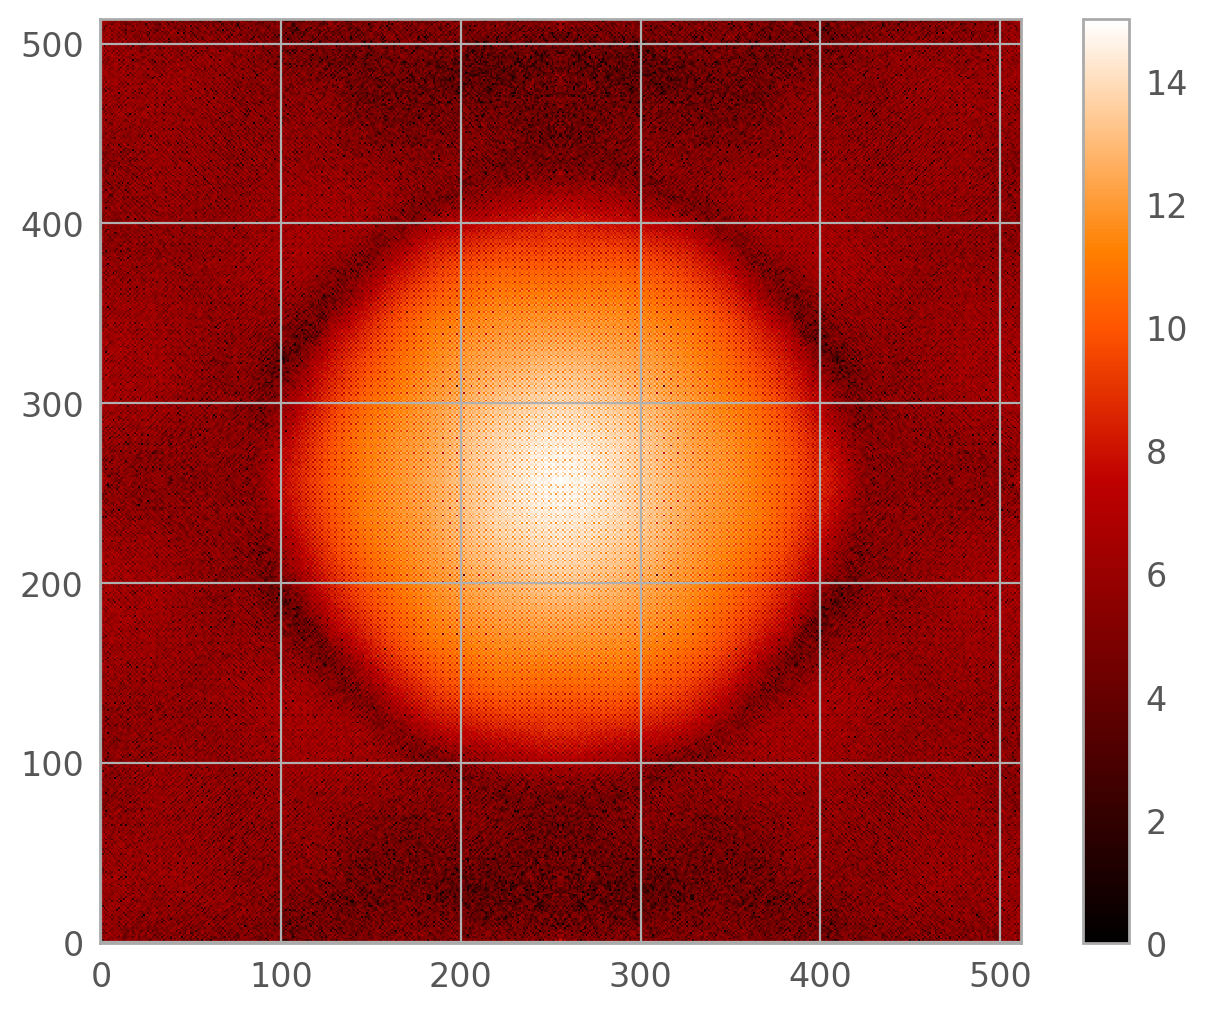

In [91]:
# pow = dutils.get_power_spectrum_from_realfft2d(Atotal)
pow = dutils.get_power_spectrum_from_realfft2d(updated.real2dfft_forward(f)) 
plt.imshow(np.log(pow+1), vmin=0, vmax=15)
plt.colorbar()
plt.show()

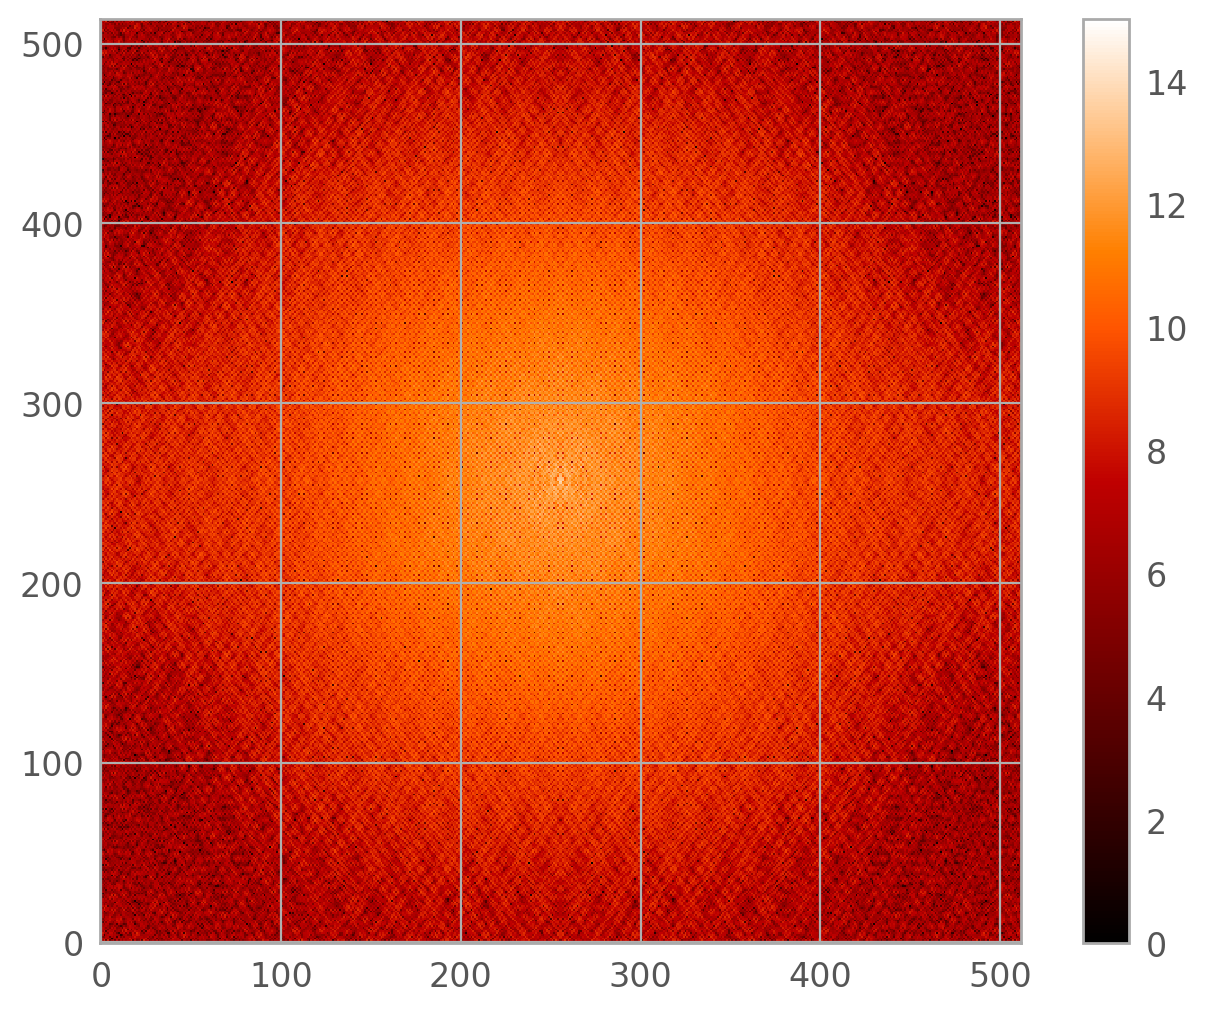

In [105]:
nx, ny = aligned_atlas[i].shape
data_large[:nx, :ny] = aligned_atlas[i]

pow = dutils.get_power_spectrum_from_realfft2d(updated.real2dfft_forward(data_large)) 
plt.imshow(np.log(pow+1), vmin=0, vmax=15)
plt.colorbar()
plt.show()

In [55]:
import numpy as np
from scipy.ndimage import gaussian_filter, convolve

# Step 1: Generate a Gaussian array
def generate_gaussian_array(size, mean, std_dev):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    gaussian_array = (1 / (2 * np.pi * std_dev**2)) * np.exp(-((x - mean)**2 + (y - mean)**2) / (2 * std_dev**2))
    return gaussian_array


def convolve_with_stride(data, kernel, stride, xoffset, yoffset):
    # Convolve the data with the kernel
    convolved = convolve(data, kernel, mode='constant', cval=0.0)
    
    # Downsample the result using the specified stride
    return convolved[xoffset::stride, yoffset::stride]



In [56]:
size = 1200
mean = 0          
std_dev = 6

gaussian_array = generate_gaussian_array(size, mean, std_dev)

kernel_size = 12
kernel = np.ones((kernel_size, kernel_size))

stride = 12 

images = []
offsets_gauss = []
for i in range(3):
    for j in range(3):
        xoffset = i*4
        yoffset = j*4
        convolved_array = convolve_with_stride(gaussian_array, kernel, stride, xoffset, yoffset)
        images.append(convolved_array)
        offsets_gauss.append([-j/3, -i/3])
offsets_gauss = np.array(offsets_gauss)

# Output the shapes of the arrays
print("Original Gaussian array shape:", gaussian_array.shape)
print("Convolved array shape:", convolved_array.shape)
offsets_gauss

Original Gaussian array shape: (1200, 1200)
Convolved array shape: (100, 100)


array([[ 0.   ,  0.   ],
       [-0.333,  0.   ],
       [-0.667,  0.   ],
       [ 0.   , -0.333],
       [-0.333, -0.333],
       [-0.667, -0.333],
       [ 0.   , -0.667],
       [-0.333, -0.667],
       [-0.667, -0.667]])

[[ 0.     0.     1.   ]
 [ 0.    -0.333  1.   ]
 [ 0.    -0.667  1.   ]
 [-0.333  0.     1.   ]
 [-0.333 -0.333  1.   ]
 [-0.333 -0.667  1.   ]
 [-0.667  0.     1.   ]
 [-0.667 -0.333  1.   ]
 [-0.667 -0.667  1.   ]]


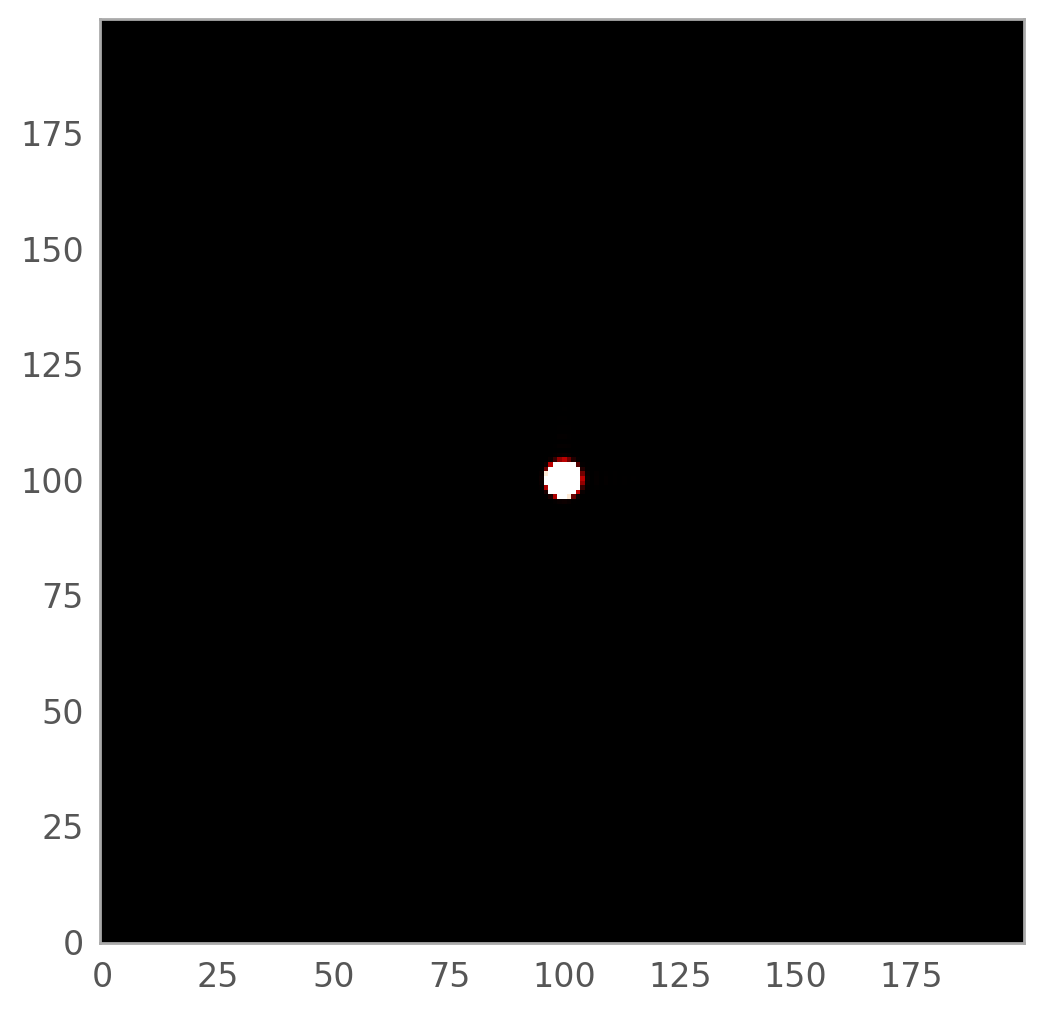

In [57]:
from dither.wrapper import NR_FREQ, NC_FREQ
NSUB = 2


used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((offsets_gauss[used_indices, 1:2], 
                     offsets_gauss[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
offsets[1, 1]+=0
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = images[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = updated.real2dfft_forward(data_large)
    n = i + 1
    Aphased = updated.phase_shift(A, offsets, n, verbose=False)
    Atotal += Aphased

f = updated.real2dfft_backward(Atotal)

nx, ny = images[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(f[:nx_large, :ny_large], vmin=0, vmax=0.001)
plt.grid(False)
plt.show()

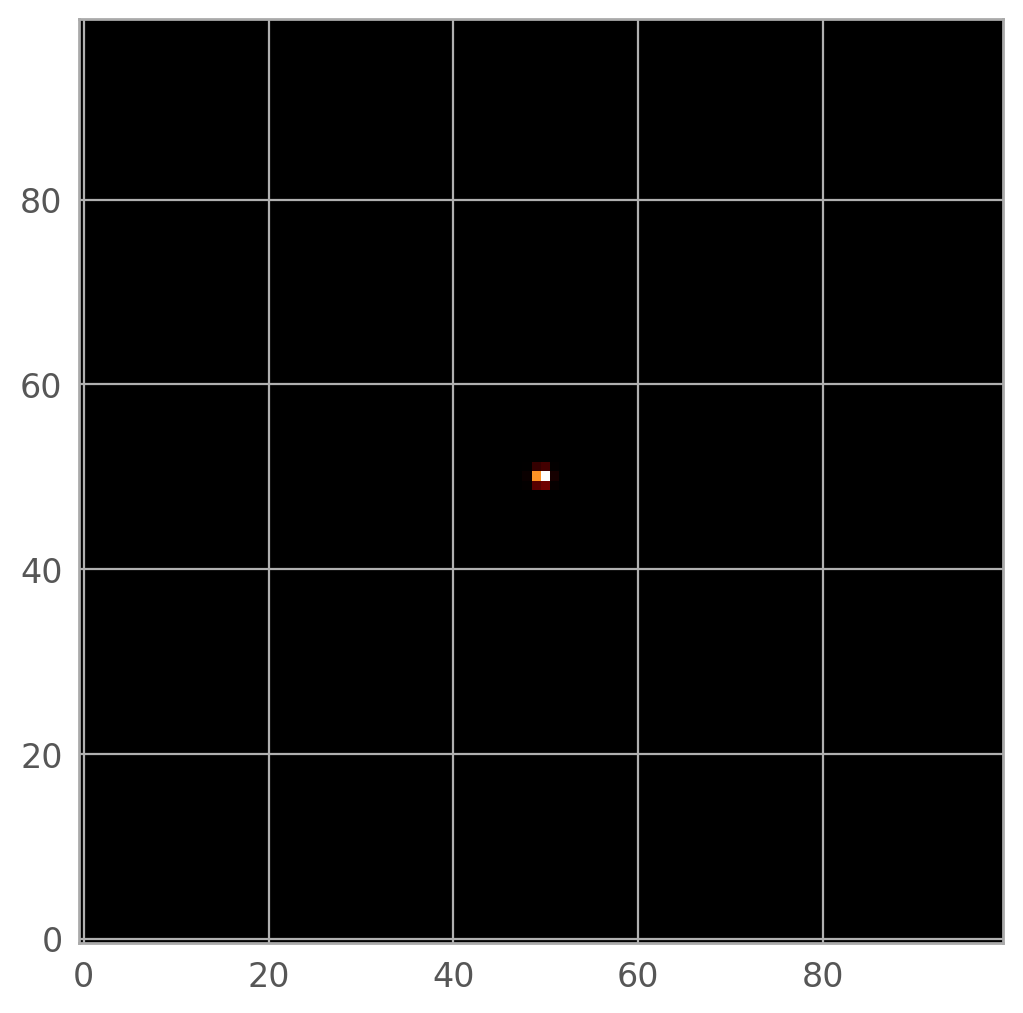

In [58]:
plt.imshow(images[1])